<a href="https://colab.research.google.com/github/christiantpg/deep_learning_tp/blob/main/Black_Friday_product_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import datasets, transforms, utils
from torchvision.transforms import ToTensor
import torchinfo as torchinfo
import optuna
import time
import copy

In [ ]:
black_sales = pd.read_csv("dataset_black_sales.csv")

In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cuda:0'

# Inspección del dataset

Primero leeremos el dataset superficialmente para darnos una idea de su composición

In [ ]:
black_sales.head()

User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
0                          2               0                   3   
1                          2               0                   1   
2                          2               0                  12   
3                          2               0                  12   
4                         4+               0                   8   

   Product_Category_2  Product_Category_3  Purchase  
0                 NaN                 NaN      8370  
1                 6.0                14.0     15200  
2                 NaN                 NaN      1422  
3                14.0                 NaN      1057  
4                 NaN                 NaN      7969

In [ ]:
black_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [ ]:
black_sales.describe(include='all').T

count unique        top    freq  \
User_ID                     550068.0    NaN        NaN     NaN   
Product_ID                    550068   3631  P00265242    1880   
Gender                        550068      2          M  414259   
Age                           550068      7      26-35  219587   
Occupation                  550068.0    NaN        NaN     NaN   
City_Category                 550068      3          B  231173   
Stay_In_Current_City_Years    550068      5          1  193821   
Marital_Status              550068.0    NaN        NaN     NaN   
Product_Category_1          550068.0    NaN        NaN     NaN   
Product_Category_2          376430.0    NaN        NaN     NaN   
Product_Category_3          166821.0    NaN        NaN     NaN   
Purchase                    550068.0    NaN        NaN     NaN   

                                      mean          std        min        25%  \
User_ID                     1003028.842401  1727.591586  1000001.0  1001516.0   
Product_ID                             NaN          NaN        NaN        NaN   
Gender                                 NaN          NaN        NaN        NaN   
Age                                    NaN          NaN        NaN        NaN   
Occupation                        8.076707      6.52266        0.0        2.0   
City_Category                          NaN          NaN        NaN        NaN   
Stay_In_Current_City_Years             NaN          NaN        NaN        NaN   
Marital_Status                    0.409653      0.49177        0.0        0.0   
Product_Category_1                 5.40427     3.936211        1.0        1.0   
Product_Category_2                9.842329      5.08659        2.0        5.0   
Product_Category_3               12.668243     4.125338        3.0        9.0   
Purchase                       9263.968713  5023.065394       12.0     5823.0   

                                  50%        75%        max  
User_ID                     1003077.0  1004478.0  1006040.0  
Product_ID                        NaN        NaN        NaN  
Gender                            NaN        NaN        NaN  
Age                               NaN        NaN        NaN  
Occupation                        7.0       14.0       20.0  
City_Category                     NaN        NaN        NaN  
Stay_In_Current_City_Years        NaN        NaN        NaN  
Marital_Status                    0.0        1.0        1.0  
Product_Category_1                5.0        8.0       20.0  
Product_Category_2                9.0       15.0       18.0  
Product_Category_3               14.0       16.0       18.0  
Purchase                       8047.0    12054.0    23961.0

In [ ]:
print(f'Cantidad de nulls en la columna Product_Category_2: {black_sales["Product_Category_2"].isna().sum()}')
print(f'Cantidad de nulls en la columna Product_Category_3: {black_sales["Product_Category_3"].isna().sum()}')
print('\n')
print(f'Cantidad de valores únicos de User_id: {black_sales["User_ID"].nunique()}')
print(f'Cantidad de valores únicos de Occupation: {black_sales["Occupation"].nunique()}. Valores: {black_sales["Occupation"].unique()}')
print(f'Cantidad de valores únicos de Gender: {black_sales["Gender"].nunique()}. Valores: {black_sales["Gender"].unique()}')
print(f'Cantidad de valores únicos de Age: {black_sales["Age"].nunique()}. Valores: {black_sales["Age"].unique()}')
print(f'Cantidad de valores únicos de City_Category: {black_sales["City_Category"].nunique()}. Valores: {black_sales["City_Category"].unique()}')
print(f'Cantidad de valores únicos de Stay_In_Current_City_Years: {black_sales["Stay_In_Current_City_Years"].nunique()}. Valores: {black_sales["Stay_In_Current_City_Years"].unique()}')
print(f'Cantidad de valores únicos de Marital_Status: {black_sales["Marital_Status"].nunique()}. Valores: {black_sales["Marital_Status"].unique()}')
print(f'Cantidad de valores únicos de Product_Category_1: {black_sales["Product_Category_1"].nunique()} Valores: {black_sales["Product_Category_1"].unique()}')
print(f'Cantidad de valores únicos de Product_Category_2: {black_sales["Product_Category_2"].nunique()} Valores: {black_sales["Product_Category_2"].unique()}')
print(f'Cantidad de valores únicos de Product_Category_3: {black_sales["Product_Category_3"].nunique()} Valores: {black_sales["Product_Category_3"].unique()}')


Cantidad de nulls en la columna Product_Category_2: 173638
Cantidad de nulls en la columna Product_Category_3: 383247


Cantidad de valores únicos de User_id: 5891
Cantidad de valores únicos de Occupation: 21. Valores: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
Cantidad de valores únicos de Gender: 2. Valores: ['F' 'M']
Cantidad de valores únicos de Age: 7. Valores: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Cantidad de valores únicos de City_Category: 3. Valores: ['A' 'C' 'B']
Cantidad de valores únicos de Stay_In_Current_City_Years: 5. Valores: ['2' '4+' '3' '1' '0']
Cantidad de valores únicos de Marital_Status: 2. Valores: [0 1]
Cantidad de valores únicos de Product_Category_1: 20 Valores: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Cantidad de valores únicos de Product_Category_2: 17 Valores: [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Cantidad de valores únicos de Product_Category_3: 15 Valores: [nan


Tipos de datos:

- **Variables categóricas**: `Product_ID`, `Gender`, `Age`, `City_Category`, `Stay_In_Current_City_Years`.
- **Variables numéricas**: `User_ID`, `Occupation`, `Marital_Status`, `Product_Category_1`, `Product_Category_2`, `Product_Category_3`, `Purchase`.

Observaciones:

- Si bien algunas variables podrían considerarse numérias, la realidad es que a excepción de `Purchase` todas están enmascarando una categoría.
- Aunque las columnas `Product_Category_2`, `Product_Category_3` tengan punto flotante, no existen valores que hagan uso de este tipo de datos y podrían perfectamente ser enteros.
- Las únicas columnas que presentan nulos son `Product_Category_2`, `Product_Category_3`. Podríamos asumir que esos productos están categorizados con menos valores.
- Se puede ver como existen más ventas que cantidad de usuarios y productos únicos. Sugiere entonces que no sólo varios usuarios compraron el mismo producto sino que además un usuario podría haber comprado más de un producto.
- El dataset parecería mezclar información inherente al cliente con información del producto. Lo cuál me despierta la duda de si esta información es consistente en cada venta. Es decir, si la información del producto y usuario es la misma en diversas ventas.
- Tanto `User_ID`, cómo `Product_ID` son identificadores por lo tanto se deberá hacer embeding. Los primeros ejercicios de este trabajo no pretende que usemos esta técnica por lo que probablemente las descartemos.

In [ ]:
columns_to_check = ['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']
for col in columns_to_check:
    duplicates = black_sales.groupby('User_ID')[col].nunique() > 1
    if duplicates.any():
        print(f"La columna '{col}' tiene valores distintos para algunos usuarios.")
    else:
        print(f"La columna '{col}' tiene valores iguales para todos los usuarios.")

print('\n')

columns_to_check = ['Product_Category_1', 'Product_Category_2', 'Product_Category_3']
for col in columns_to_check:
    duplicates = black_sales.groupby('Product_ID')[col].nunique() > 1
    if duplicates.any():
        print(f"La columna '{col}' tiene valores distintos para algunos productos.")
    else:
        print(f"La columna '{col}' tiene valores iguales para todos los productos.")

La columna 'Gender' tiene valores iguales para todos los usuarios.
La columna 'Age' tiene valores iguales para todos los usuarios.
La columna 'Occupation' tiene valores iguales para todos los usuarios.
La columna 'City_Category' tiene valores iguales para todos los usuarios.
La columna 'Stay_In_Current_City_Years' tiene valores iguales para todos los usuarios.
La columna 'Marital_Status' tiene valores iguales para todos los usuarios.


La columna 'Product_Category_1' tiene valores iguales para todos los productos.
La columna 'Product_Category_2' tiene valores iguales para todos los productos.
La columna 'Product_Category_3' tiene valores iguales para todos los productos.


Todas las filas presentan valores consistentes para las columnas que representan valores tanto de los usuarios como de los productos

Realizaré una transformación de las columnas Product_Category_2 y Product_Category_3 rellenando los nulls con valores -1 para representar los missings.

In [ ]:
black_sales['Product_Category_2'] = black_sales['Product_Category_2'].fillna(-1).astype('int64')
black_sales['Product_Category_3'] = black_sales['Product_Category_3'].fillna(-1).astype('int64')

Analizaré las ventas "outliers", es decir, aquellas ventas dónde se pagó significativamente menos o más para el valor normal de un producto. Por ahora solo agregaré una columna en el dataset para informarle luego al modelo que esa row es un outlier.

In [ ]:
product_stats = black_sales.groupby('Product_ID')['Purchase'].agg(['mean', 'std']).reset_index()
product_stats.rename(columns={'mean': 'purchase_mean', 'std': 'purchase_std'}, inplace=True)

black_sales = black_sales.merge(product_stats, on='Product_ID', how='left')

threshold = 3
black_sales['is_outlier'] = (np.abs(black_sales['Purchase'] - black_sales['purchase_mean']) > (threshold * black_sales['purchase_std'])).astype(int)

black_sales.drop(columns=['purchase_mean', 'purchase_std'], inplace=True)

print(f"Número de outliers: {black_sales['is_outlier'].sum()}")


Número de outliers: 2632


Los outliers parecerían no ser una cantidad significativa en el total

Veremos la distribución de los valores de la columna Purchase para saber si hay sesgo en los datos

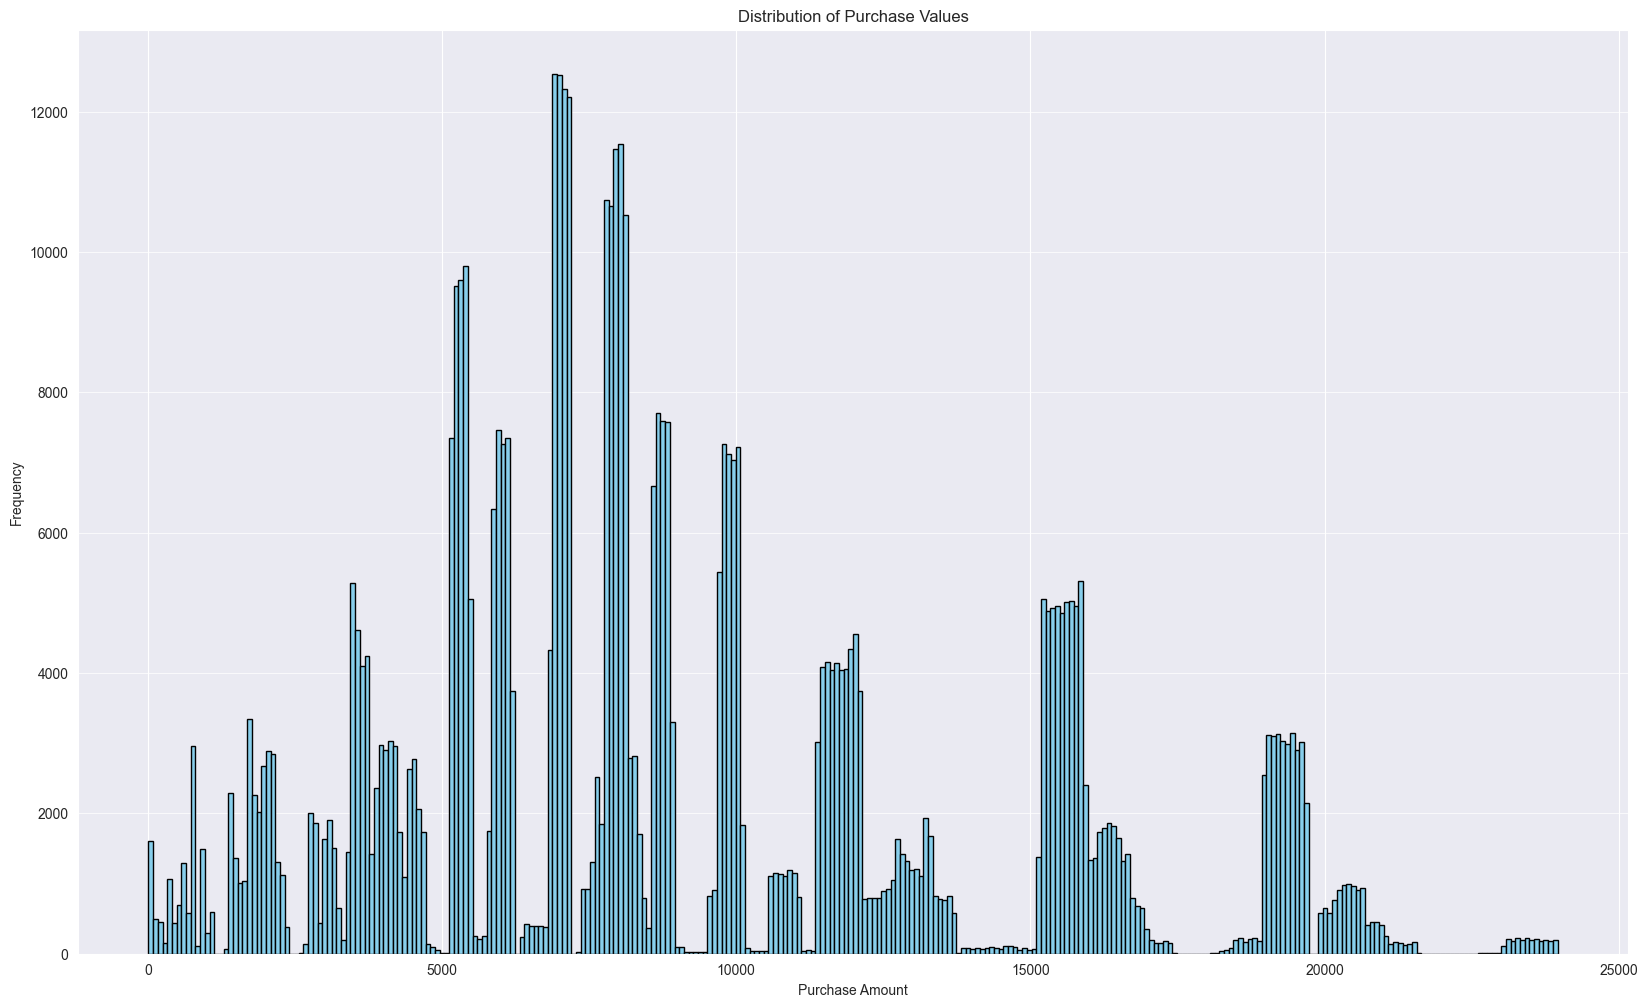

In [ ]:
plt.figure(figsize=(20, 12))
plt.hist(black_sales['Purchase'], bins=300, color='skyblue', edgecolor='black')
plt.title('Distribution of Purchase Values')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Se puede ver una cantidad de ventas con valores entre 5000 y 10000 mucho más preporenderante que el resto de las ventas.
Otra observación es el límite entre el grupo 1 y 2, al rededor del número 10000 parecerían haber muchas ventas. Con lo cuál los factores que ayudan a predecir si una venta pertenece al grupo 1 o 2 sean dificiles de captar o de diferenciar para cada uno de los grupos.

Ahora reemplazaré la columna Purchase con valores continuos por la clasificación Purchase_Category que será la target de los modelos que entrenaré


In [ ]:
def categorize_purchase(purchase):
    if 0 <= purchase <= 5000:
        return 0
    elif 5000 < purchase <= 10000:
        return 1
    elif 10000 < purchase <= 15000:
        return 2
    else:
        return 3

black_sales['Purchase_Category'] = black_sales['Purchase'].apply(categorize_purchase)
# Elimino la columna de salida ya enmascarada
black_sales.drop(columns=['Purchase'], inplace=True)

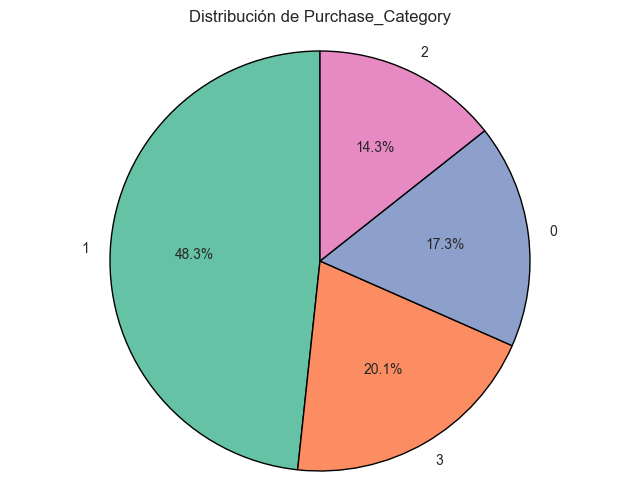

In [ ]:
purchase_distribution = black_sales['Purchase_Category'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(purchase_distribution, labels=purchase_distribution.index,
        autopct='%1.1f%%', startangle=90,
        wedgeprops={'edgecolor': 'black'},
        colors=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])
plt.title('Distribución de Purchase_Category')
plt.axis('equal')
plt.show()

Posiblemente, este desbalance en la distribución de los datos afecte directamente las predicciones de los modelos, por ahora no las modificaremos. Pero posiblemente en una segunda iteración tenga que acondicionarlos utilizando alguna técnica de sampling.

Este problema en el dataset me indica que no podré usar la métrica de accuracy, sino que deberé usar balanced accuracy. Si usara la métrica tradicional introduciría mucho sesgo en los resultados, ya que no tiene en cuenta las métricas de cada clase y su presencia en el dataset, la misma representa los resultados generales del modelo. En cambio balanced accuracy representa el promedio del recall de cada una de las clases.

# Feature Engineering

Primero convertiré las features categóricas a numéricas para luego hacer una matriz de correlación.

- Gender será mappeado a 0 si es F y 1 si es M.
- A Age se le hará one hot encoding para evitar inferencias de cardinalidad. Si bien puede que una categoria sea más cercana a otra (por ejemplo 55+ sea más cercana a 45-50 que a 18-25) preferiría dejarle esta inferencia a la NN más adelante.
- City_Category se le hará one hot encoding porque no tiene cardinalidad
- A Stay_In_Current_City_Years se le realizará un proceso de mapping para preservar la cardinalidad.
- Se realizará one hot encoding sobre las columnas `Occupation`, `Product_Category_1`, `Product_Category_2` y `Product_Category_3`. Si bien complejizará el modelo agregando muchas columnas prefiero eso a dar una falsa idea de carinalidad en los datos.

In [ ]:
black_sales = pd.get_dummies(black_sales, columns=['Age'], prefix='Age', dtype='int64')
black_sales = pd.get_dummies(black_sales, columns=['City_Category'], prefix='City_Category', dtype='int64')
black_sales = pd.get_dummies(black_sales, columns=['Occupation'], prefix=['Occupation'], dtype='int64')
black_sales = pd.get_dummies(black_sales, columns=['Product_Category_1'], prefix='Category_1', dtype='int64')
black_sales = pd.get_dummies(black_sales, columns=['Product_Category_2'], prefix='Category_2', dtype='int64')
black_sales = pd.get_dummies(black_sales, columns=['Product_Category_3'], prefix='Category_3', dtype='int64')
black_sales['Stay_In_Current_City_Years'] = black_sales['Stay_In_Current_City_Years'].map({'0': 0, '1': 1, '2': 2, '3': 3, '4+': 4})
black_sales['Gender'] = black_sales['Gender'].map({'F': 0, 'M': 1})


Podría en estos casos armar una matriz de correlación para encontrar relaciones lineales entre las features y el target. Sin embargo Al hacerle one hot encoding las columnas contendrán valores binarios mientras que la matriz de correlación captura mejor las relaciones con valores continuos.

Por lo tanto pienso que esté gráfico no agregará mucha información al análisis

# Otros Modelos


## Configuración y preparación

In [ ]:
label_encoder = LabelEncoder()
black_sales['Product_ID'] = label_encoder.fit_transform(black_sales['Product_ID'])

In [ ]:
X = black_sales.drop(columns=['Purchase_Category'])
y = black_sales['Purchase_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = metrics.confusion_matrix(y_true, y_pred)

    class_labels = ["0", "1", "2", "3"]

    # Normalize confusion matrix to get percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Combine raw numbers and percentages into annotations
    annotations = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            raw = cm[i, j]
            percentage = cm_normalized[i, j] * 100
            annotations[i, j] = f"{raw}\n({percentage:.1f}%)"

    # Set up class labels if not provided
    if class_labels is None:
        class_labels = [str(i) for i in range(cm.shape[0])]

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=annotations, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


Ridge Classifier
              precision    recall  f1-score   support

           0       0.81      0.48      0.60     28477
           1       0.82      0.84      0.83     79709
           2       0.55      0.26      0.36     23678
           3       0.57      0.96      0.71     33157

    accuracy                           0.72    165021
   macro avg       0.69      0.63      0.62    165021
weighted avg       0.73      0.72      0.70    165021

balanced accuracy 0.6331928612256562


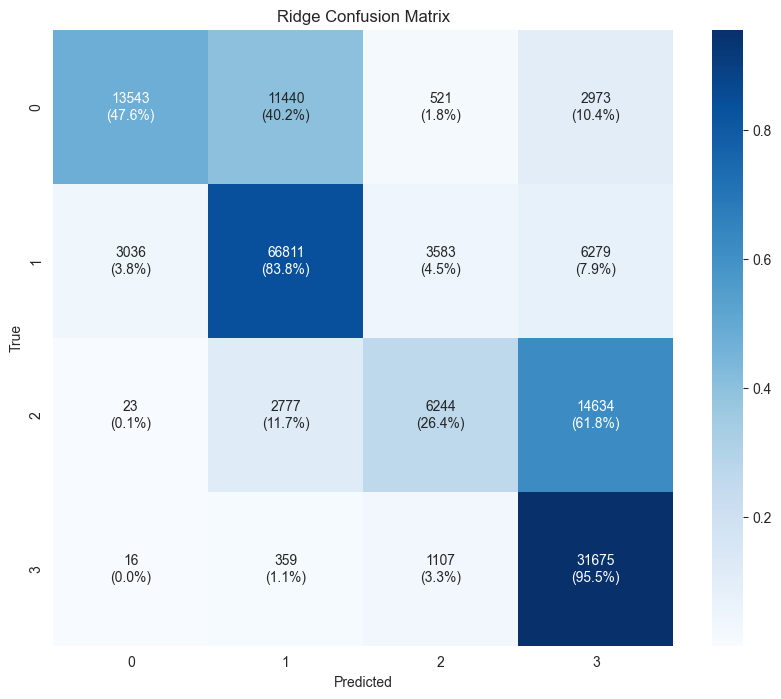

In [ ]:
## Raw Data
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)
y_pred_ridge_test = ridge.predict(X_test)

print("Ridge Classifier")
print(metrics.classification_report(y_test, y_pred_ridge_test))
print(f'balanced accuracy {metrics.balanced_accuracy_score(y_test, y_pred_ridge_test)}')
plot_confusion_matrix(y_test, y_pred_ridge_test, "Ridge Confusion Matrix")

Random Forest
              precision    recall  f1-score   support

           0       0.67      0.52      0.59     28477
           1       0.79      0.82      0.80     79709
           2       0.44      0.38      0.41     23678
           3       0.65      0.79      0.71     33157

    accuracy                           0.70    165021
   macro avg       0.64      0.63      0.63    165021
weighted avg       0.69      0.70      0.69    165021

balanced accuracy 0.6266614440185798


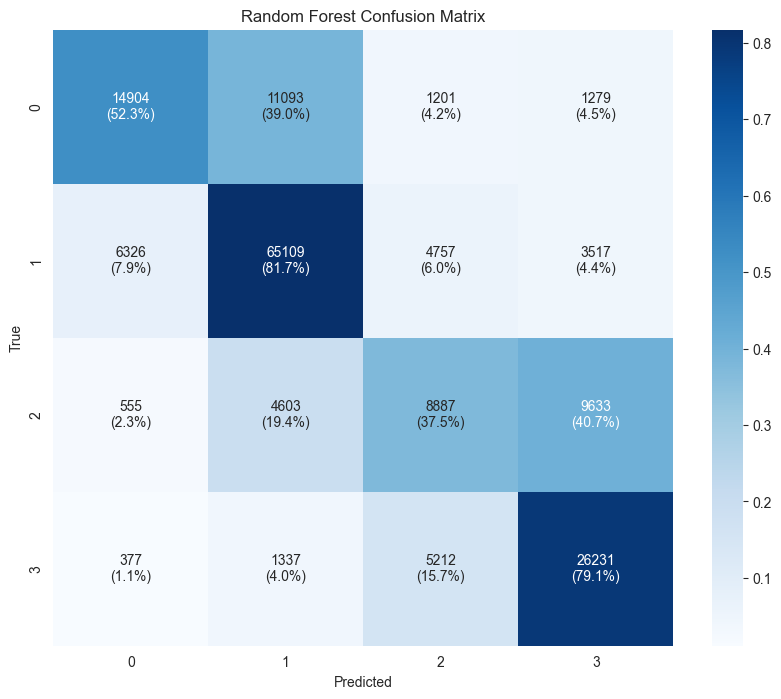

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('Random Forest')
print(metrics.classification_report(y_test, y_pred_rf))
print(f'balanced accuracy {metrics.balanced_accuracy_score(y_test, y_pred_rf)}')
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

XGBoost
              precision    recall  f1-score   support

           0       0.86      0.46      0.60     28477
           1       0.82      0.85      0.83     79709
           2       0.53      0.28      0.37     23678
           3       0.57      0.95      0.72     33157

    accuracy                           0.72    165021
   macro avg       0.70      0.64      0.63    165021
weighted avg       0.74      0.72      0.70    165021

balanced accuracy 0.6352488384967764


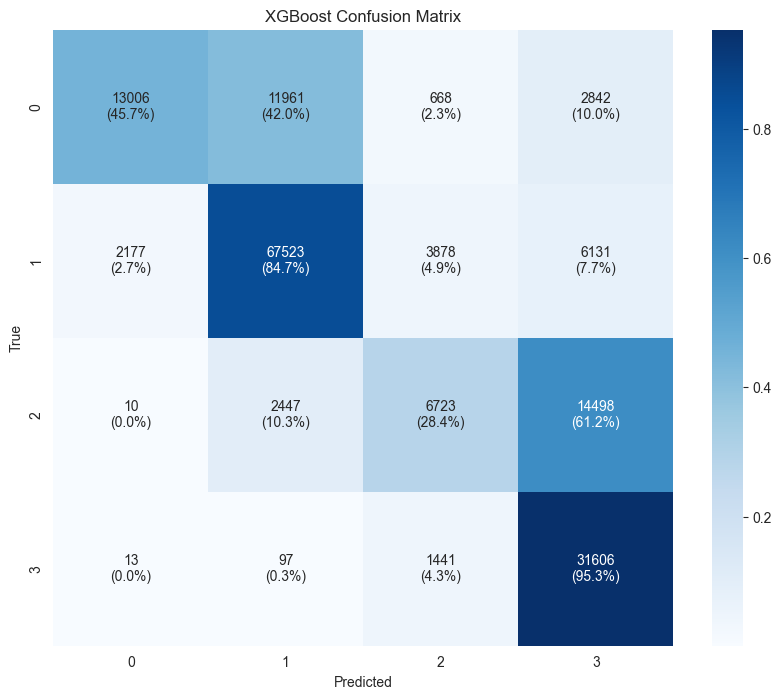

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print('XGBoost')
print(metrics.classification_report(y_test, y_pred_xgb))
print(f'balanced accuracy {metrics.balanced_accuracy_score(y_test, y_pred_xgb)}')
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

Todos los modelos parecerían tener resultados similares:

- Lograron capturar muy bien el comportamiento de la clase 1, tiene un alto recall y también buena precisión. Es decir pocos falsos negativos y pocos falsos positivos también.
- La clase 0 tiene muy buena precisión pero mal recall. Esto nos indica que hay muchos falsos negativos perdiendo muchos verdaderos positivos, podríamos interpretar que están siendo muy conservadores a la hora de clasificar una venta como grupo 0. Random forest fue el modelo que a costa de precisión logró mejorar el recall pero no por mucho.
- La clase 3 tiene mucho recall y una baja precisión, nos indica que logra capturar cuando la venta no es de clase 3 a costa de tener muchos falsos positivos también.
- Por lejos la clase que peor identifican los modelos es la número 2, tiene baja precisión y pésimo recall. Les está costando mucho captar su comportamiento y en general la confunden con la clase 1 o 3. Esto se debe al desbalanceo del dataset, ya que no contamos con suficiente información como para captar su comportamiento.

Aunque en términos generales los modelos tuvieron una salida similar el Random Forest es el qué más balance tiene en las métricas para todas las clases.


## Undersampling

Utilizaré técnicas de resampling para balancear el dataset. Haré undersampling para no generar datos artificiales.

In [ ]:
def undersample(X, y, random_state=42):
    sampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_resampled, y_resampled = sampler.fit_resample(X, y)

    print(f"Original distribución original: {Counter(y)}")
    print(f'Cantidad de datos pre sample: {X.shape[0]}')
    print(f"Nueva distribución: {Counter(y_resampled)}")
    print(f'Cantidad de datos post sample: {X_resampled.shape[0]}')

    return X_resampled, y_resampled

Original distribución original: Counter({1: 265695, 3: 110523, 0: 94923, 2: 78927})
Cantidad de datos pre sample: 550068
Nueva distribución: Counter({0: 78927, 1: 78927, 2: 78927, 3: 78927})
Cantidad de datos post sample: 315708


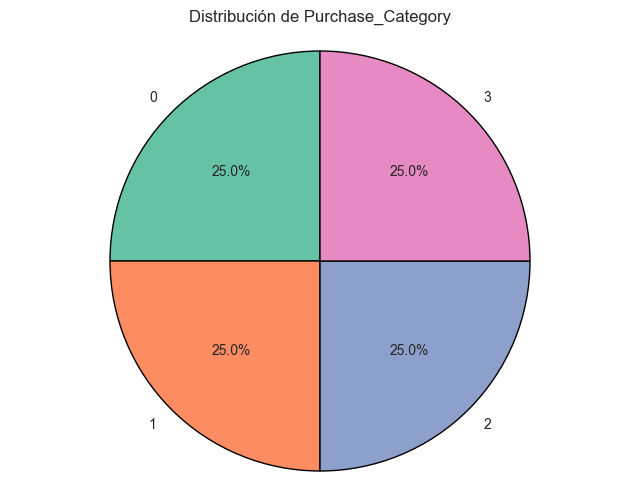

In [ ]:
X_resampled, y_resampled = undersample(X, y, random_state=42)
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

purchase_distribution = y_resampled.value_counts()

plt.figure(figsize=(8, 6))
plt.pie(purchase_distribution, labels=purchase_distribution.index,
        autopct='%1.1f%%', startangle=90,
        wedgeprops={'edgecolor': 'black'},
        colors=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'])
plt.title('Distribución de Purchase_Category')
plt.axis('equal')
plt.show()


              precision    recall  f1-score   support

           0       0.92      0.48      0.63     23678
           1       0.63      0.83      0.72     23678
           2       0.68      0.31      0.43     23679
           3       0.55      0.94      0.69     23678

    accuracy                           0.64     94713
   macro avg       0.69      0.64      0.62     94713
weighted avg       0.69      0.64      0.62     94713

balanced accuracy 0.6391025956307004


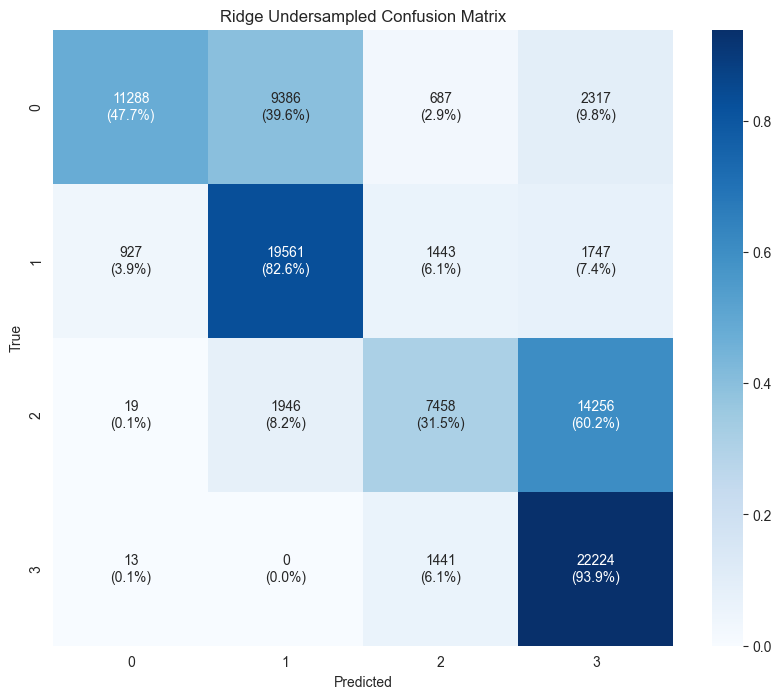

In [ ]:
ridge = RidgeClassifier()
ridge.fit(X_train_undersampled, y_train_undersampled)
y_pred_ridge_test = ridge.predict(X_test_undersampled)

print(metrics.classification_report(y_test_undersampled, y_pred_ridge_test))
print(f'balanced accuracy {metrics.balanced_accuracy_score(y_test_undersampled, y_pred_ridge_test)}')
plot_confusion_matrix(y_test_undersampled, y_pred_ridge_test, "Ridge Undersampled Confusion Matrix")

              precision    recall  f1-score   support

           0       0.74      0.64      0.68     23678
           1       0.65      0.67      0.66     23678
           2       0.55      0.52      0.53     23679
           3       0.63      0.73      0.67     23678

    accuracy                           0.64     94713
   macro avg       0.64      0.64      0.64     94713
weighted avg       0.64      0.64      0.64     94713

balanced accuracy 0.6389525928738269


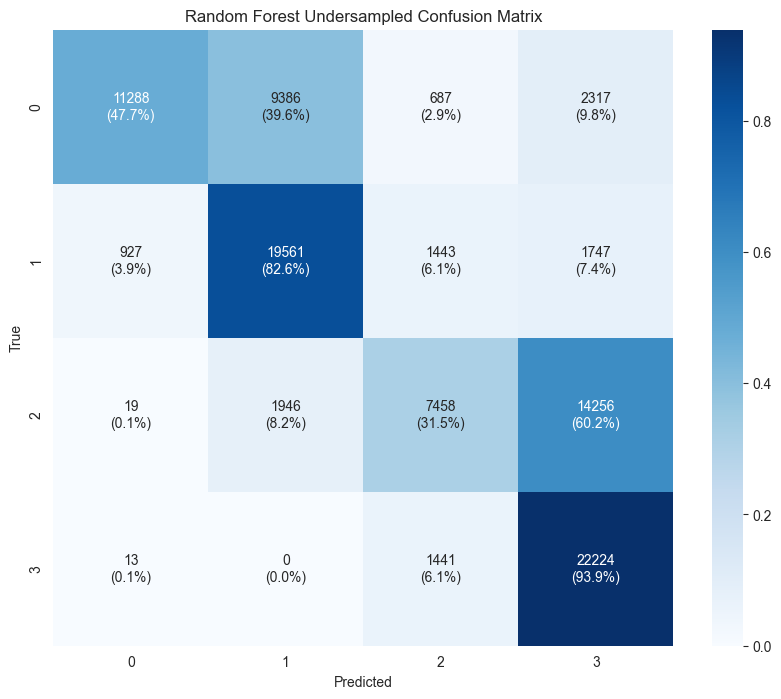

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_undersampled, y_train_undersampled)
y_pred_rf = rf.predict(X_test_undersampled)

print(metrics.classification_report(y_test_undersampled, y_pred_rf))
print(f'balanced accuracy {metrics.balanced_accuracy_score(y_test_undersampled, y_pred_rf)}')
plot_confusion_matrix(y_test_undersampled, y_pred_ridge_test, "Random Forest Undersampled Confusion Matrix")

              precision    recall  f1-score   support

           0       0.91      0.50      0.65     23678
           1       0.64      0.81      0.72     23678
           2       0.62      0.38      0.48     23679
           3       0.58      0.90      0.70     23678

    accuracy                           0.65     94713
   macro avg       0.69      0.65      0.64     94713
weighted avg       0.69      0.65      0.64     94713

balanced accuracy 0.6500191680023778


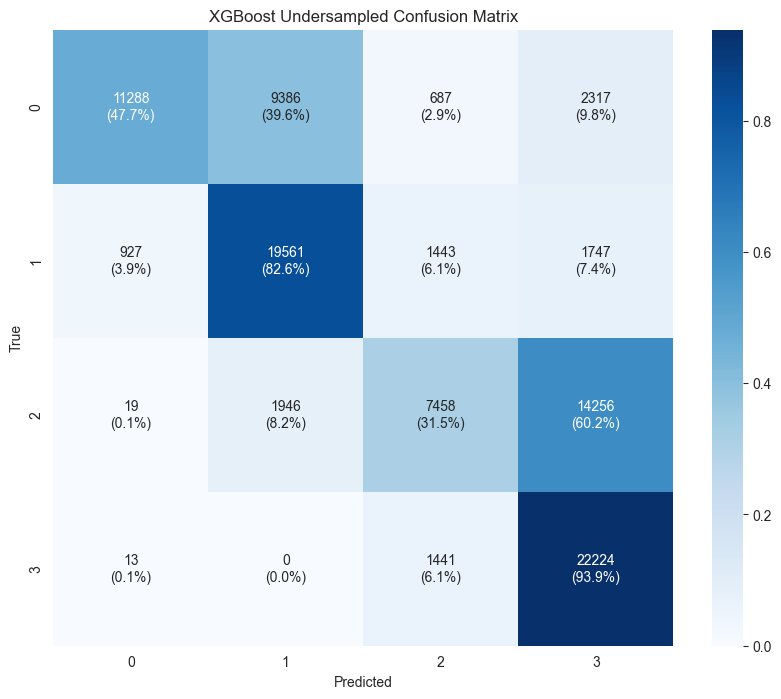

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train_undersampled, y_train_undersampled)
y_pred_xgb = xgb_model.predict(X_test_undersampled)

print(metrics.classification_report(y_test_undersampled, y_pred_xgb))
print(f'balanced accuracy {metrics.balanced_accuracy_score(y_test_undersampled, y_pred_xgb)}')
plot_confusion_matrix(y_test_undersampled, y_pred_ridge_test, "XGBoost Undersampled Confusion Matrix")

Se puede apreciar que eliminar el desbalance de clases en el dataset no fue gratuito. Si bien tanto el recall como la precisión de la clase 2 mejoraron, las métricas de la clase 1 fueron bastante perjudicadas sobre todo en Random Forest. En general el accuracy mejoró por lo que podríamos decir que los resultados están más balanceados.

# Modelado de NN

## No Embedding

### Preparación del dataset

In [ ]:
black_sales_no_embeddings = black_sales.drop(columns=['User_ID', 'Product_ID'])

In [ ]:
class BlackSalesDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [ ]:
def normalize_data(X):
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

def prepare_dataloaders(X, y, batch_size=64, test_size=0.3, random_state=42):
    # Normalize the data
    X_norm = normalize_data(X)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_norm, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Create PyTorch datasets
    train_ds = BlackSalesDataset(X_train, y_train)
    test_ds = BlackSalesDataset(X_test, y_test)

    # Create DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    print(f"Training samples: {len(train_ds)}, Test samples: {len(test_ds)}")
    return train_dl, test_dl, len(X_train), len(X_test)

In [ ]:
X = black_sales_no_embeddings.drop(columns=['Purchase_Category']).to_numpy()
y = black_sales_no_embeddings['Purchase_Category'].to_numpy()

train_dl, test_dl, n_train, n_valid = prepare_dataloaders(X, y)

Training samples: 385047, Test samples: 165021


### Configuración e implementación

In [ ]:
def train_one_epoch(nnet, train_dl, loss_function, optimizer, device):
    nnet.train()
    epoch_loss = 0
    epoch_y_hat = []
    epoch_y = []

    for x_batch, y_batch in train_dl:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).long()

        # Forward pass
        optimizer.zero_grad()
        nnet_output = nnet(x_batch)

        # Calculate loss
        loss = loss_function(nnet_output, y_batch)

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()

        # Metrics
        _, predicted = torch.max(nnet_output, 1)
        epoch_y += list(y_batch.detach().cpu().numpy())
        epoch_y_hat += list(predicted.detach().cpu().numpy())
        epoch_loss += loss.item()

    # Calculate metrics
    accuracy = metrics.balanced_accuracy_score(epoch_y, epoch_y_hat)
    avg_loss = epoch_loss / len(train_dl)
    return avg_loss, accuracy


def validate_one_epoch(nnet, test_dl, loss_function, device):
    nnet.eval()
    epoch_loss = 0
    epoch_y_hat = []
    epoch_y = []

    with torch.no_grad():
        for x_batch, y_batch in test_dl:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).long()

            # Forward pass
            nnet_output = nnet(x_batch)

            # Calculate loss
            loss = loss_function(nnet_output, y_batch)

            # Metrics
            _, predicted = torch.max(nnet_output, 1)
            epoch_y += list(y_batch.detach().cpu().numpy())
            epoch_y_hat += list(predicted.detach().cpu().numpy())
            epoch_loss += loss.item()

    # Calculate metrics
    accuracy = metrics.balanced_accuracy_score(epoch_y, epoch_y_hat)
    avg_loss = epoch_loss / len(test_dl)
    return avg_loss, accuracy, epoch_y, epoch_y_hat

def plot_training_progress(train_loss, valid_loss, train_acc, valid_acc):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot loss
    axes[0].plot(train_loss, label='Training Loss')
    axes[0].plot(valid_loss, label='Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss per Epoch')
    axes[0].legend()

    # Plot accuracy
    axes[1].plot(train_acc, label='Training Accuracy')
    axes[1].plot(valid_acc, label='Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy per Epoch')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


def train_model(nnet, train_dl, test_dl, loss_function, optimizer, scheduler, device, epochs=100, patience=10, quiet=False):
    best_valid_loss = float('inf')
    best_valid_acc = float('inf')
    best_valid_y = float('inf')
    best_valid_y_hat = float('inf')
    early_stopping_counter = 0
    train_loss_by_epoch = []
    valid_loss_by_epoch = []
    train_accuracy_by_epoch = []
    valid_accuracy_by_epoch = []

    for epoch in range(epochs):
        # Train and validate for one epoch
        train_loss, train_accuracy = train_one_epoch(nnet, train_dl, loss_function, optimizer, device)
        valid_loss, valid_accuracy, valid_y, valid_y_hat = validate_one_epoch(nnet, test_dl, loss_function, device)

        if scheduler is not None:
            scheduler.step()

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_acc = valid_accuracy
            best_valid_y = valid_y
            best_valid_y_hat = valid_y_hat
            early_stopping_counter = 0
            torch.save(nnet.state_dict(), 'best_model.pth')

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                if not quiet:
                    print("Early stopping!")
                break

        # Record loss for plotting
        train_loss_by_epoch.append(train_loss)
        valid_loss_by_epoch.append(valid_loss)
        train_accuracy_by_epoch.append(train_accuracy)
        valid_accuracy_by_epoch.append(valid_accuracy)

        if not quiet:
            print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | "
                  f"Train Accuracy: {train_accuracy:.4f} | Valid Accuracy: {valid_accuracy:.4f}")

    if not quiet:
        plot_training_progress(train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch)
        print(metrics.classification_report(best_valid_y, best_valid_y_hat))
        print(f'balanced accuracy {best_valid_acc}')
        plot_confusion_matrix(best_valid_y, best_valid_y_hat, title="Final Confusion Matrix")

    return best_valid_acc


### Estructura

La estructura de la red neuronal que elegí es de 3 capas ocultas fully connected.

Cada capa tiene distintas funciones:

- *Linear()*: Transformación lineal que toma las features de entrada (x) y las asocia a una función y = Wx + b, dónde W es el vector de los pesos, b es el vector de los bias e "y" será el vector de las features de salidas de la capa.

- *BatchNorm1d()*: Se utiliza para normalizar la salida de la función lineal.

- *ReLU()*: Función de activación no lineal. Si el resultado es menor a cero lo convierte a cero y si es mayor lo deja como está. Tiene una doble utilidad, no solo le permite a la red captar comportamiento no lineal, sino que además evita el problema de vanishing gradient.

- *Dropout()*: Agrega regularización apagando un cierto número de neuronas (en este caso el 30%) para evitar overfitting.


En la capa de salida no usaré softmax al estar incluída en la función de costo "CrossEntropyLoss". La idea de Softmax es la de transformar los números de las features de salida a probabilidades, es decir, la red neuronal tendría un número de salidas igual a la cantidad de grupos de clasificación. Cada uno de ellos tendrá una probabilidad de acierto.

In [ ]:
class NNet(torch.nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.linear_1 = torch.nn.Linear(89, 256)
        self.batch_norm1 = torch.nn.BatchNorm1d(256)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(0.3)

        self.linear_2 = torch.nn.Linear(256, 128)
        self.batch_norm2 = torch.nn.BatchNorm1d(128)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(0.3)

        self.linear_3 = torch.nn.Linear(128, 64)
        self.batch_norm3 = torch.nn.BatchNorm1d(64)
        self.relu_3 = torch.nn.ReLU()
        self.dropout_3 = torch.nn.Dropout(0.3)

        self.output = torch.nn.Linear(64, 4)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.batch_norm1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)

        x = self.linear_2(x)
        x = self.batch_norm2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)

        x = self.linear_3(x)
        x = self.batch_norm3(x)
        x = self.relu_3(x)
        x = self.dropout_3(x)

        x = self.output(x)
        return x

Para estructurar la red empecé por una muy simple de dos capas (200 y 100), luego fui complejizándola analizando sus resultados. Las métricas que utilicé para comparar entre los modelos fue tanto el recall y la precision de cada clase como balanced accuracy general. La estructura que presenté fue la que mejores resultados dió al balancearla con su simplicidad.

A continuación presentaré 3 modelos distintos:

A continuación mostraré algunos de los resultados obtenidos con distintas configuraciones de la red. Para todas usaré en la función de costo distribuciones de peso para aplacar el desbalance en la cantidad de muestras de cada clase:

NN de 2 capas ocultas 200 > 100:

        precision    recall  f1-score
    0       0.74      0.52      0.61
    1       0.84      0.80      0.82
    2       0.45      0.43      0.44
    3       0.62      0.86      0.72

    balanced accuracy 0.654301937079971

NN de 3 capas ocultas 512 > 256 > 128:

        precision    recall  f1-score
    0       0.75      0.52      0.61
    1       0.84      0.80      0.82
    2       0.44      0.46      0.45
    3       0.62      0.84      0.71

    balanced accuracy 0.6542793847215299

NN de 5 capas ocultas 512 > 256 > 128 > 64 > 32:

        precision    recall  f1-score
    0       0.78      0.50      0.61
    1       0.84      0.82      0.83
    2       0.45      0.43      0.44
    3       0.62      0.87      0.72

    balanced accuracy 0.6523903788464379

### Modelo Base

Este modelo cuenta con los datos sin ninguna consideración sobre el desbalance de clases.

Epoch 1 | Train Loss: 0.7247 | Valid Loss: 0.6985 | Train Accuracy: 0.6171 | Valid Accuracy: 0.6383
Epoch 2 | Train Loss: 0.7084 | Valid Loss: 0.6966 | Train Accuracy: 0.6229 | Valid Accuracy: 0.6310
Epoch 3 | Train Loss: 0.7064 | Valid Loss: 0.6956 | Train Accuracy: 0.6244 | Valid Accuracy: 0.6343
Epoch 4 | Train Loss: 0.7045 | Valid Loss: 0.6947 | Train Accuracy: 0.6270 | Valid Accuracy: 0.6299
Epoch 5 | Train Loss: 0.7036 | Valid Loss: 0.6931 | Train Accuracy: 0.6268 | Valid Accuracy: 0.6388
Epoch 6 | Train Loss: 0.7034 | Valid Loss: 0.6933 | Train Accuracy: 0.6267 | Valid Accuracy: 0.6406
Epoch 7 | Train Loss: 0.7030 | Valid Loss: 0.6930 | Train Accuracy: 0.6270 | Valid Accuracy: 0.6332
Epoch 8 | Train Loss: 0.7029 | Valid Loss: 0.6932 | Train Accuracy: 0.6270 | Valid Accuracy: 0.6335
Epoch 9 | Train Loss: 0.7025 | Valid Loss: 0.6946 | Train Accuracy: 0.6265 | Valid Accuracy: 0.6318
Epoch 10 | Train Loss: 0.7024 | Valid Loss: 0.6942 | Train Accuracy: 0.6270 | Valid Accuracy: 0.6207

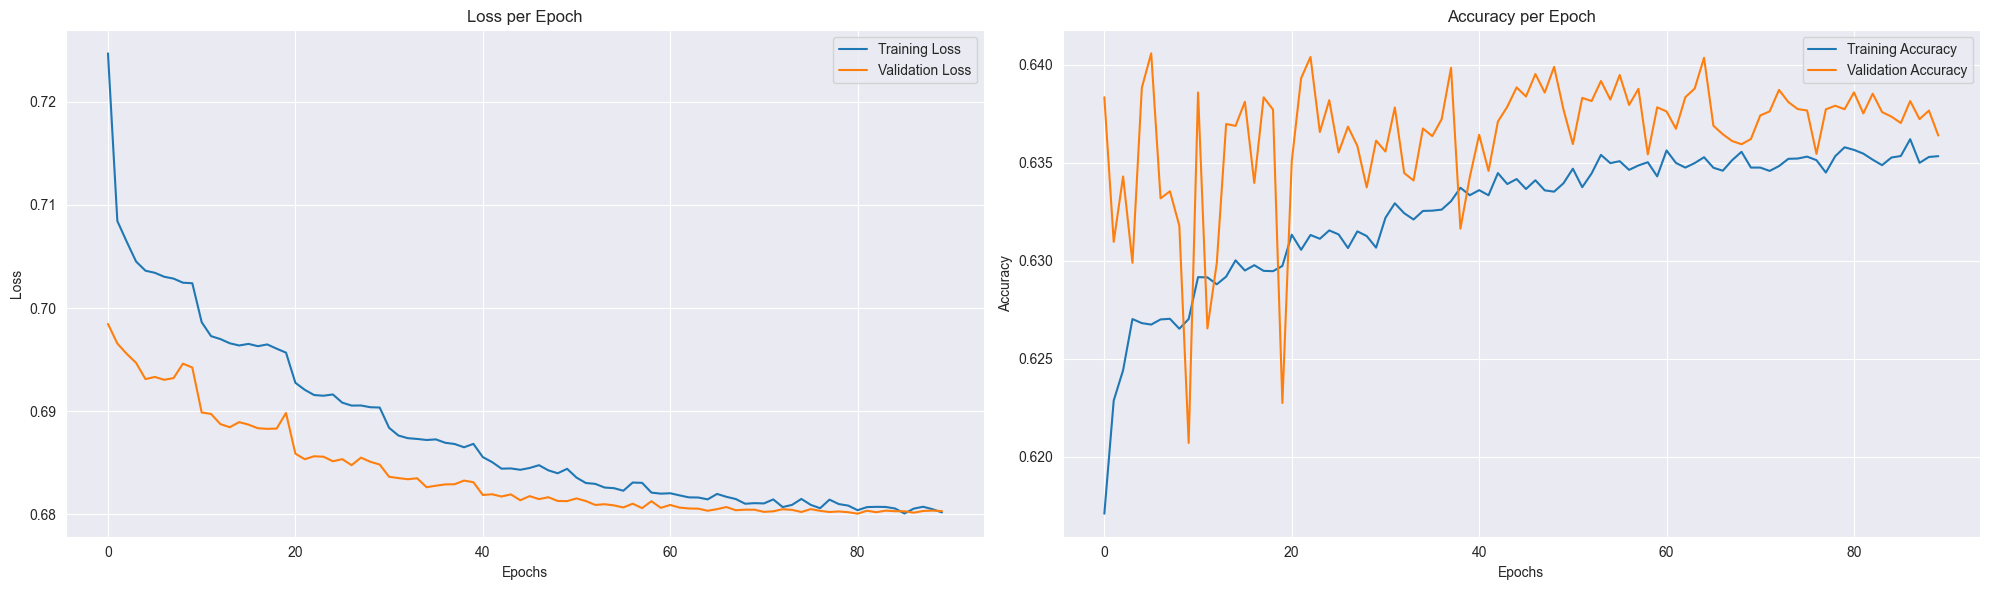

              precision    recall  f1-score   support

           0       0.84      0.46      0.60     28477
           1       0.82      0.85      0.83     79709
           2       0.51      0.31      0.39     23678
           3       0.59      0.93      0.72     33157

    accuracy                           0.72    165021
   macro avg       0.69      0.64      0.64    165021
weighted avg       0.73      0.72      0.71    165021

balanced accuracy 0.6385798561573385


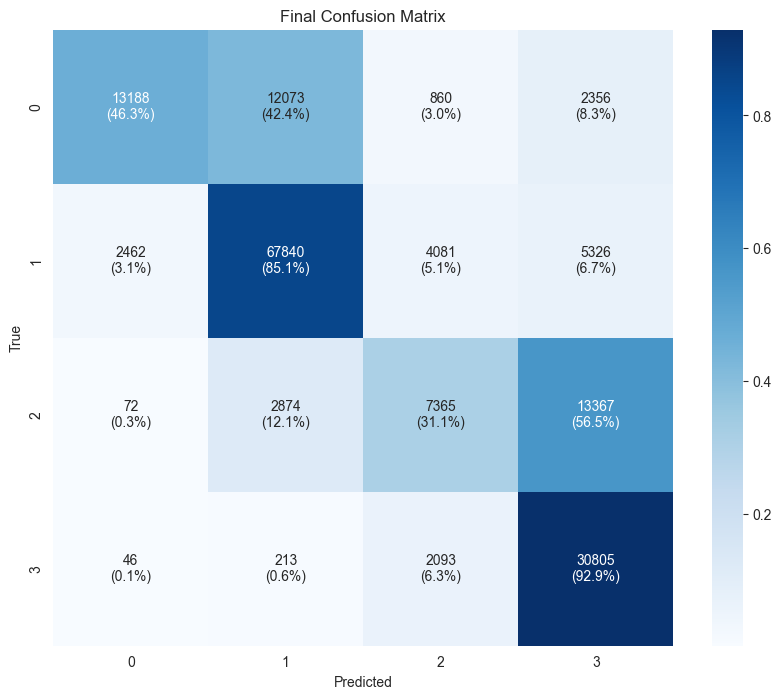

In [ ]:
nnet = NNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_model(
    nnet=nnet,
    train_dl=train_dl,
    test_dl=test_dl,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=100,
    patience=10
)

Se puede ver que si bien el accuracy es bastante bueno (0.72), balanced accuracy da 0.63 indicando que además de tener un dataset desbalanceado.

Se puede apreciar como el modelo sufre de overfitting, en la gráfica de la función de costo vemos como aproximadamente en la época 40 la red dejó de aprender verdaderamente y comenzó simplemente a ajustarse al comportamiento del set de entrenamiento. Esto se puede apreciar comparando ambas curvas, la de validación dejó de descender mientras que la de entrenamiento continuó bajando.

Se puede ver la diferencia entre la función de costo y la de validación. Si bien está aprendiendo a distinguir entre las distintas clases lo hace con un nivel de confianza bajo, además no está penalizando la clase mayoritaria por lo cuál si bien podría estar acertando quizás lo hace más veces para la clase 1 y poco para las demás.
En cambio balanced accuracy sí toma en cuenta este desbalance y por eso su valor se mantiene constante sin crecer demasiado.

Viendo los gráficos podría decir que el modelo está underfitteando, es decir está generalizando demasiado y no logra captar adecuadamente el comportamiento de cada una de las clases. Esto lo observo ya que balanced accuracy no crece demasiado y su valor es bastante lejano a 1


### Modelo con peso en la función de costo

Aprovechando el parámetro weight de la función de costo CrossEntropyLoss, calculé los distintos pesos para cada clase. De esta forma manualmente pude ajustar que tanto penalizar los desaciertos de la red para cada grupo.

Class Weights: [1.4487216  0.51757466 1.74233152 1.24423876]
Epoch 1 | Train Loss: 0.8134 | Valid Loss: 0.7840 | Train Accuracy: 0.6345 | Valid Accuracy: 0.6432
Epoch 2 | Train Loss: 0.7951 | Valid Loss: 0.7818 | Train Accuracy: 0.6409 | Valid Accuracy: 0.6433
Epoch 3 | Train Loss: 0.7922 | Valid Loss: 0.7816 | Train Accuracy: 0.6425 | Valid Accuracy: 0.6447
Epoch 4 | Train Loss: 0.7906 | Valid Loss: 0.7797 | Train Accuracy: 0.6421 | Valid Accuracy: 0.6446
Epoch 5 | Train Loss: 0.7902 | Valid Loss: 0.7792 | Train Accuracy: 0.6418 | Valid Accuracy: 0.6435
Epoch 6 | Train Loss: 0.7891 | Valid Loss: 0.7799 | Train Accuracy: 0.6419 | Valid Accuracy: 0.6455
Epoch 7 | Train Loss: 0.7888 | Valid Loss: 0.7767 | Train Accuracy: 0.6424 | Valid Accuracy: 0.6468
Epoch 8 | Train Loss: 0.7890 | Valid Loss: 0.7782 | Train Accuracy: 0.6427 | Valid Accuracy: 0.6447
Epoch 9 | Train Loss: 0.7881 | Valid Loss: 0.7756 | Train Accuracy: 0.6429 | Valid Accuracy: 0.6460
Epoch 10 | Train Loss: 0.7884 | Valid L

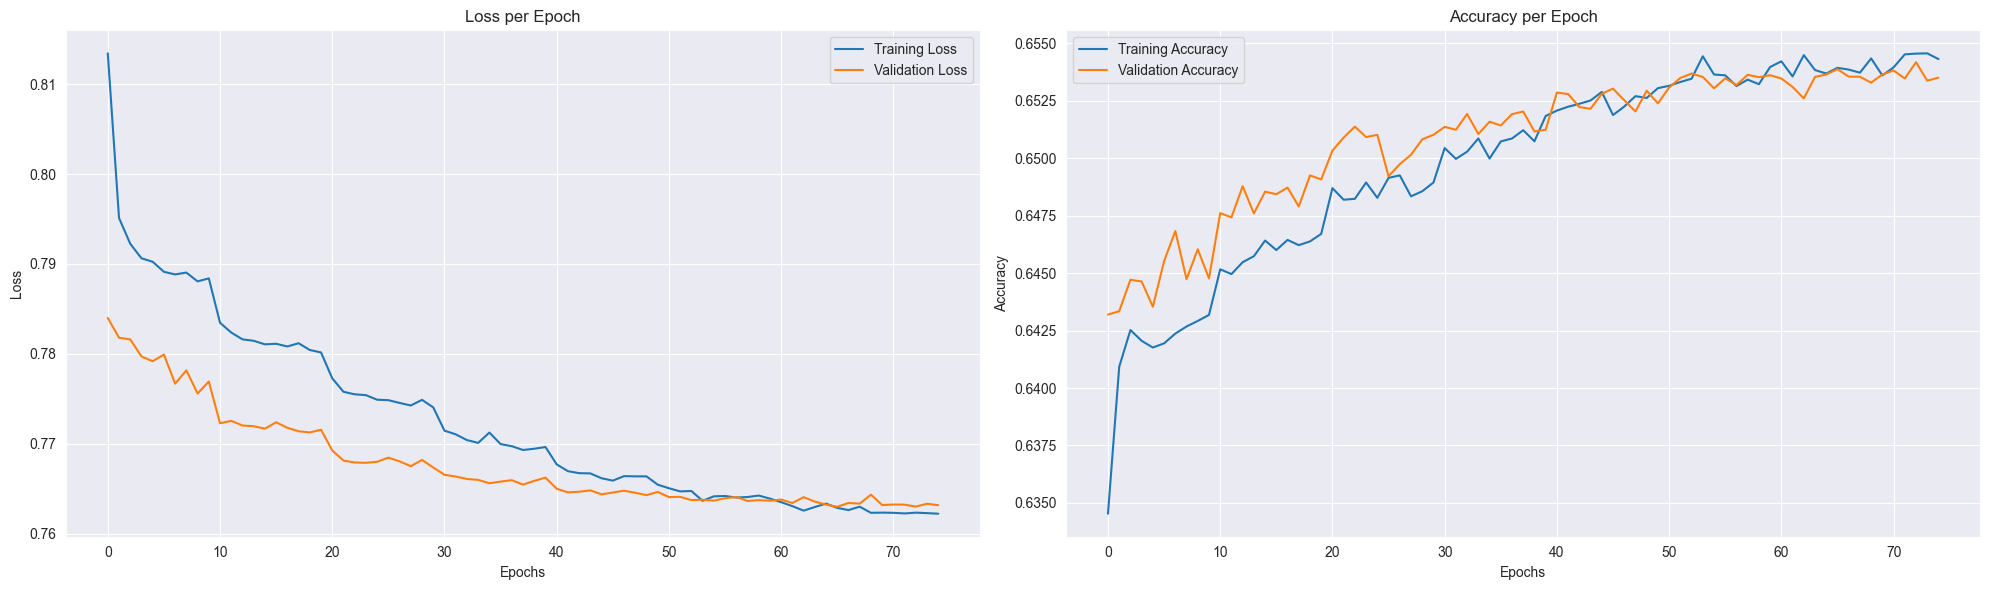

              precision    recall  f1-score   support

           0       0.75      0.52      0.61     28477
           1       0.84      0.80      0.82     79709
           2       0.45      0.44      0.44     23678
           3       0.62      0.85      0.72     33157

    accuracy                           0.71    165021
   macro avg       0.66      0.65      0.65    165021
weighted avg       0.72      0.71      0.71    165021

balanced accuracy 0.6538727355059479


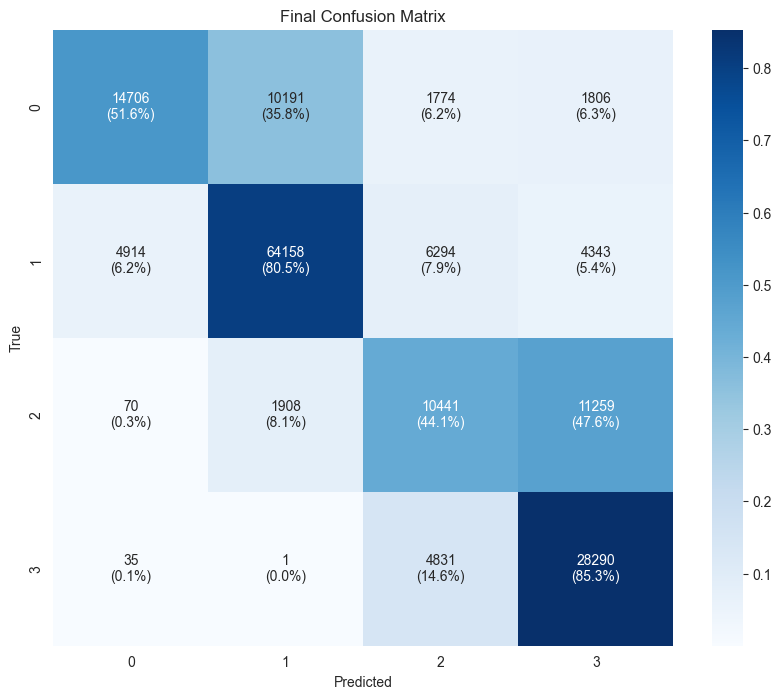

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

print("Class Weights:", class_weights)

normalized_weights = class_weights / np.sum(class_weights)
weights = torch.tensor(normalized_weights, dtype=torch.float).to(device)
loss_function = torch.nn.CrossEntropyLoss(weight=weights)

nnet = NNet().to(device)
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_model(
    nnet=nnet,
    train_dl=train_dl,
    test_dl=test_dl,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=100,
    patience=10
)

Este modelo dió mejores resultados en torno a balanced accuracy. También vemos una notable mejora en la distribución de los errores respecto al anterior modelo, por ejemplo:
- La clase 0 tuvo menos precision, pero ganó en recall. Aumentaron los falsos positivos mientras que los falsos negativos disminuyeron para dicha clase.
- Lo contrario ocurrió para la clase 1, dónde perdió recall y ganó un poco de precision
- La clase más complicada, la 2 también ganó bastante balance aunque los resultados no fueron tan buenos como se esperaban. De todas formas el f1 mejoró.
- La clase 3 tuvo el mismo problema que la clase 1, perdió recall pero ganó precision.

Al igual que el modelo base este modelo sufre de overfitting.

### Modelo con down sampling

Original distribución original: Counter({np.int64(1): 265695, np.int64(3): 110523, np.int64(0): 94923, np.int64(2): 78927})
Cantidad de datos pre sample: 550068
Nueva distribución: Counter({np.int64(0): 78927, np.int64(1): 78927, np.int64(2): 78927, np.int64(3): 78927})
Cantidad de datos post sample: 315708
Training samples: 220995, Test samples: 94713
Epoch 1 | Train Loss: 0.8191 | Valid Loss: 0.7852 | Train Accuracy: 0.6331 | Valid Accuracy: 0.6400
Epoch 2 | Train Loss: 0.7957 | Valid Loss: 0.7843 | Train Accuracy: 0.6424 | Valid Accuracy: 0.6427
Epoch 3 | Train Loss: 0.7923 | Valid Loss: 0.7806 | Train Accuracy: 0.6435 | Valid Accuracy: 0.6431
Epoch 4 | Train Loss: 0.7896 | Valid Loss: 0.7796 | Train Accuracy: 0.6437 | Valid Accuracy: 0.6438
Epoch 5 | Train Loss: 0.7879 | Valid Loss: 0.7800 | Train Accuracy: 0.6438 | Valid Accuracy: 0.6447
Epoch 6 | Train Loss: 0.7879 | Valid Loss: 0.7801 | Train Accuracy: 0.6440 | Valid Accuracy: 0.6444
Epoch 7 | Train Loss: 0.7872 | Valid Loss: 0.

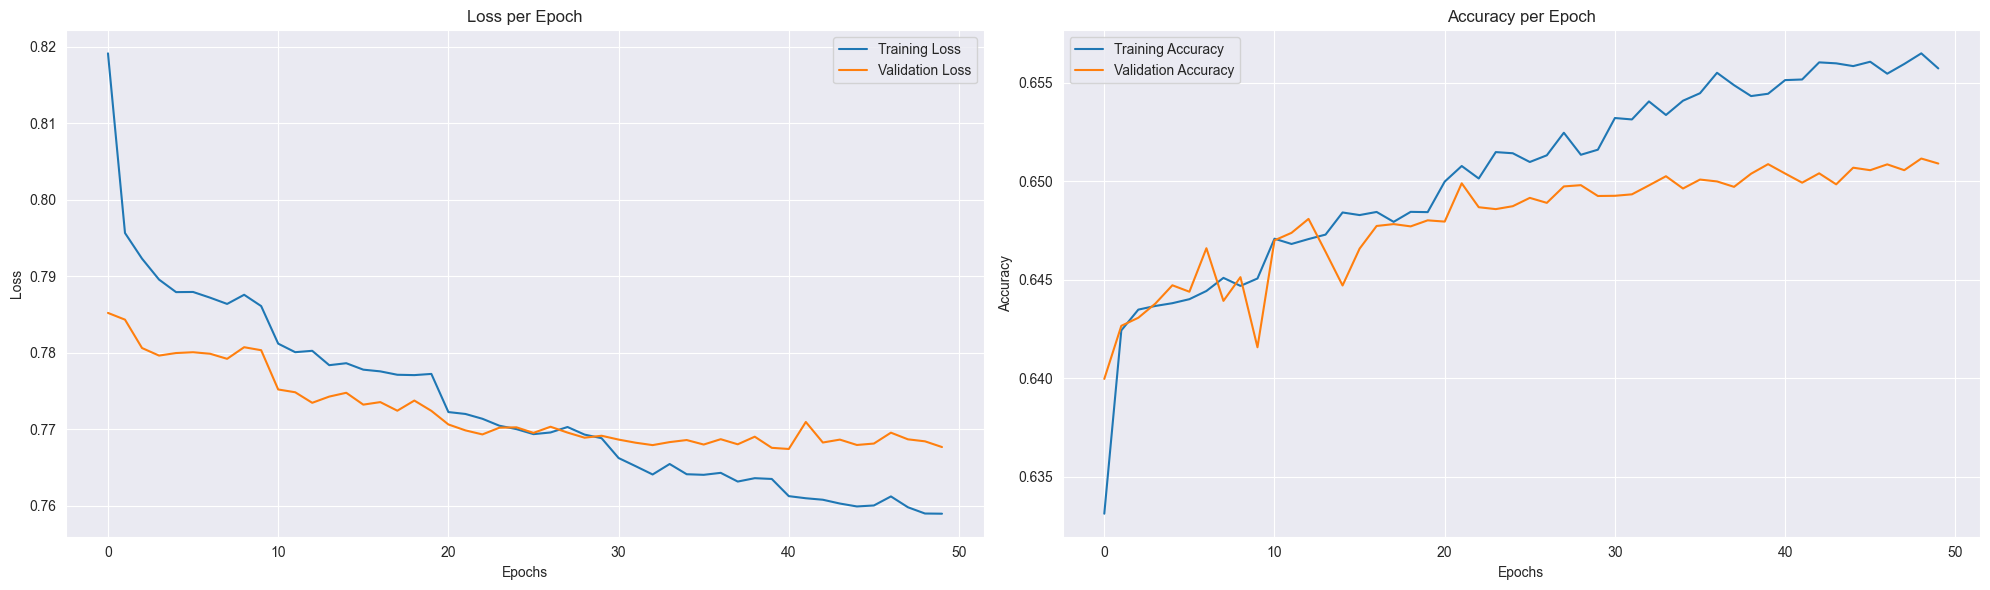

              precision    recall  f1-score   support

           0       0.87      0.52      0.65     23678
           1       0.65      0.79      0.71     23678
           2       0.62      0.41      0.49     23679
           3       0.58      0.87      0.70     23678

    accuracy                           0.65     94713
   macro avg       0.68      0.65      0.64     94713
weighted avg       0.68      0.65      0.64     94713

balanced accuracy 0.650388423084823


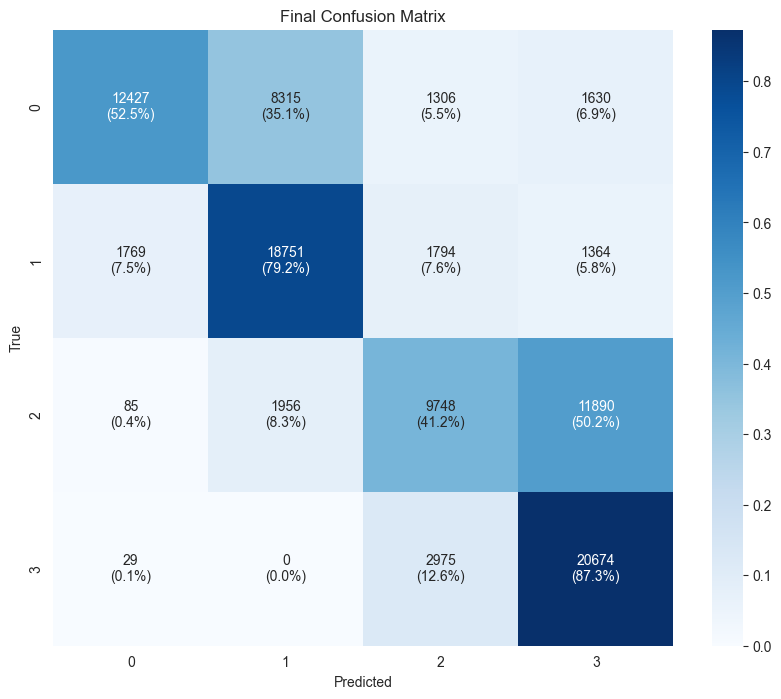

In [ ]:
X_resampled, y_resampled = undersample(X, y, random_state=42)
train_dl_resampled, test_dl_resampled, n_train_resampled, n_valid_resampled = prepare_dataloaders(X_resampled, y_resampled)

nnet = NNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_model(
    nnet=nnet,
    train_dl=train_dl_resampled,
    test_dl=test_dl_resampled,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=100,
    patience=10
)

Se puede ver como el modelo está sobre ajustando a los valores del entrenamiento y no está aprendiendo realmente luego de cierto umbral:

- Por un lado la función de costo de validación dejó de disminuir, por lo tanto el modelo no está mejorando en captar con confianza la clase que mejor se ajusta al comportamiento de la venta
- Por otro lado el gráfico que muestra balanced accuracy nos muestra que el modelo solo se está volviendo mejor en reconocer las distintas clases del set de entrenamiento mientras que para el set de validación se ha estancado en 0.65 que si bien no es un mal número comparado a los otros modelos no logra pasar de eso. La diferencia entre ambas curvas nos da a entender que estamos sobreajustando al set de entrenamiento.

## Embeddings

### Preparación del dataset con embeddings

Antes de modificar las capas de la NN deberé preparar nuevamente el dataset para incluir las features con valores de identificadores.

Es importante que haya un balance de los ids tanto en el dataset de entrenamiento como validación; sin embargo, puede ocurrir que haya solo un dato representativo de ese identificador. Primero mediré cuantos de estos casos ocurren tanto para Product_ID como para User_ID

In [ ]:
def split_dataset_balanced(X, y, product_ids, user_ids, test_size=0.3, random_state=42):
    # Fijar la semilla para la reproducibilidad
    random.seed(random_state)

    # Inicializar los conjuntos de entrenamiento y validación
    train_indices = []
    test_indices = []

    # Seguimiento de representaciones únicas en cada conjunto
    train_user_ids = set()
    train_product_ids = set()
    test_user_ids = set()
    test_product_ids = set()

    # Mezclar los datos para garantizar aleatoriedad
    dataset_indices = list(range(len(X)))
    random.shuffle(dataset_indices)

    # Iterar sobre cada índice
    for idx in dataset_indices:
        user_id = user_ids[idx]
        product_id = product_ids[idx]

        # Verificar si ya están representados en ambos conjuntos
        in_train = user_id in train_user_ids and product_id in train_product_ids
        in_test = user_id in test_user_ids and product_id in test_product_ids

        if in_train and in_test:
            if len(test_indices) / len(X) < test_size:
                test_indices.append(idx)
                test_user_ids.add(user_id)
                test_product_ids.add(product_id)
            else:
                train_indices.append(idx)
                train_user_ids.add(user_id)
                train_product_ids.add(product_id)
        elif in_train:
            test_indices.append(idx)
            test_user_ids.add(user_id)
            test_product_ids.add(product_id)
        else:
            train_indices.append(idx)
            train_user_ids.add(user_id)
            train_product_ids.add(product_id)

    # Crear subconjuntos
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    train_product_ids = product_ids[train_indices]
    test_product_ids = product_ids[test_indices]
    train_user_ids = user_ids[train_indices]
    test_user_ids = user_ids[test_indices]

    # Verificar representaciones completas
    assert len(set(user_ids)) == len(set(train_user_ids) | set(test_user_ids))
    assert len(set(product_ids)) == len(set(train_product_ids) | set(test_product_ids))

    # Imprimir el tamaño de cada conjunto
    print(f"Datos en entrenamiento: {len(X_train)}")
    print(f"Datos en validación: {len(X_test)}")

    # Calcular diferencias
    users_only_in_train = set(train_user_ids) - set(test_user_ids)
    products_only_in_train = set(train_product_ids) - set(test_product_ids)
    users_only_in_test = set(test_user_ids) - set(train_user_ids)
    products_only_in_test = set(test_product_ids) - set(train_product_ids)

    print(f"Users solo en entrenamiento: {len(users_only_in_train)}")
    print(f"Products solo en entrenamiento: {len(products_only_in_train)}")
    print(f"Users solo en validación: {len(users_only_in_test)}")
    print(f"Products solo en validación: {len(products_only_in_test)}")

    return X_train, X_test, y_train, y_test, train_product_ids, test_product_ids, train_user_ids, test_user_ids


Vemos que son pocos, por lo tanto, procederé a eliminarlos directamente del dataset. La desventaja de hacer esto es que podría estár generando sesgo pero por otro lado al ser productos poco populares también evitaría ruido en el entrenamiento

In [ ]:
le_products = LabelEncoder()
le_users = LabelEncoder()

black_sales_embeddings = black_sales.copy()

black_sales_embeddings['Product_ID_idx'] = le_products.fit_transform(black_sales_embeddings['Product_ID'])
black_sales_embeddings['User_ID_idx'] = le_users.fit_transform(black_sales_embeddings['User_ID'])

product_ids = black_sales_embeddings['Product_ID_idx']
user_ids = black_sales_embeddings['User_ID_idx']

black_sales_embeddings.drop(columns=['Product_ID_idx', 'User_ID_idx', 'Product_ID', 'User_ID'], inplace=True)

X = black_sales_embeddings.drop(columns=['Purchase_Category']).to_numpy()
y = black_sales_embeddings['Purchase_Category'].to_numpy()

In [ ]:
class BlackSalesDataset(Dataset):
    def __init__(self, x, y, product_ids, user_ids):
        self.x = x
        self.y = y
        self.product_ids = product_ids
        self.user_ids = user_ids

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.product_ids[idx], self.user_ids[idx]


### Configuración e implementación

In [ ]:
def prepare_dataloaders(X, y, product_ids, user_ids, batch_size=64, test_size=0.3, random_state=42):
    # Normalización de los datos
    X_norm = normalize_data(X)

    # Dividir el dataset en entrenamiento y validación
    X_train, X_test, y_train, y_test, train_product_ids, test_product_ids, train_user_ids, test_user_ids = train_test_split(
        X_norm, y, product_ids, user_ids,
        test_size=test_size, random_state=random_state, stratify=y
    )

    # X_train, X_test, y_train, y_test, train_product_ids, test_product_ids, train_user_ids, test_user_ids = split_dataset_balanced(
    #     X_norm, y, product_ids, user_ids
    # )

    # Crear datasets personalizados
    train_ds = BlackSalesDataset(X_train, y_train, train_product_ids.to_numpy(), train_user_ids.to_numpy())
    test_ds = BlackSalesDataset(X_test, y_test, test_product_ids.to_numpy(), test_user_ids.to_numpy())

    # Crear dataloaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    return train_dl, test_dl, len(X_train), len(X_test)

# Llamada a la función
train_dl, test_dl, n_train, n_valid = prepare_dataloaders(X, y, product_ids, user_ids)


In [ ]:
def train_one_epoch(nnet, train_dl, loss_function, optimizer, device):
    nnet.train()
    epoch_loss = 0
    epoch_y_hat = []
    epoch_y = []

    for x_batch, y_batch, product_ids, user_ids in train_dl:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).long()
        product_ids = product_ids.to(device).int()
        user_ids = user_ids.to(device).int()

        # Forward pass
        optimizer.zero_grad()
        nnet_output = nnet(x_batch, product_ids, user_ids)

        # Calculate loss
        loss = loss_function(nnet_output, y_batch)

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()

        # Metrics
        _, predicted = torch.max(nnet_output, 1)
        epoch_y += list(y_batch.detach().cpu().numpy())
        epoch_y_hat += list(predicted.detach().cpu().numpy())
        epoch_loss += loss.item()

    accuracy = metrics.balanced_accuracy_score(epoch_y, epoch_y_hat)
    avg_loss = epoch_loss / len(train_dl)
    return avg_loss, accuracy

def validate_one_epoch(nnet, test_dl, loss_function, device):
    nnet.eval()
    epoch_loss = 0
    epoch_y_hat = []
    epoch_y = []

    with torch.no_grad():
        for x_batch, y_batch, product_ids_batch, user_ids_batch in test_dl:
            x_batch = x_batch.to(device).float()
            product_ids_batch = product_ids_batch.to(device).int()
            user_ids_batch = user_ids_batch.to(device).int()
            y_batch = y_batch.to(device).long()

            # Forward pass
            nnet_output = nnet(x_batch, product_ids_batch, user_ids_batch)

            # Calcular la pérdida
            loss = loss_function(nnet_output, y_batch)

            # Métricas
            _, predicted = torch.max(nnet_output, 1)
            epoch_y += list(y_batch.detach().cpu().numpy())
            epoch_y_hat += list(predicted.detach().cpu().numpy())
            epoch_loss += loss.item()

    # Calcular métricas
    accuracy = metrics.balanced_accuracy_score(epoch_y, epoch_y_hat)
    avg_loss = epoch_loss / len(test_dl)
    return avg_loss, accuracy, epoch_y, epoch_y_hat

def plot_training_progress(train_loss, valid_loss, train_acc, valid_acc):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Plot loss
    axes[0].plot(train_loss, label='Training Loss')
    axes[0].plot(valid_loss, label='Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss per Epoch')
    axes[0].legend()

    # Plot accuracy
    axes[1].plot(train_acc, label='Training Accuracy')
    axes[1].plot(valid_acc, label='Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy per Epoch')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


def train_model(nnet, train_dl, test_dl, loss_function, optimizer, scheduler, device, epochs=100, patience=10):
    best_valid_loss = float('inf')
    best_valid_acc = float('inf')
    best_valid_y = float('inf')
    best_valid_y_hat = float('inf')
    early_stopping_counter = 0
    train_loss_by_epoch = []
    valid_loss_by_epoch = []
    train_accuracy_by_epoch = []
    valid_accuracy_by_epoch = []

    for epoch in range(epochs):
        # Train and validate for one epoch
        train_loss, train_accuracy = train_one_epoch(nnet, train_dl, loss_function, optimizer, device)
        valid_loss, valid_accuracy, valid_y, valid_y_hat = validate_one_epoch(nnet, test_dl, loss_function, device)

        # Scheduler step
        scheduler.step()

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_acc = valid_accuracy
            best_valid_y = valid_y
            best_valid_y_hat = valid_y_hat
            early_stopping_counter = 0
            torch.save(nnet.state_dict(), 'best_model.pth')

        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping!")
                break

        # Record loss for plotting
        train_loss_by_epoch.append(train_loss)
        valid_loss_by_epoch.append(valid_loss)
        train_accuracy_by_epoch.append(train_accuracy)
        valid_accuracy_by_epoch.append(valid_accuracy)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | "
              f"Train Accuracy: {train_accuracy:.4f} | Valid Accuracy: {valid_accuracy:.4f}")

    plot_training_progress(train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch)
    print(metrics.classification_report(best_valid_y, best_valid_y_hat))
    print(f'balanced accuracy {best_valid_acc}')
    plot_confusion_matrix(best_valid_y, best_valid_y_hat, title="Final Confusion Matrix")

    return best_valid_acc


### Estructura

In [ ]:
class NNetWithEmbedding(torch.nn.Module):
    def __init__(self, num_features, num_products, num_users, embedding_dim_products=64, embedding_dim_users=128):
        super(NNetWithEmbedding, self).__init__()

        self.embedding_products = torch.nn.Embedding(num_products, embedding_dim_products)
        self.embedding_users = torch.nn.Embedding(num_users, embedding_dim_users)

        self.linear_1 = torch.nn.Linear(num_features + embedding_dim_products + embedding_dim_users, 256)
        self.batch_norm1 = torch.nn.BatchNorm1d(256)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(0.3)

        self.linear_2 = torch.nn.Linear(256, 128)
        self.batch_norm2 = torch.nn.BatchNorm1d(128)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(0.3)

        self.linear_3 = torch.nn.Linear(128, 64)
        self.batch_norm3 = torch.nn.BatchNorm1d(64)
        self.relu_3 = torch.nn.ReLU()
        self.dropout_3 = torch.nn.Dropout(0.3)

        self.output = torch.nn.Linear(64, 4)

    def forward(self, x, product_ids, user_ids):
        embeddings_product_outputs = self.embedding_products(product_ids)
        embeddings_user_outputs = self.embedding_users(user_ids)

        x = torch.cat([x, embeddings_product_outputs], dim=1)
        x = torch.cat([x, embeddings_user_outputs], dim=1)

        x = self.linear_1(x)
        x = self.batch_norm1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)

        x = self.linear_2(x)
        x = self.batch_norm2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)

        x = self.linear_3(x)
        x = self.batch_norm3(x)
        x = self.relu_3(x)
        x = self.dropout_3(x)

        x = self.output(x)
        return x


### Modelo con peso en la función de costo

Class Weights: [1.4487216  0.51757466 1.74233152 1.24423876]
Epoch 1 | Train Loss: 0.7692 | Valid Loss: 0.6812 | Train Accuracy: 0.6579 | Valid Accuracy: 0.6970
Epoch 2 | Train Loss: 0.6925 | Valid Loss: 0.6718 | Train Accuracy: 0.6960 | Valid Accuracy: 0.7010
Epoch 3 | Train Loss: 0.6802 | Valid Loss: 0.6635 | Train Accuracy: 0.7026 | Valid Accuracy: 0.7060
Epoch 4 | Train Loss: 0.6734 | Valid Loss: 0.6580 | Train Accuracy: 0.7060 | Valid Accuracy: 0.7076
Epoch 5 | Train Loss: 0.6669 | Valid Loss: 0.6550 | Train Accuracy: 0.7085 | Valid Accuracy: 0.7099
Epoch 6 | Train Loss: 0.6631 | Valid Loss: 0.6528 | Train Accuracy: 0.7105 | Valid Accuracy: 0.7100
Epoch 7 | Train Loss: 0.6587 | Valid Loss: 0.6510 | Train Accuracy: 0.7124 | Valid Accuracy: 0.7122
Epoch 8 | Train Loss: 0.6554 | Valid Loss: 0.6500 | Train Accuracy: 0.7136 | Valid Accuracy: 0.7120
Epoch 9 | Train Loss: 0.6530 | Valid Loss: 0.6503 | Train Accuracy: 0.7152 | Valid Accuracy: 0.7130
Epoch 10 | Train Loss: 0.6505 | Valid L

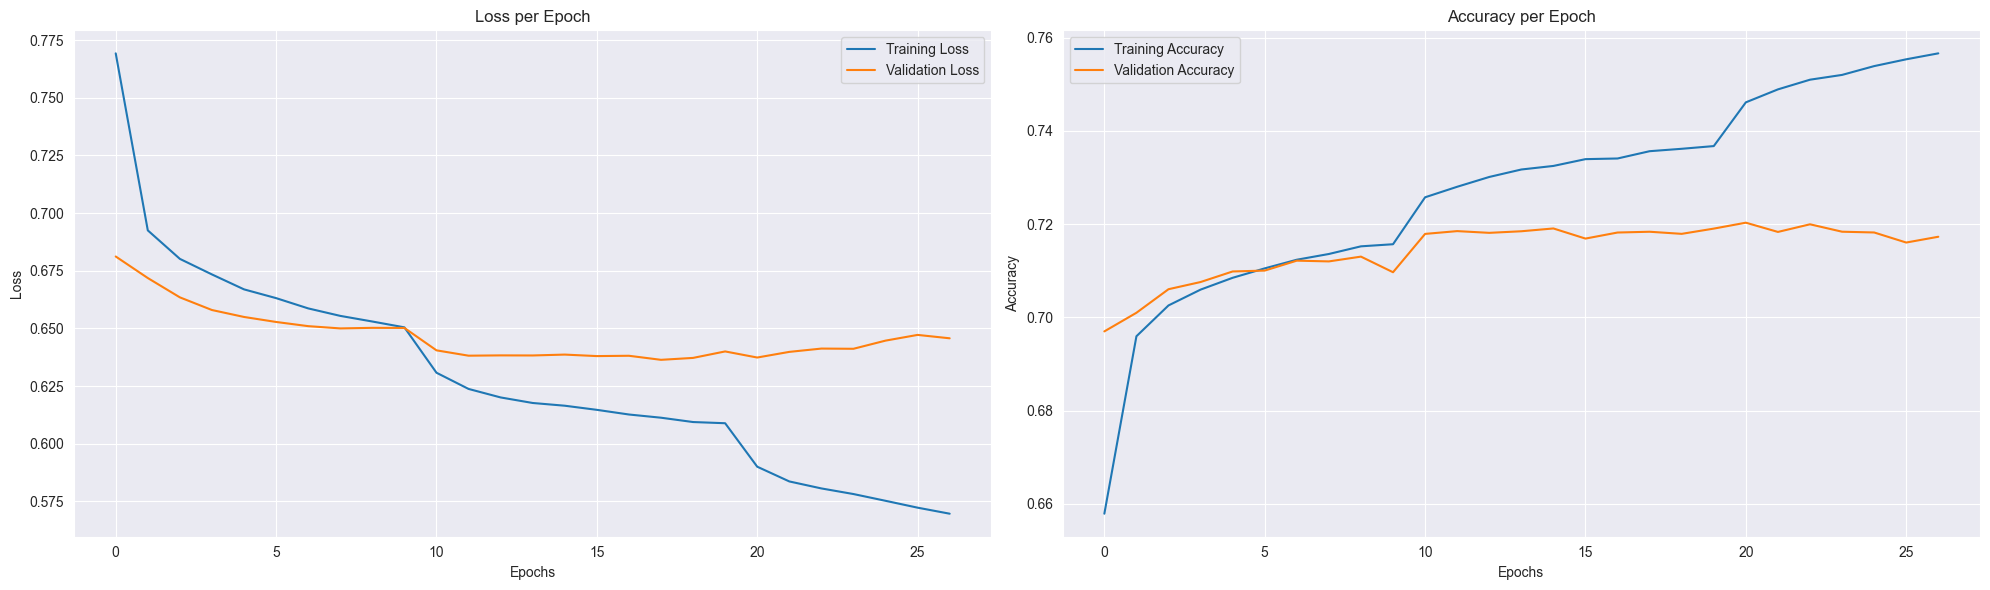

              precision    recall  f1-score   support

           0       0.63      0.74      0.68     28477
           1       0.89      0.74      0.81     79709
           2       0.48      0.56      0.52     23678
           3       0.72      0.84      0.77     33157

    accuracy                           0.73    165021
   macro avg       0.68      0.72      0.70    165021
weighted avg       0.75      0.73      0.74    165021

balanced accuracy 0.7183718040008816


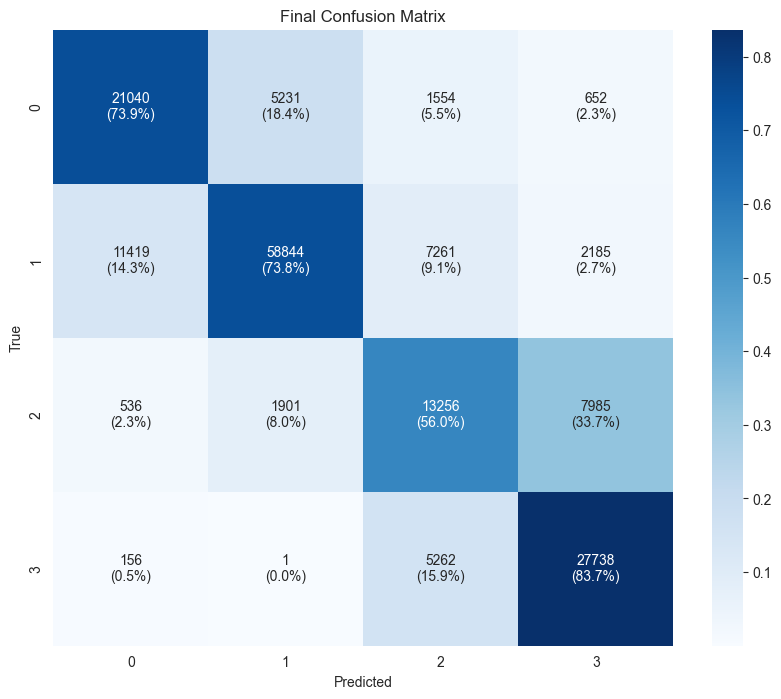

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

print("Class Weights:", class_weights)

normalized_weights = class_weights / np.sum(class_weights)
weights = torch.tensor(normalized_weights, dtype=torch.float).to(device)
loss_function = torch.nn.CrossEntropyLoss(weight=weights)

nnet = NNetWithEmbedding(num_features=X.shape[1], num_products=len(le_products.classes_), num_users=len(le_users.classes_)).to(device)
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_model(
    nnet=nnet,
    train_dl=train_dl,
    test_dl=test_dl,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=100,
    patience=10
)

# Sugerir Usuarios Similares

In [ ]:
def suggest_similar_users(model, user_id, n, le_users):
    user_embeddings = model.embedding_users.weight.data.cpu().numpy()
    user_index = le_users.transform([user_id])[0]
    target_embedding = user_embeddings[user_index].reshape(1, -1)
    similarities = cosine_similarity(target_embedding, user_embeddings).flatten()
    similar_user_indices = similarities.argsort()[-n-1:-1][::-1]
    similar_user_ids = le_users.inverse_transform(similar_user_indices)

    return similar_user_ids

user_id_to_search =  1000002
n_suggestions = 5
similar_users = suggest_similar_users(nnet, user_id_to_search, n_suggestions, le_users)

print(f"Usuarios similares a {user_id_to_search}: {similar_users}")

Usuarios similares a 1000002: [1004953 1001805 1001194 1000220 1005095]


In [ ]:
user_target_products = black_sales[black_sales['User_ID'] == user_id_to_search]['Product_ID']
suggested_users_products = black_sales[black_sales['User_ID'].isin(similar_users)]['Product_ID']

# Verificar intersección de productos
intersection = set(user_target_products).intersection(set(suggested_users_products))
print(f"Productos en común: {len(intersection)}")


Productos en común: 18


# Optimización de parámetros

Testing with embeddings: products=32, users=32
Epoch 1 | Train Loss: 0.7718 | Valid Loss: 0.6823 | Train Accuracy: 0.6557 | Valid Accuracy: 0.6972
Epoch 2 | Train Loss: 0.6902 | Valid Loss: 0.6673 | Train Accuracy: 0.6975 | Valid Accuracy: 0.7046
Epoch 3 | Train Loss: 0.6771 | Valid Loss: 0.6627 | Train Accuracy: 0.7032 | Valid Accuracy: 0.7071
Epoch 4 | Train Loss: 0.6697 | Valid Loss: 0.6575 | Train Accuracy: 0.7070 | Valid Accuracy: 0.7092
Epoch 5 | Train Loss: 0.6640 | Valid Loss: 0.6544 | Train Accuracy: 0.7100 | Valid Accuracy: 0.7114
Epoch 6 | Train Loss: 0.6594 | Valid Loss: 0.6524 | Train Accuracy: 0.7115 | Valid Accuracy: 0.7123
Epoch 7 | Train Loss: 0.6557 | Valid Loss: 0.6509 | Train Accuracy: 0.7133 | Valid Accuracy: 0.7133
Epoch 8 | Train Loss: 0.6528 | Valid Loss: 0.6493 | Train Accuracy: 0.7140 | Valid Accuracy: 0.7126
Epoch 9 | Train Loss: 0.6505 | Valid Loss: 0.6470 | Train Accuracy: 0.7154 | Valid Accuracy: 0.7148
Epoch 10 | Train Loss: 0.6493 | Valid Loss: 0.6486 | 

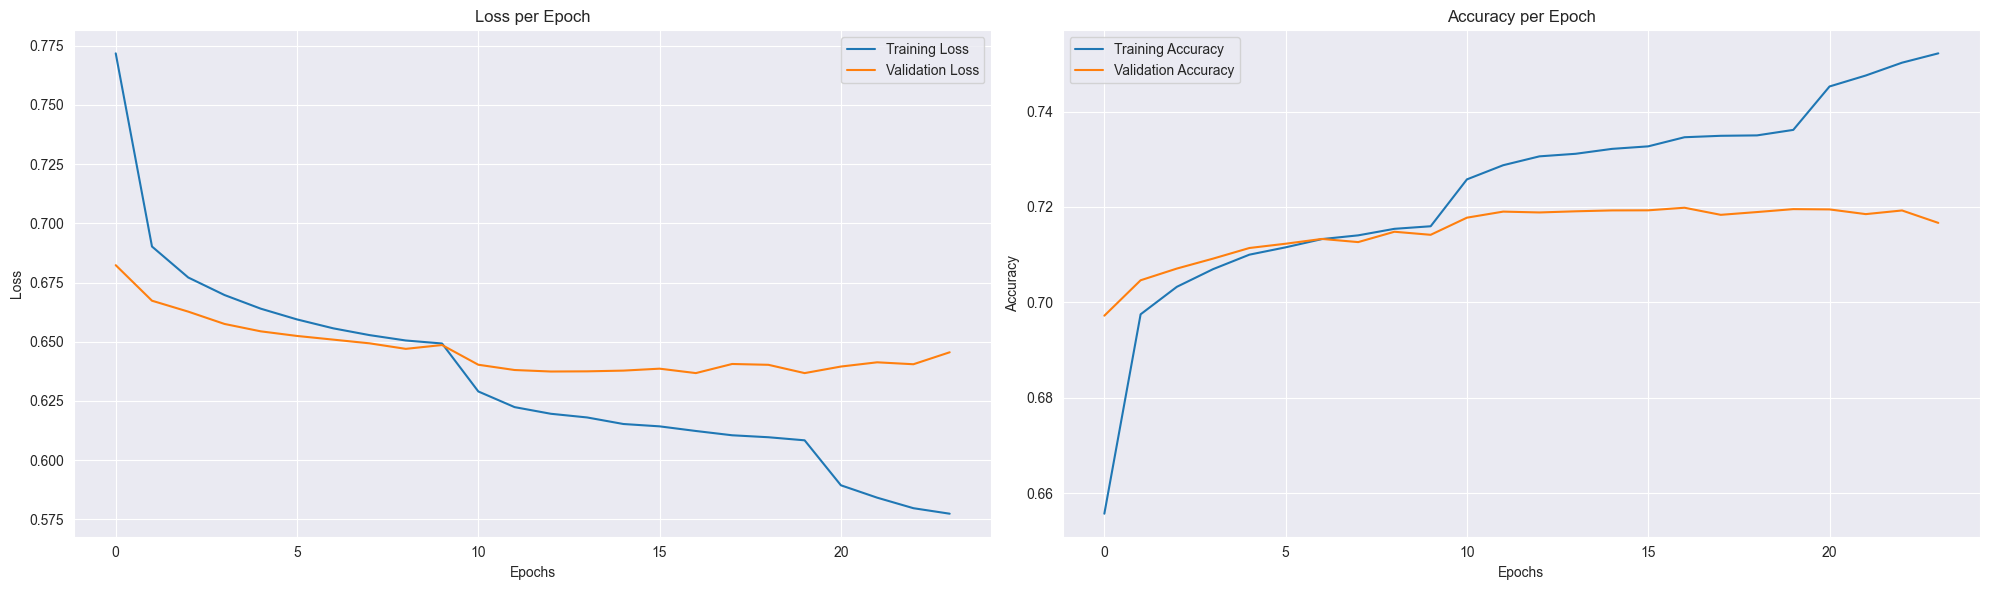

              precision    recall  f1-score   support

           0       0.67      0.72      0.69     28477
           1       0.89      0.76      0.82     79709
           2       0.48      0.58      0.52     23678
           3       0.73      0.83      0.77     33157

    accuracy                           0.74    165021
   macro avg       0.69      0.72      0.70    165021
weighted avg       0.76      0.74      0.74    165021

balanced accuracy 0.7195321731784954


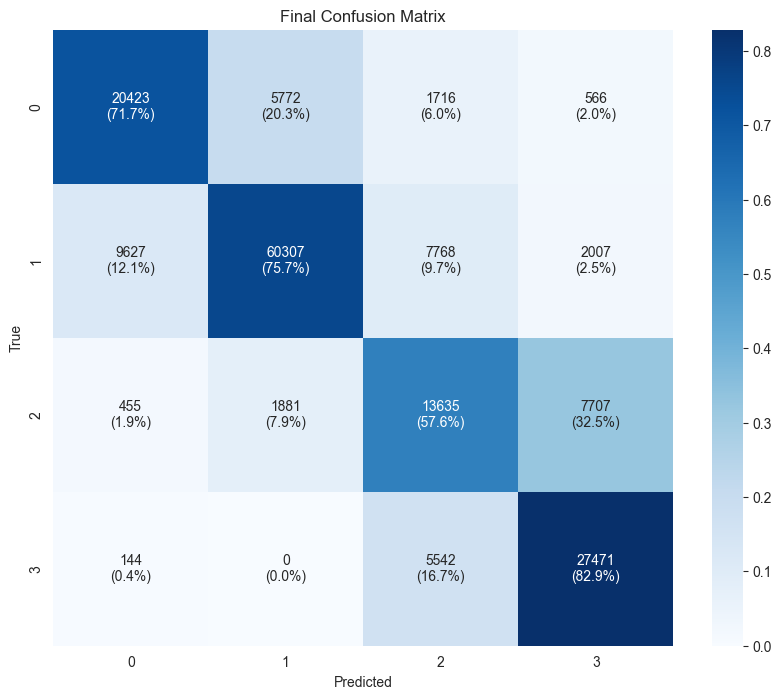

Testing with embeddings: products=32, users=64
Epoch 1 | Train Loss: 0.7738 | Valid Loss: 0.6782 | Train Accuracy: 0.6550 | Valid Accuracy: 0.6992
Epoch 2 | Train Loss: 0.6897 | Valid Loss: 0.6678 | Train Accuracy: 0.6978 | Valid Accuracy: 0.7030
Epoch 3 | Train Loss: 0.6792 | Valid Loss: 0.6639 | Train Accuracy: 0.7025 | Valid Accuracy: 0.7069
Epoch 4 | Train Loss: 0.6722 | Valid Loss: 0.6571 | Train Accuracy: 0.7053 | Valid Accuracy: 0.7083
Epoch 5 | Train Loss: 0.6658 | Valid Loss: 0.6527 | Train Accuracy: 0.7083 | Valid Accuracy: 0.7115
Epoch 6 | Train Loss: 0.6597 | Valid Loss: 0.6528 | Train Accuracy: 0.7111 | Valid Accuracy: 0.7105
Epoch 7 | Train Loss: 0.6557 | Valid Loss: 0.6493 | Train Accuracy: 0.7128 | Valid Accuracy: 0.7132
Epoch 8 | Train Loss: 0.6524 | Valid Loss: 0.6512 | Train Accuracy: 0.7147 | Valid Accuracy: 0.7112
Epoch 9 | Train Loss: 0.6504 | Valid Loss: 0.6482 | Train Accuracy: 0.7152 | Valid Accuracy: 0.7137
Epoch 10 | Train Loss: 0.6476 | Valid Loss: 0.6474 | 

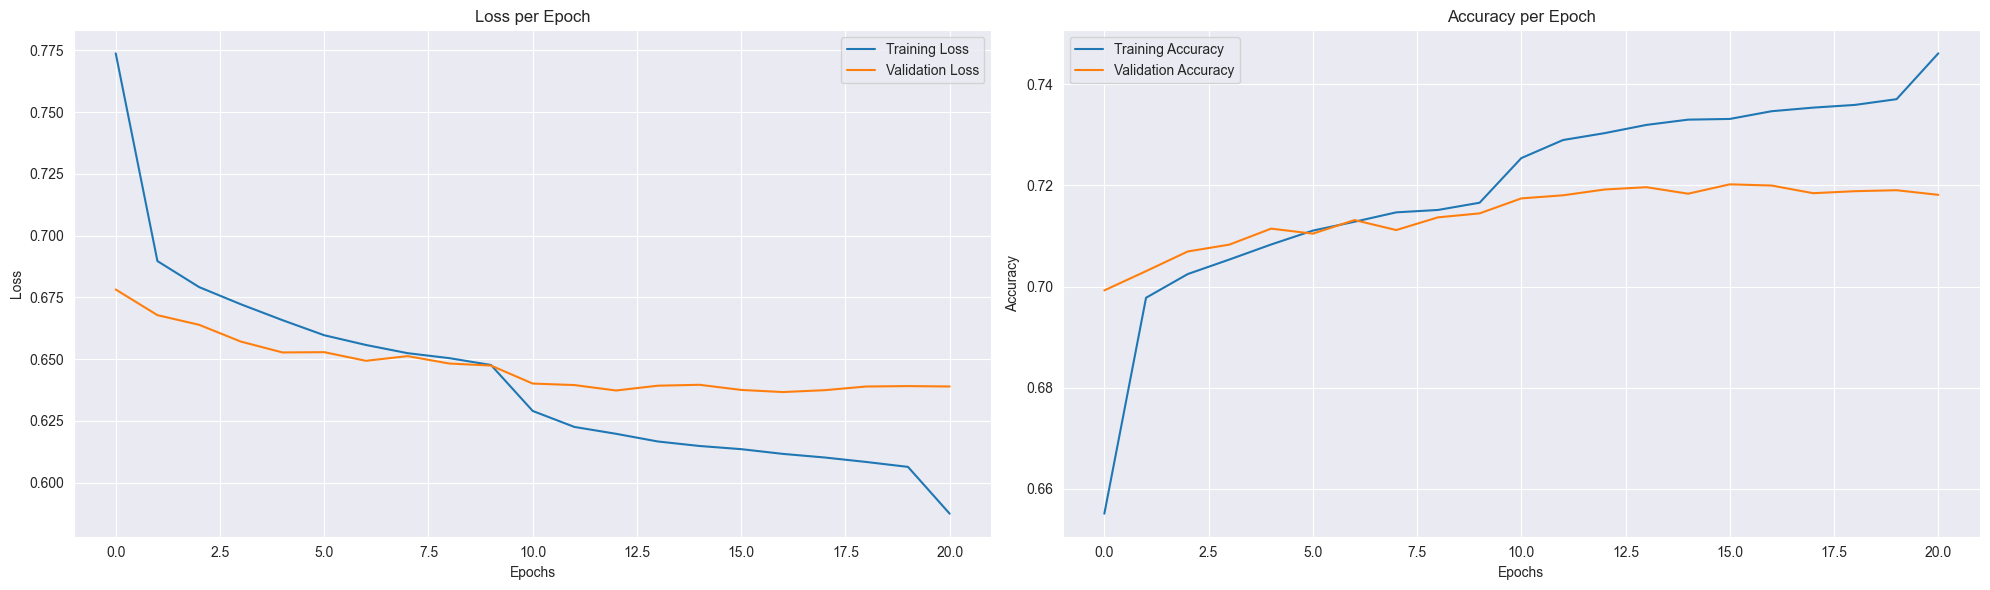

              precision    recall  f1-score   support

           0       0.67      0.71      0.69     28477
           1       0.89      0.76      0.82     79709
           2       0.48      0.59      0.53     23678
           3       0.73      0.82      0.77     33157

    accuracy                           0.74    165021
   macro avg       0.69      0.72      0.70    165021
weighted avg       0.76      0.74      0.74    165021

balanced accuracy 0.7199907369411594


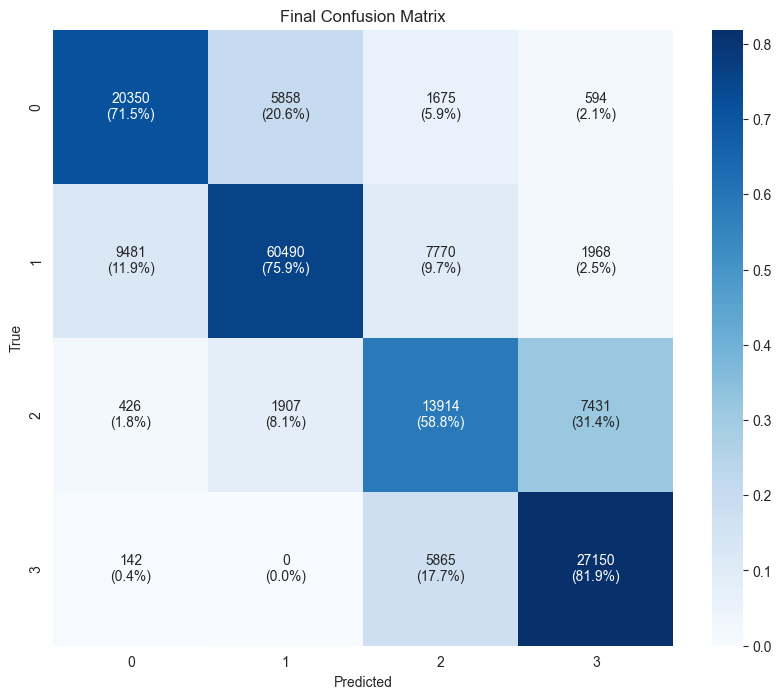

Testing with embeddings: products=32, users=128
Epoch 1 | Train Loss: 0.7733 | Valid Loss: 0.6818 | Train Accuracy: 0.6557 | Valid Accuracy: 0.6981
Epoch 2 | Train Loss: 0.6913 | Valid Loss: 0.6665 | Train Accuracy: 0.6966 | Valid Accuracy: 0.7049
Epoch 3 | Train Loss: 0.6802 | Valid Loss: 0.6601 | Train Accuracy: 0.7024 | Valid Accuracy: 0.7079
Epoch 4 | Train Loss: 0.6710 | Valid Loss: 0.6588 | Train Accuracy: 0.7072 | Valid Accuracy: 0.7085
Epoch 5 | Train Loss: 0.6655 | Valid Loss: 0.6574 | Train Accuracy: 0.7100 | Valid Accuracy: 0.7098
Epoch 6 | Train Loss: 0.6614 | Valid Loss: 0.6505 | Train Accuracy: 0.7114 | Valid Accuracy: 0.7131
Epoch 7 | Train Loss: 0.6576 | Valid Loss: 0.6515 | Train Accuracy: 0.7141 | Valid Accuracy: 0.7126
Epoch 8 | Train Loss: 0.6544 | Valid Loss: 0.6477 | Train Accuracy: 0.7145 | Valid Accuracy: 0.7139
Epoch 9 | Train Loss: 0.6513 | Valid Loss: 0.6463 | Train Accuracy: 0.7162 | Valid Accuracy: 0.7142
Epoch 10 | Train Loss: 0.6497 | Valid Loss: 0.6463 |

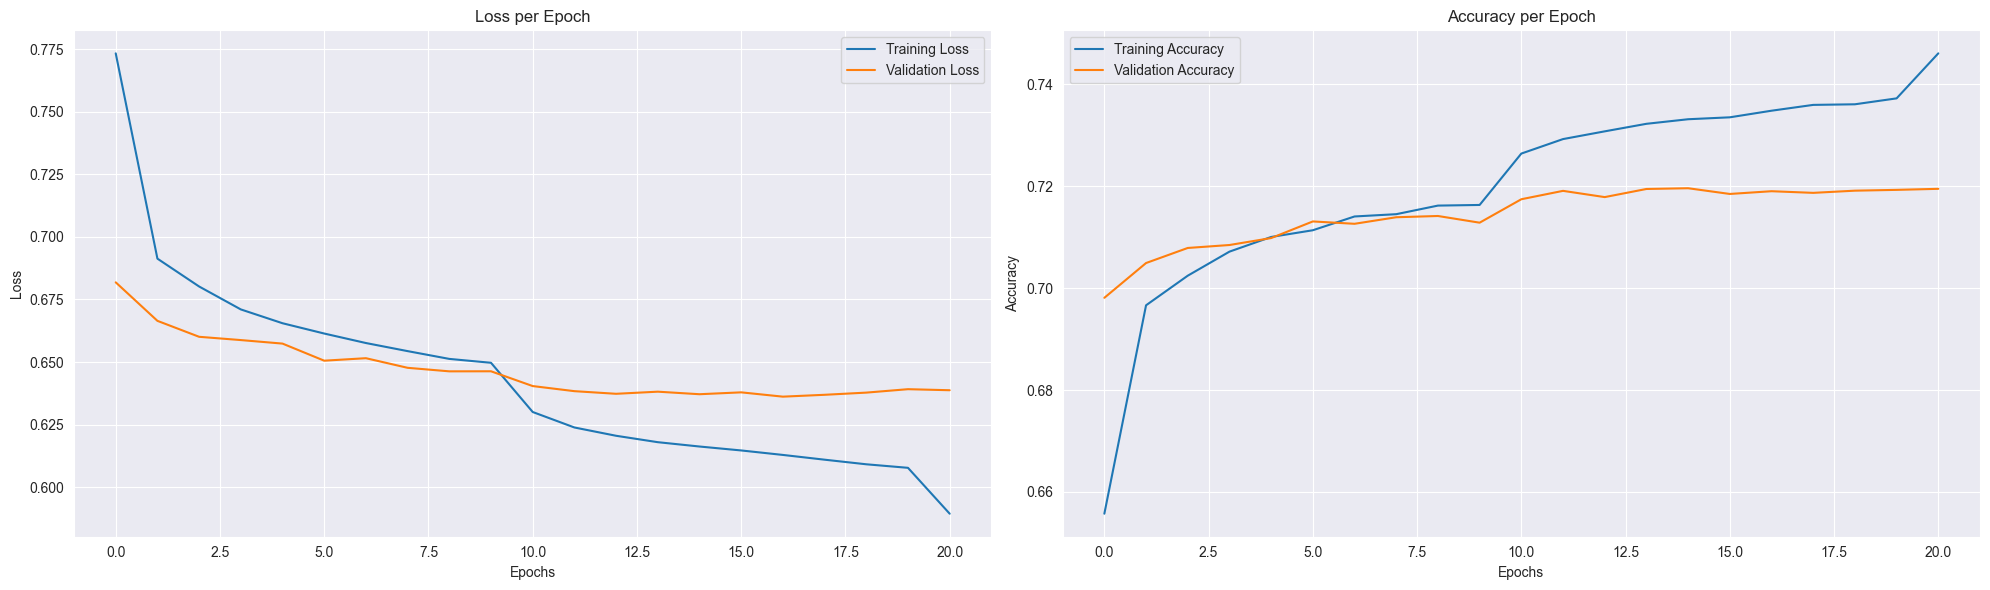

              precision    recall  f1-score   support

           0       0.65      0.73      0.69     28477
           1       0.89      0.75      0.81     79709
           2       0.47      0.61      0.53     23678
           3       0.74      0.79      0.77     33157

    accuracy                           0.73    165021
   macro avg       0.69      0.72      0.70    165021
weighted avg       0.76      0.73      0.74    165021

balanced accuracy 0.7190200367163198


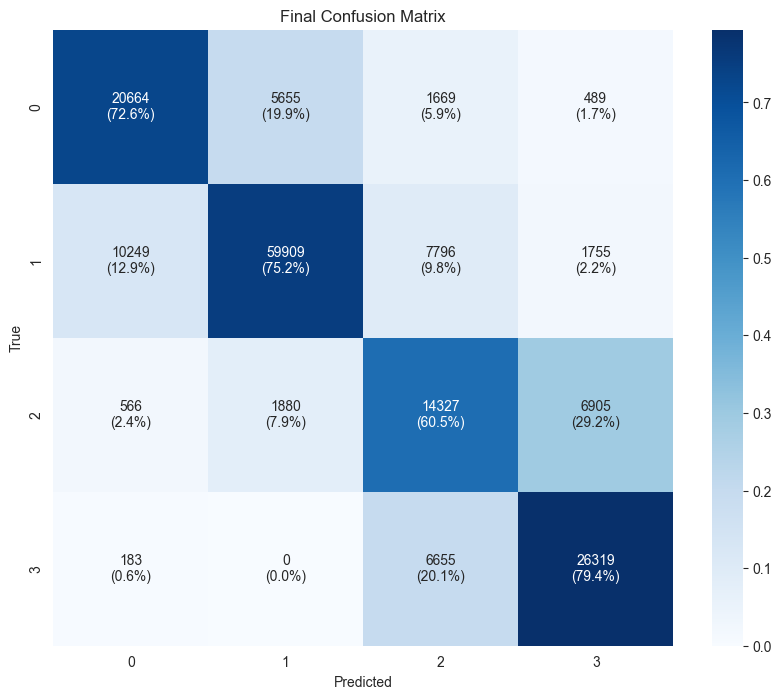

Testing with embeddings: products=64, users=32
Epoch 1 | Train Loss: 0.7691 | Valid Loss: 0.6890 | Train Accuracy: 0.6575 | Valid Accuracy: 0.6935
Epoch 2 | Train Loss: 0.6920 | Valid Loss: 0.6718 | Train Accuracy: 0.6969 | Valid Accuracy: 0.7038
Epoch 3 | Train Loss: 0.6789 | Valid Loss: 0.6618 | Train Accuracy: 0.7030 | Valid Accuracy: 0.7063
Epoch 4 | Train Loss: 0.6705 | Valid Loss: 0.6587 | Train Accuracy: 0.7066 | Valid Accuracy: 0.7090
Epoch 5 | Train Loss: 0.6651 | Valid Loss: 0.6544 | Train Accuracy: 0.7093 | Valid Accuracy: 0.7112
Epoch 6 | Train Loss: 0.6599 | Valid Loss: 0.6529 | Train Accuracy: 0.7121 | Valid Accuracy: 0.7118
Epoch 7 | Train Loss: 0.6562 | Valid Loss: 0.6504 | Train Accuracy: 0.7130 | Valid Accuracy: 0.7142
Epoch 8 | Train Loss: 0.6533 | Valid Loss: 0.6477 | Train Accuracy: 0.7149 | Valid Accuracy: 0.7134
Epoch 9 | Train Loss: 0.6508 | Valid Loss: 0.6459 | Train Accuracy: 0.7164 | Valid Accuracy: 0.7144
Epoch 10 | Train Loss: 0.6486 | Valid Loss: 0.6474 | 

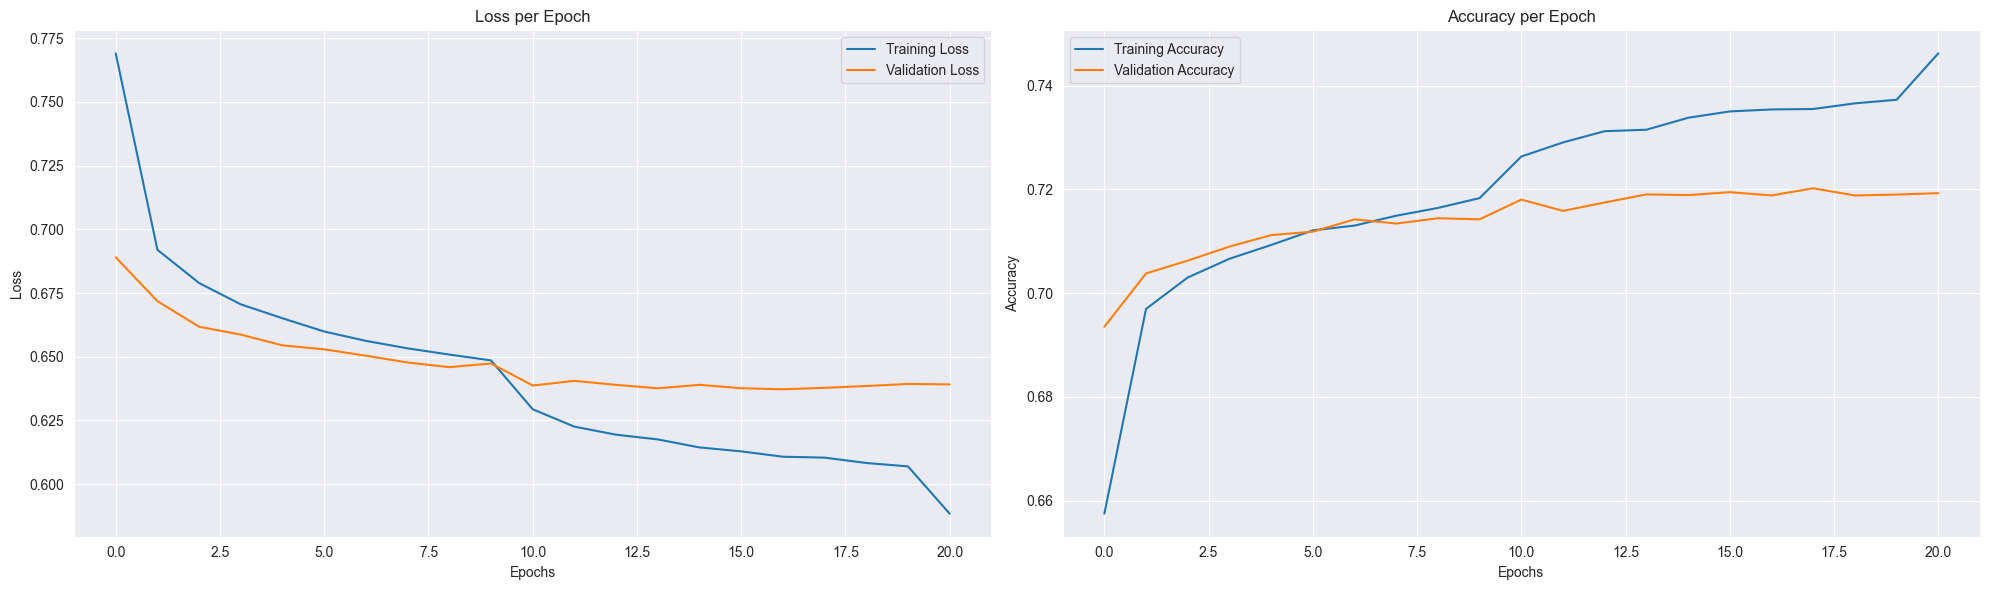

              precision    recall  f1-score   support

           0       0.67      0.71      0.69     28477
           1       0.89      0.76      0.82     79709
           2       0.47      0.62      0.53     23678
           3       0.75      0.78      0.76     33157

    accuracy                           0.74    165021
   macro avg       0.69      0.72      0.70    165021
weighted avg       0.76      0.74      0.74    165021

balanced accuracy 0.718823278950004


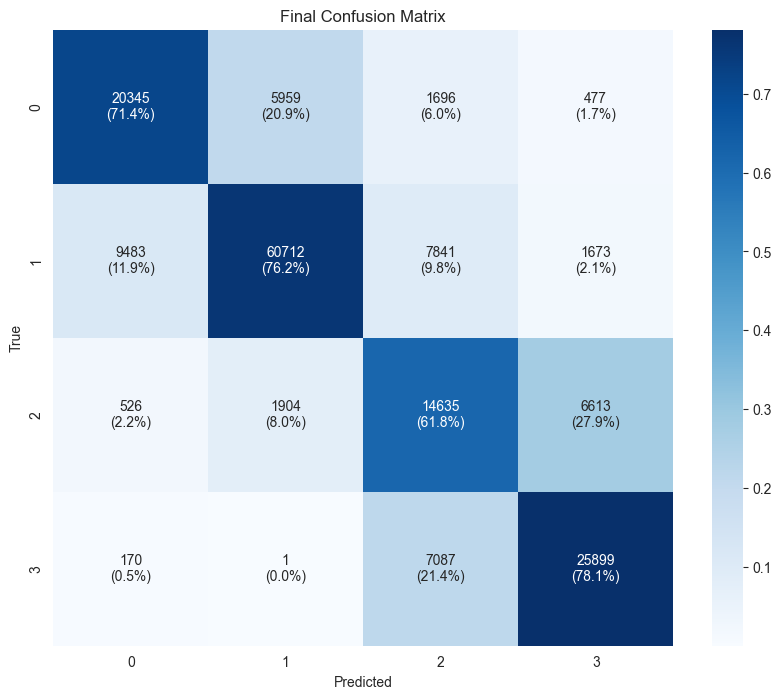

Testing with embeddings: products=64, users=64
Epoch 1 | Train Loss: 0.7678 | Valid Loss: 0.6822 | Train Accuracy: 0.6575 | Valid Accuracy: 0.6975
Epoch 2 | Train Loss: 0.6915 | Valid Loss: 0.6679 | Train Accuracy: 0.6965 | Valid Accuracy: 0.7042
Epoch 3 | Train Loss: 0.6788 | Valid Loss: 0.6616 | Train Accuracy: 0.7024 | Valid Accuracy: 0.7075
Epoch 4 | Train Loss: 0.6725 | Valid Loss: 0.6602 | Train Accuracy: 0.7058 | Valid Accuracy: 0.7073
Epoch 5 | Train Loss: 0.6671 | Valid Loss: 0.6568 | Train Accuracy: 0.7081 | Valid Accuracy: 0.7099
Epoch 6 | Train Loss: 0.6617 | Valid Loss: 0.6530 | Train Accuracy: 0.7105 | Valid Accuracy: 0.7105
Epoch 7 | Train Loss: 0.6576 | Valid Loss: 0.6517 | Train Accuracy: 0.7128 | Valid Accuracy: 0.7123
Epoch 8 | Train Loss: 0.6543 | Valid Loss: 0.6491 | Train Accuracy: 0.7140 | Valid Accuracy: 0.7140
Epoch 9 | Train Loss: 0.6515 | Valid Loss: 0.6486 | Train Accuracy: 0.7156 | Valid Accuracy: 0.7137
Epoch 10 | Train Loss: 0.6490 | Valid Loss: 0.6458 | 

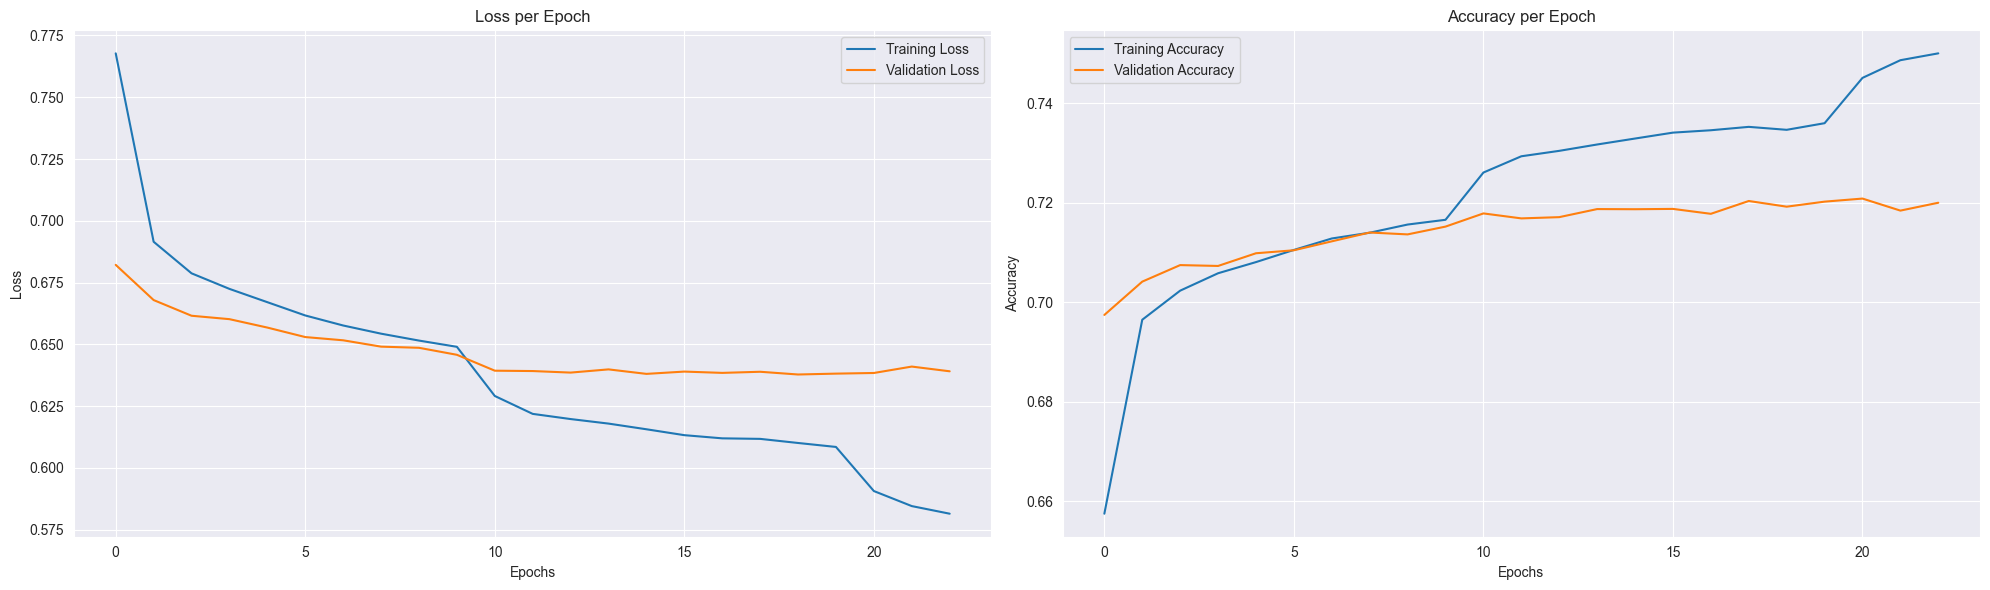

              precision    recall  f1-score   support

           0       0.64      0.73      0.69     28477
           1       0.89      0.74      0.81     79709
           2       0.47      0.58      0.52     23678
           3       0.73      0.82      0.77     33157

    accuracy                           0.73    165021
   macro avg       0.69      0.72      0.70    165021
weighted avg       0.76      0.73      0.74    165021

balanced accuracy 0.7192226647287316


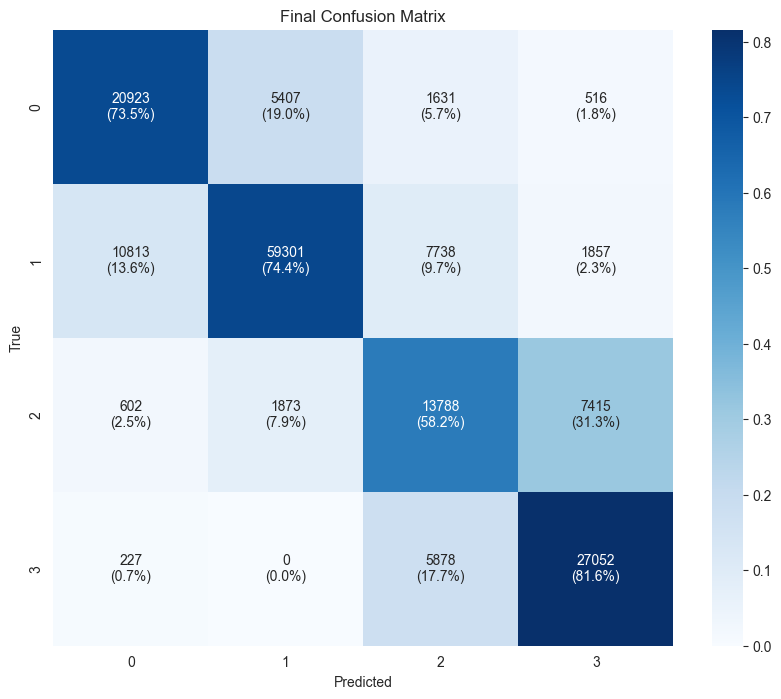

Testing with embeddings: products=64, users=128
Epoch 1 | Train Loss: 0.7686 | Valid Loss: 0.6805 | Train Accuracy: 0.6563 | Valid Accuracy: 0.6975
Epoch 2 | Train Loss: 0.6902 | Valid Loss: 0.6684 | Train Accuracy: 0.6962 | Valid Accuracy: 0.7046
Epoch 3 | Train Loss: 0.6795 | Valid Loss: 0.6614 | Train Accuracy: 0.7021 | Valid Accuracy: 0.7070
Epoch 4 | Train Loss: 0.6706 | Valid Loss: 0.6605 | Train Accuracy: 0.7062 | Valid Accuracy: 0.7082
Epoch 5 | Train Loss: 0.6655 | Valid Loss: 0.6551 | Train Accuracy: 0.7093 | Valid Accuracy: 0.7103
Epoch 6 | Train Loss: 0.6619 | Valid Loss: 0.6525 | Train Accuracy: 0.7104 | Valid Accuracy: 0.7119
Epoch 7 | Train Loss: 0.6577 | Valid Loss: 0.6525 | Train Accuracy: 0.7128 | Valid Accuracy: 0.7124
Epoch 8 | Train Loss: 0.6539 | Valid Loss: 0.6503 | Train Accuracy: 0.7137 | Valid Accuracy: 0.7121
Epoch 9 | Train Loss: 0.6520 | Valid Loss: 0.6481 | Train Accuracy: 0.7156 | Valid Accuracy: 0.7126
Epoch 10 | Train Loss: 0.6508 | Valid Loss: 0.6473 |

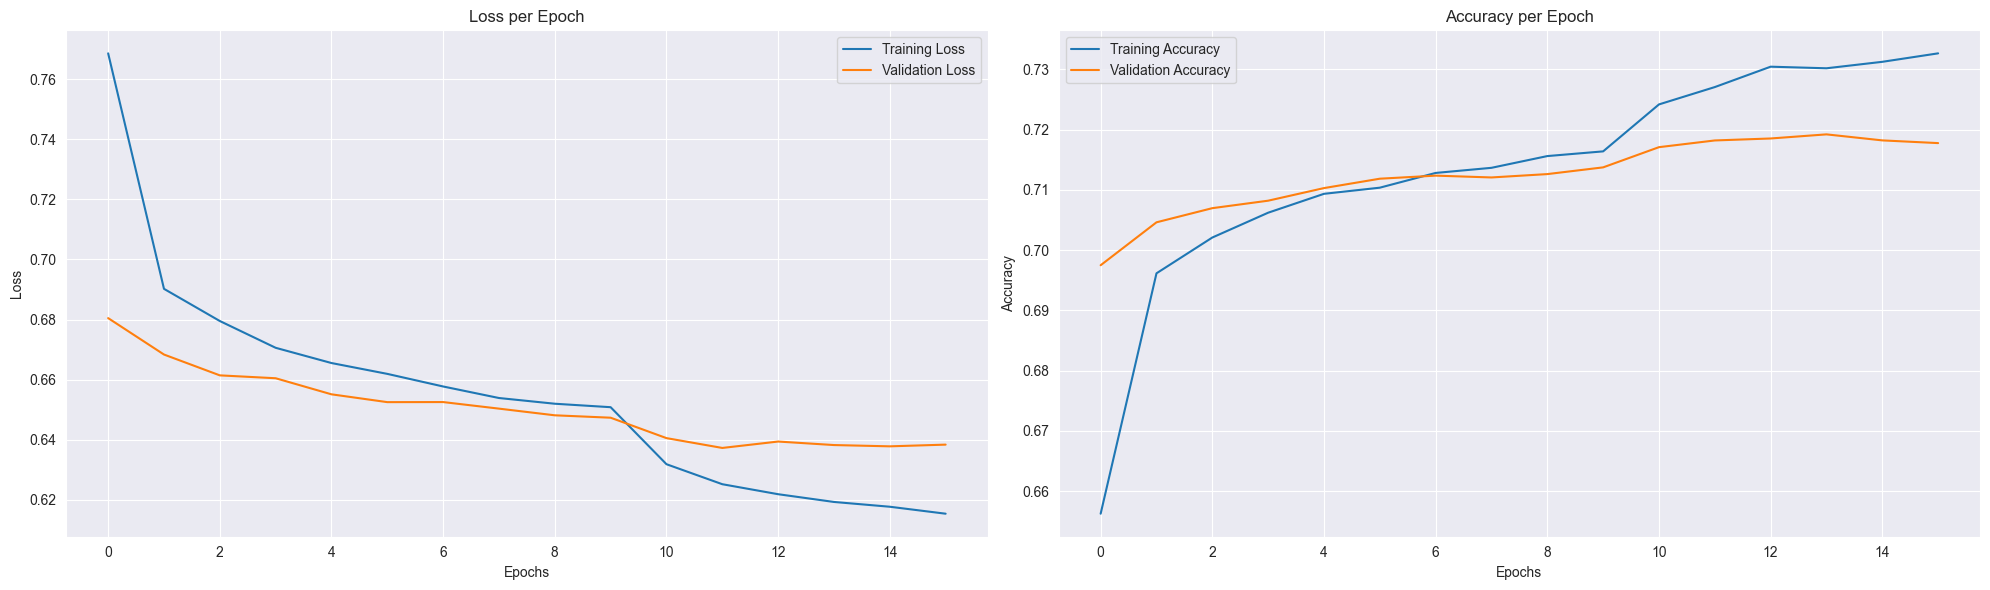

              precision    recall  f1-score   support

           0       0.65      0.72      0.68     28477
           1       0.89      0.75      0.81     79709
           2       0.47      0.58      0.52     23678
           3       0.73      0.82      0.77     33157

    accuracy                           0.73    165021
   macro avg       0.69      0.72      0.70    165021
weighted avg       0.76      0.73      0.74    165021

balanced accuracy 0.7182008455415846


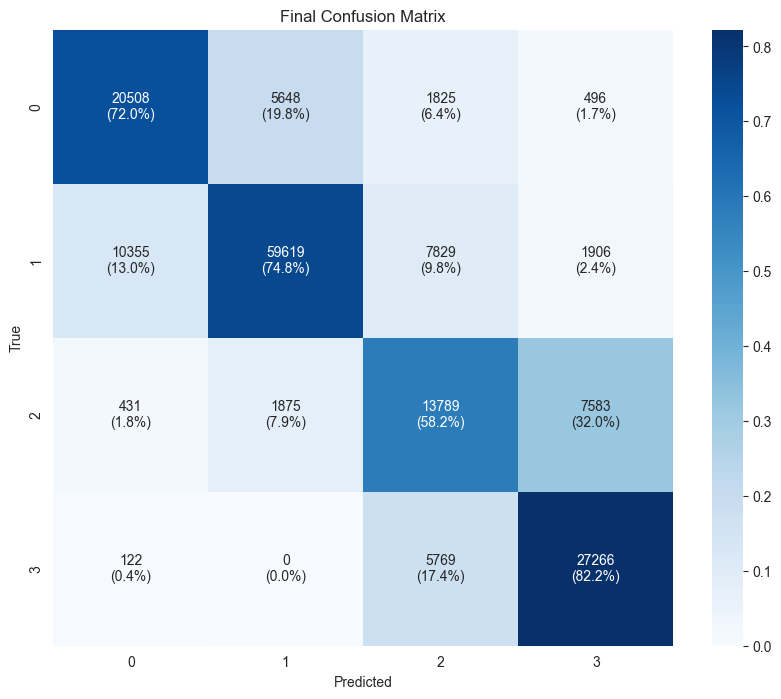

Testing with embeddings: products=128, users=32
Epoch 1 | Train Loss: 0.7682 | Valid Loss: 0.6843 | Train Accuracy: 0.6582 | Valid Accuracy: 0.6954
Epoch 2 | Train Loss: 0.6933 | Valid Loss: 0.6740 | Train Accuracy: 0.6954 | Valid Accuracy: 0.7025
Epoch 3 | Train Loss: 0.6789 | Valid Loss: 0.6647 | Train Accuracy: 0.7029 | Valid Accuracy: 0.7057
Epoch 4 | Train Loss: 0.6711 | Valid Loss: 0.6580 | Train Accuracy: 0.7070 | Valid Accuracy: 0.7098
Epoch 5 | Train Loss: 0.6653 | Valid Loss: 0.6551 | Train Accuracy: 0.7092 | Valid Accuracy: 0.7094
Epoch 6 | Train Loss: 0.6607 | Valid Loss: 0.6513 | Train Accuracy: 0.7117 | Valid Accuracy: 0.7116
Epoch 7 | Train Loss: 0.6559 | Valid Loss: 0.6498 | Train Accuracy: 0.7134 | Valid Accuracy: 0.7132
Epoch 8 | Train Loss: 0.6538 | Valid Loss: 0.6482 | Train Accuracy: 0.7143 | Valid Accuracy: 0.7120
Epoch 9 | Train Loss: 0.6513 | Valid Loss: 0.6465 | Train Accuracy: 0.7153 | Valid Accuracy: 0.7146
Epoch 10 | Train Loss: 0.6490 | Valid Loss: 0.6511 |

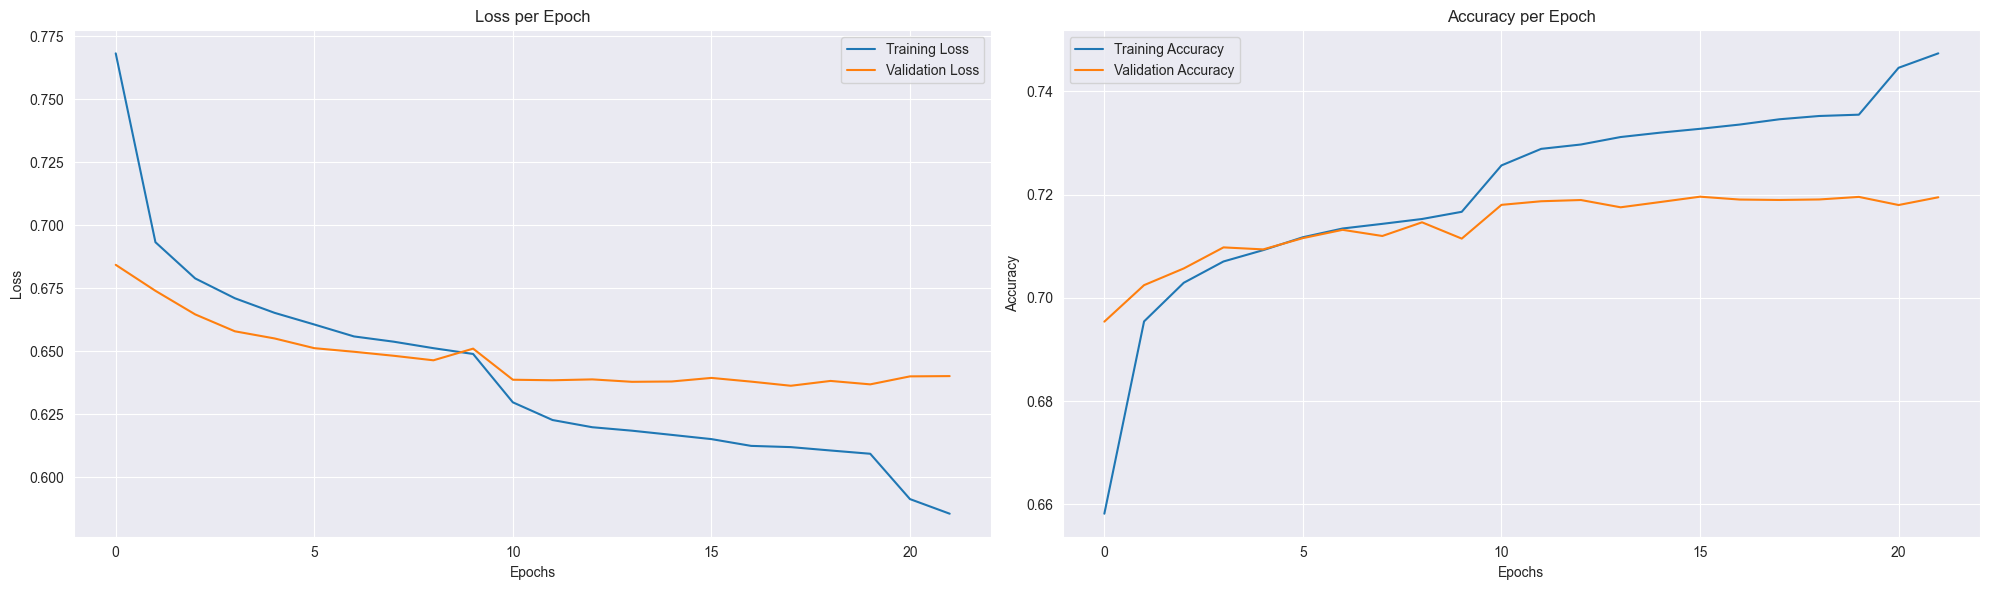

              precision    recall  f1-score   support

           0       0.63      0.74      0.68     28477
           1       0.89      0.74      0.81     79709
           2       0.47      0.62      0.53     23678
           3       0.75      0.77      0.76     33157

    accuracy                           0.73    165021
   macro avg       0.69      0.72      0.70    165021
weighted avg       0.76      0.73      0.74    165021

balanced accuracy 0.7189557917868918


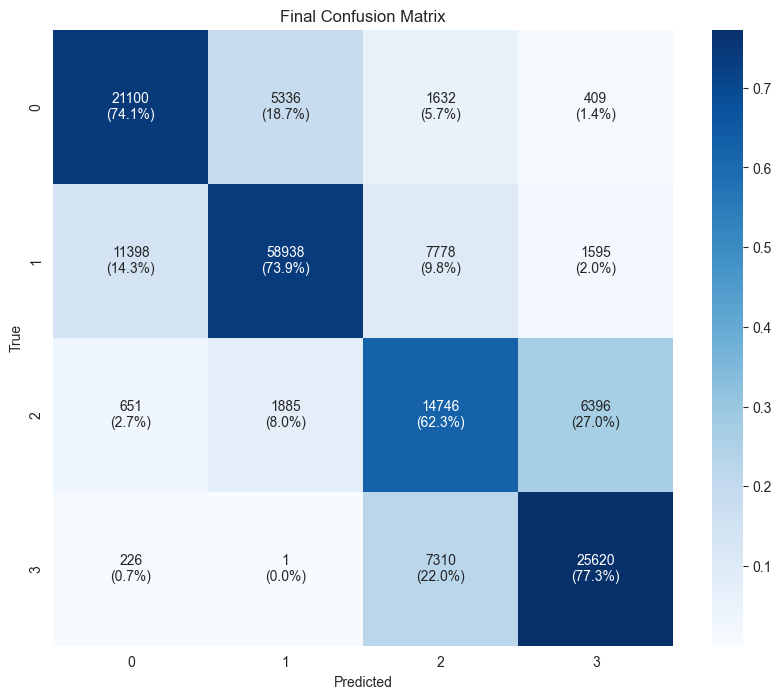

Testing with embeddings: products=128, users=64
Epoch 1 | Train Loss: 0.7669 | Valid Loss: 0.6819 | Train Accuracy: 0.6586 | Valid Accuracy: 0.6960
Epoch 2 | Train Loss: 0.6917 | Valid Loss: 0.6726 | Train Accuracy: 0.6968 | Valid Accuracy: 0.7019
Epoch 3 | Train Loss: 0.6793 | Valid Loss: 0.6641 | Train Accuracy: 0.7024 | Valid Accuracy: 0.7048
Epoch 4 | Train Loss: 0.6707 | Valid Loss: 0.6601 | Train Accuracy: 0.7063 | Valid Accuracy: 0.7072
Epoch 5 | Train Loss: 0.6657 | Valid Loss: 0.6559 | Train Accuracy: 0.7090 | Valid Accuracy: 0.7093
Epoch 6 | Train Loss: 0.6607 | Valid Loss: 0.6546 | Train Accuracy: 0.7115 | Valid Accuracy: 0.7102
Epoch 7 | Train Loss: 0.6571 | Valid Loss: 0.6512 | Train Accuracy: 0.7124 | Valid Accuracy: 0.7133
Epoch 8 | Train Loss: 0.6534 | Valid Loss: 0.6477 | Train Accuracy: 0.7147 | Valid Accuracy: 0.7134
Epoch 9 | Train Loss: 0.6506 | Valid Loss: 0.6484 | Train Accuracy: 0.7166 | Valid Accuracy: 0.7138
Epoch 10 | Train Loss: 0.6479 | Valid Loss: 0.6507 |

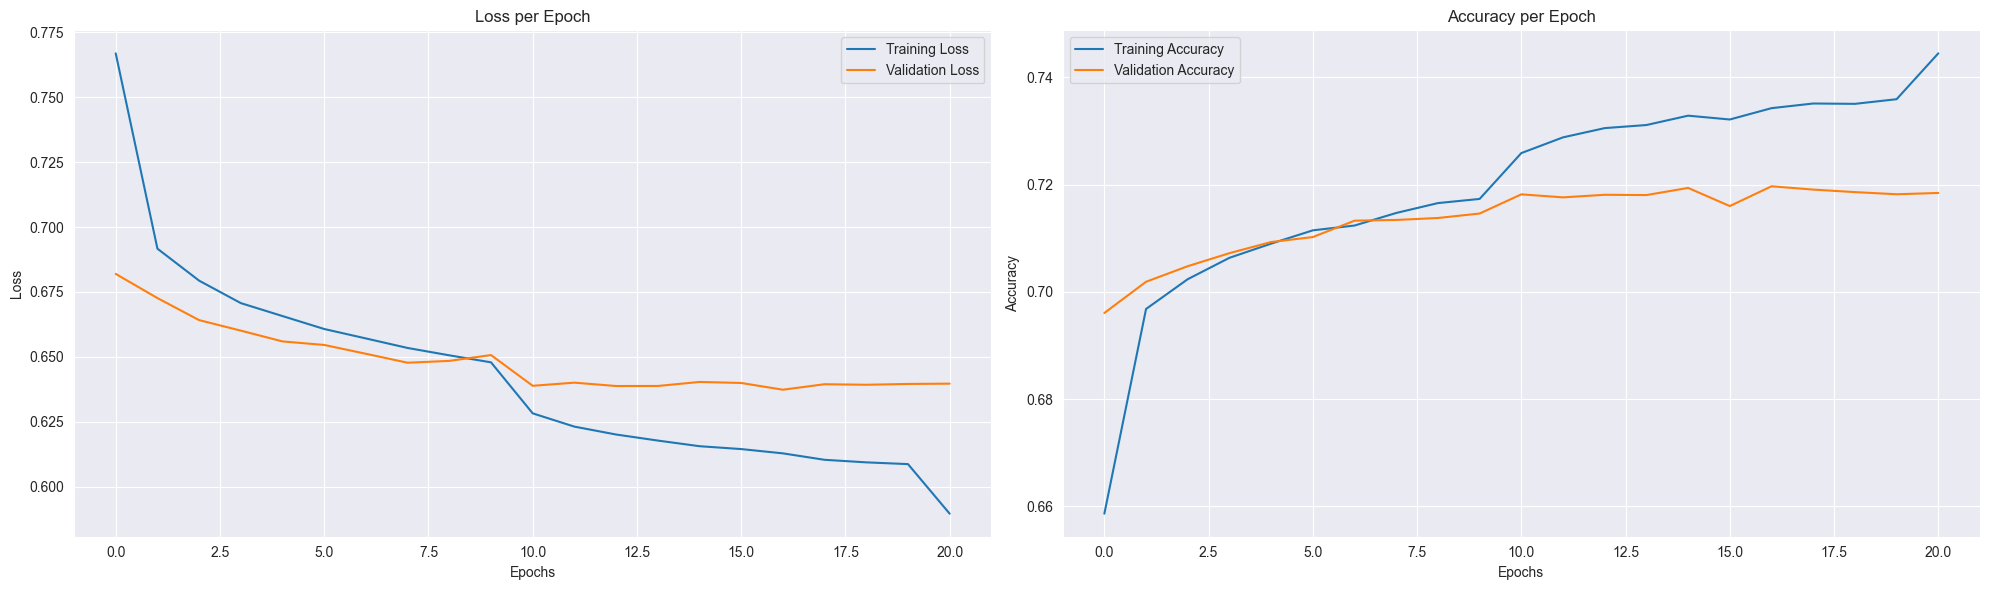

              precision    recall  f1-score   support

           0       0.68      0.70      0.69     28477
           1       0.88      0.77      0.82     79709
           2       0.47      0.60      0.53     23678
           3       0.74      0.80      0.77     33157

    accuracy                           0.74    165021
   macro avg       0.69      0.72      0.70    165021
weighted avg       0.76      0.74      0.75    165021

balanced accuracy 0.7196863741032709


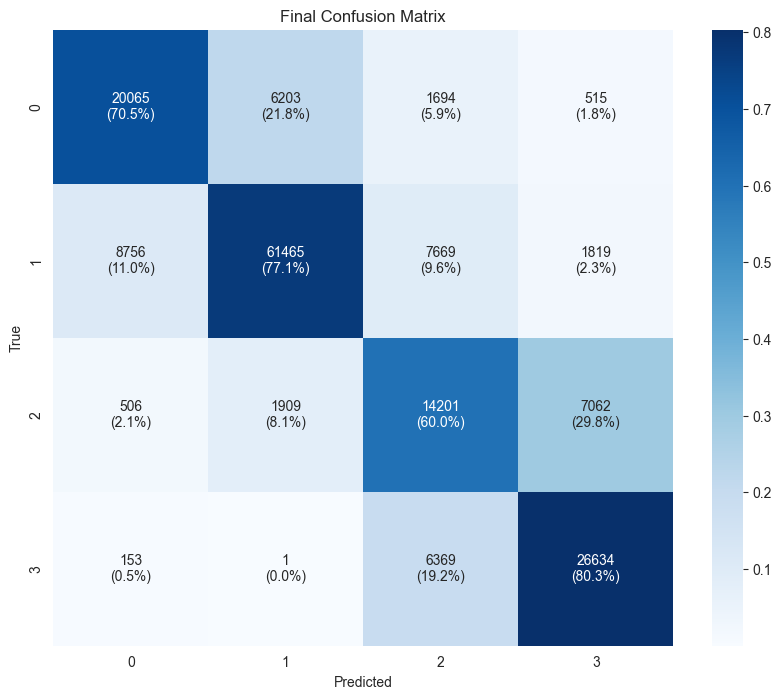

Testing with embeddings: products=128, users=128
Epoch 1 | Train Loss: 0.7662 | Valid Loss: 0.6848 | Train Accuracy: 0.6588 | Valid Accuracy: 0.6970
Epoch 2 | Train Loss: 0.6932 | Valid Loss: 0.6715 | Train Accuracy: 0.6959 | Valid Accuracy: 0.7042
Epoch 3 | Train Loss: 0.6802 | Valid Loss: 0.6638 | Train Accuracy: 0.7020 | Valid Accuracy: 0.7051
Epoch 4 | Train Loss: 0.6723 | Valid Loss: 0.6568 | Train Accuracy: 0.7060 | Valid Accuracy: 0.7093
Epoch 5 | Train Loss: 0.6659 | Valid Loss: 0.6566 | Train Accuracy: 0.7092 | Valid Accuracy: 0.7098
Epoch 6 | Train Loss: 0.6614 | Valid Loss: 0.6544 | Train Accuracy: 0.7106 | Valid Accuracy: 0.7118
Epoch 7 | Train Loss: 0.6582 | Valid Loss: 0.6518 | Train Accuracy: 0.7125 | Valid Accuracy: 0.7125
Epoch 8 | Train Loss: 0.6555 | Valid Loss: 0.6494 | Train Accuracy: 0.7134 | Valid Accuracy: 0.7126
Epoch 9 | Train Loss: 0.6535 | Valid Loss: 0.6490 | Train Accuracy: 0.7149 | Valid Accuracy: 0.7124
Epoch 10 | Train Loss: 0.6504 | Valid Loss: 0.6489 

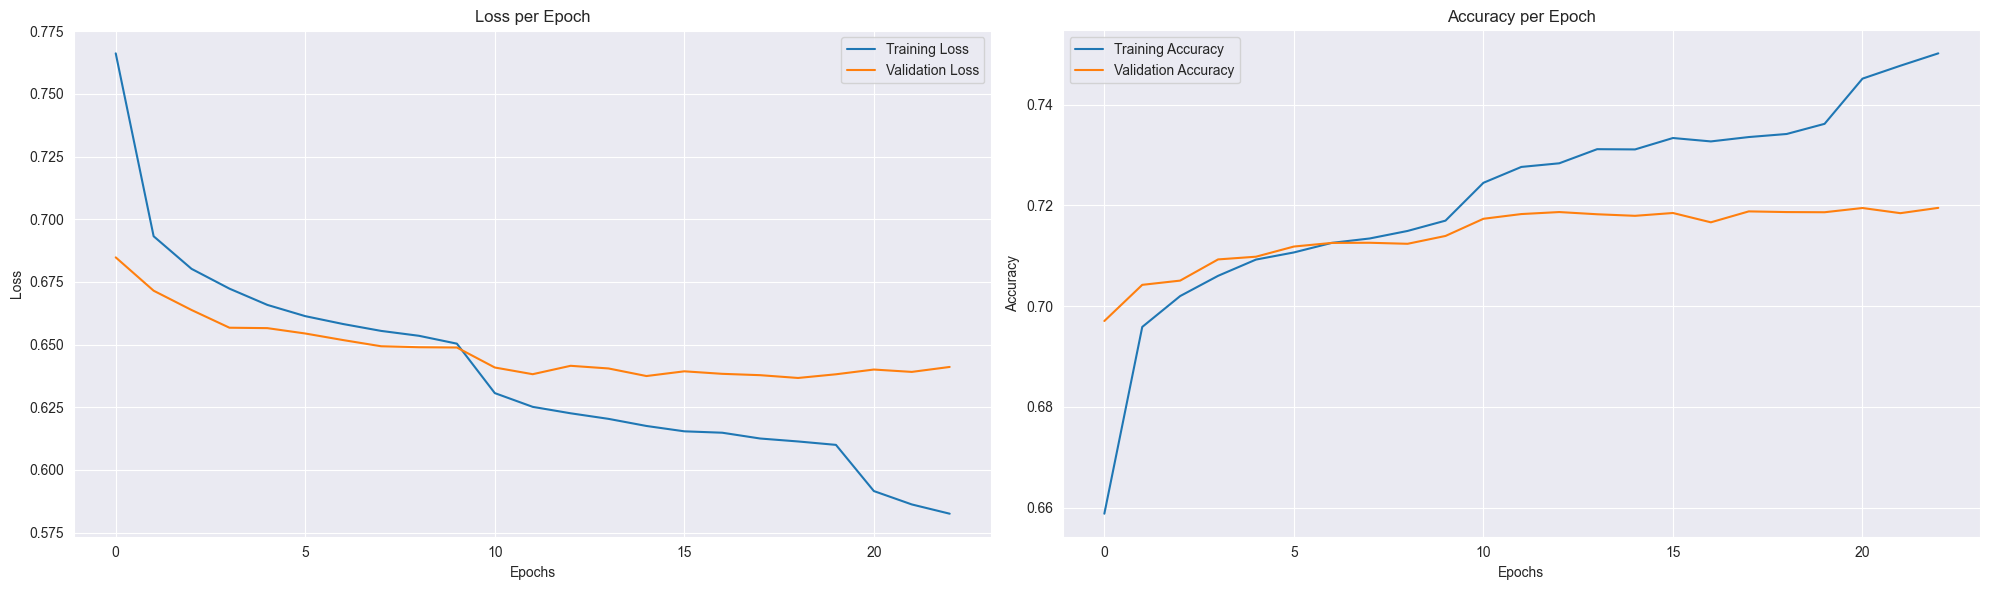

              precision    recall  f1-score   support

           0       0.61      0.76      0.68     28477
           1       0.90      0.72      0.80     79709
           2       0.47      0.62      0.53     23678
           3       0.75      0.78      0.76     33157

    accuracy                           0.72    165021
   macro avg       0.68      0.72      0.69    165021
weighted avg       0.76      0.72      0.73    165021

balanced accuracy 0.7186590282054449


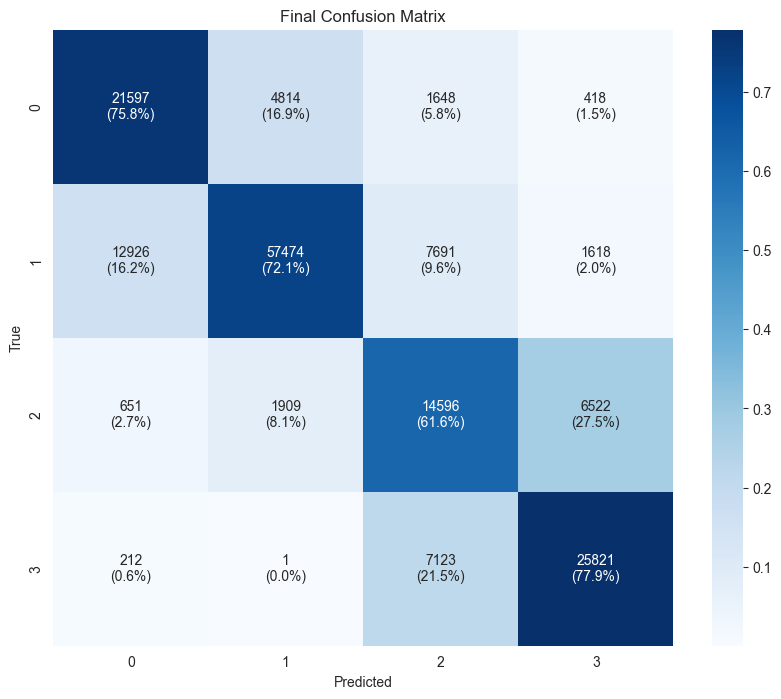

In [ ]:
from itertools import product

embedding_sizes = [32, 64, 128]
results = []

for embedding_dim_products, embedding_dim_users in product(embedding_sizes, embedding_sizes):
    nnet = NNetWithEmbedding(
        num_features=X.shape[1],
        num_products=len(le_products.classes_),
        num_users=len(le_users.classes_),
        embedding_dim_products=embedding_dim_products,
        embedding_dim_users=embedding_dim_users,
    ).to(device)

    optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    print(f"Testing with embeddings: products={embedding_dim_products}, users={embedding_dim_users}")
    result = train_model(
        nnet=nnet,
        train_dl=train_dl,
        test_dl=test_dl,
        loss_function=loss_function,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=50,
        patience=5,
    )
    results.append((embedding_dim_products, embedding_dim_users, result))


Testing with learning rate: 0.0001
Epoch 1 | Train Loss: 0.9918 | Valid Loss: 0.7810 | Train Accuracy: 0.5414 | Valid Accuracy: 0.6452
Epoch 2 | Train Loss: 0.7866 | Valid Loss: 0.7353 | Train Accuracy: 0.6497 | Valid Accuracy: 0.6682
Epoch 3 | Train Loss: 0.7430 | Valid Loss: 0.7072 | Train Accuracy: 0.6703 | Valid Accuracy: 0.6822
Epoch 4 | Train Loss: 0.7133 | Valid Loss: 0.6861 | Train Accuracy: 0.6846 | Valid Accuracy: 0.6946
Epoch 5 | Train Loss: 0.6891 | Valid Loss: 0.6710 | Train Accuracy: 0.6979 | Valid Accuracy: 0.7028
Epoch 6 | Train Loss: 0.6719 | Valid Loss: 0.6606 | Train Accuracy: 0.7073 | Valid Accuracy: 0.7090
Epoch 7 | Train Loss: 0.6607 | Valid Loss: 0.6556 | Train Accuracy: 0.7123 | Valid Accuracy: 0.7101
Epoch 8 | Train Loss: 0.6527 | Valid Loss: 0.6512 | Train Accuracy: 0.7173 | Valid Accuracy: 0.7122
Epoch 9 | Train Loss: 0.6456 | Valid Loss: 0.6486 | Train Accuracy: 0.7197 | Valid Accuracy: 0.7132
Epoch 10 | Train Loss: 0.6404 | Valid Loss: 0.6489 | Train Accura

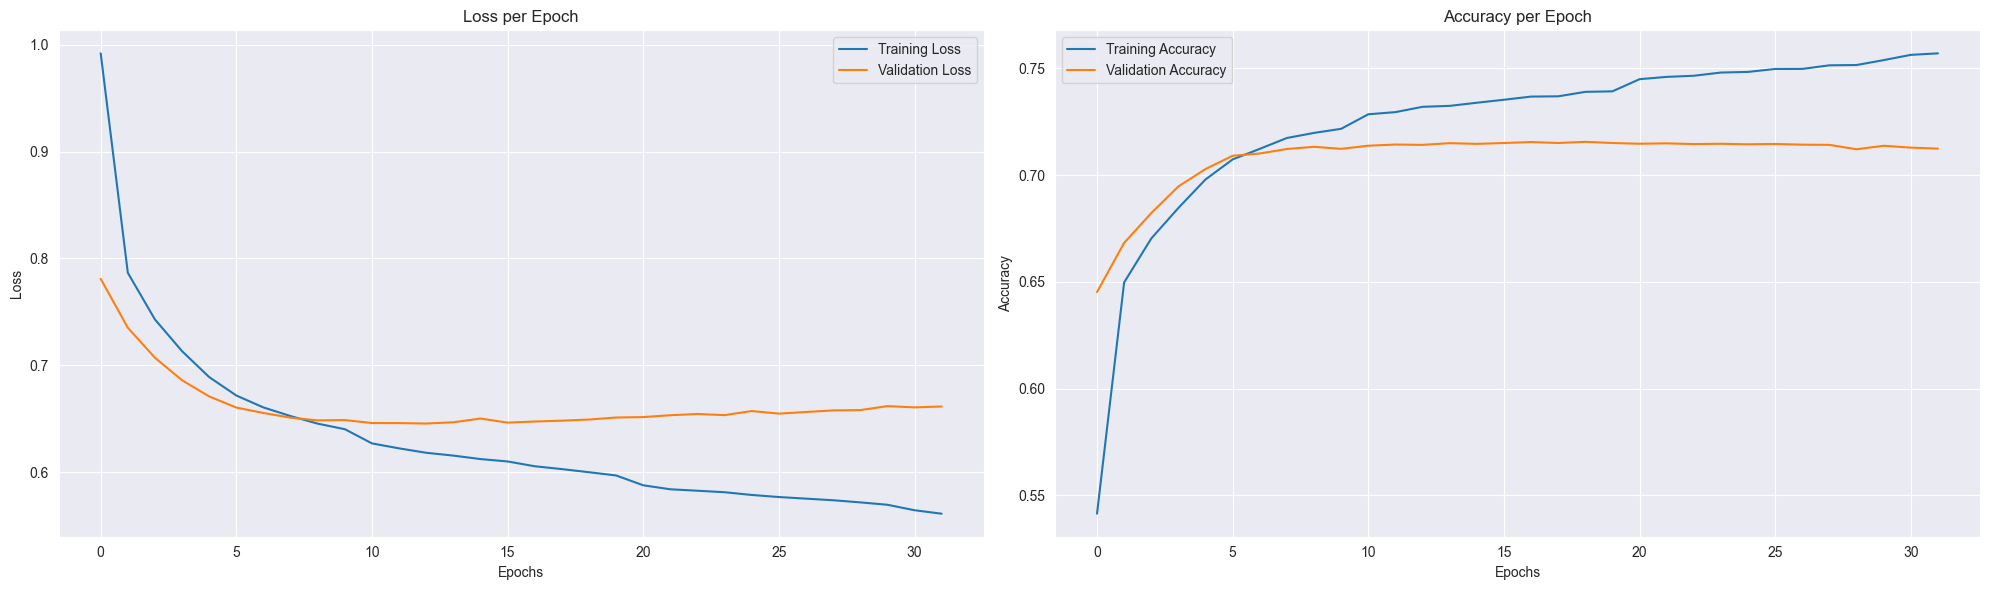

              precision    recall  f1-score   support

           0       0.63      0.73      0.68     28477
           1       0.89      0.75      0.81     79709
           2       0.47      0.60      0.53     23678
           3       0.74      0.78      0.76     33157

    accuracy                           0.73    165021
   macro avg       0.68      0.71      0.69    165021
weighted avg       0.75      0.73      0.74    165021

balanced accuracy 0.7141255518099232


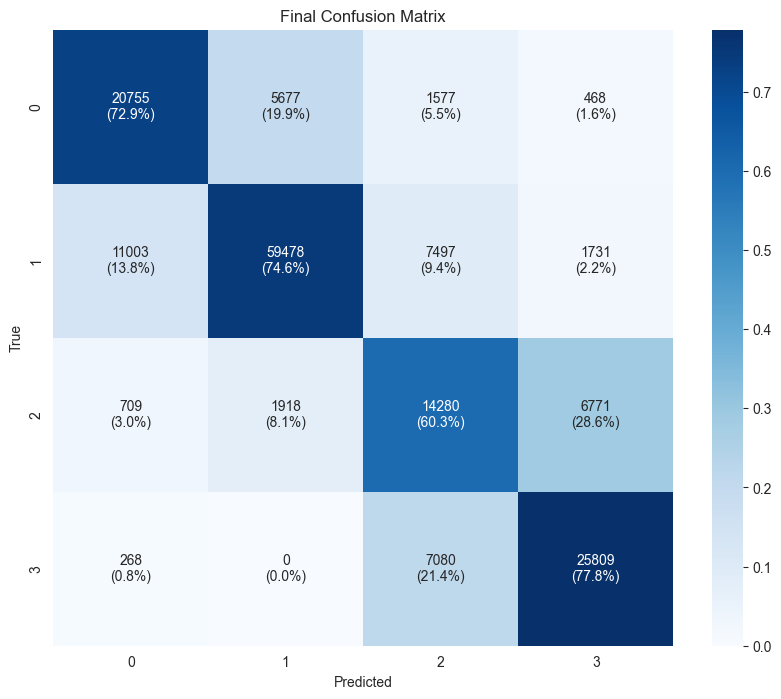

Testing with learning rate: 0.00015
Epoch 1 | Train Loss: 0.9340 | Valid Loss: 0.7576 | Train Accuracy: 0.5739 | Valid Accuracy: 0.6577
Epoch 2 | Train Loss: 0.7590 | Valid Loss: 0.7131 | Train Accuracy: 0.6611 | Valid Accuracy: 0.6791
Epoch 3 | Train Loss: 0.7144 | Valid Loss: 0.6813 | Train Accuracy: 0.6832 | Valid Accuracy: 0.6985
Epoch 4 | Train Loss: 0.6840 | Valid Loss: 0.6628 | Train Accuracy: 0.7001 | Valid Accuracy: 0.7061
Epoch 5 | Train Loss: 0.6668 | Valid Loss: 0.6568 | Train Accuracy: 0.7095 | Valid Accuracy: 0.7087
Epoch 6 | Train Loss: 0.6560 | Valid Loss: 0.6518 | Train Accuracy: 0.7149 | Valid Accuracy: 0.7117
Epoch 7 | Train Loss: 0.6481 | Valid Loss: 0.6502 | Train Accuracy: 0.7180 | Valid Accuracy: 0.7123
Epoch 8 | Train Loss: 0.6404 | Valid Loss: 0.6474 | Train Accuracy: 0.7215 | Valid Accuracy: 0.7132
Epoch 9 | Train Loss: 0.6351 | Valid Loss: 0.6463 | Train Accuracy: 0.7223 | Valid Accuracy: 0.7139
Epoch 10 | Train Loss: 0.6290 | Valid Loss: 0.6480 | Train Accur

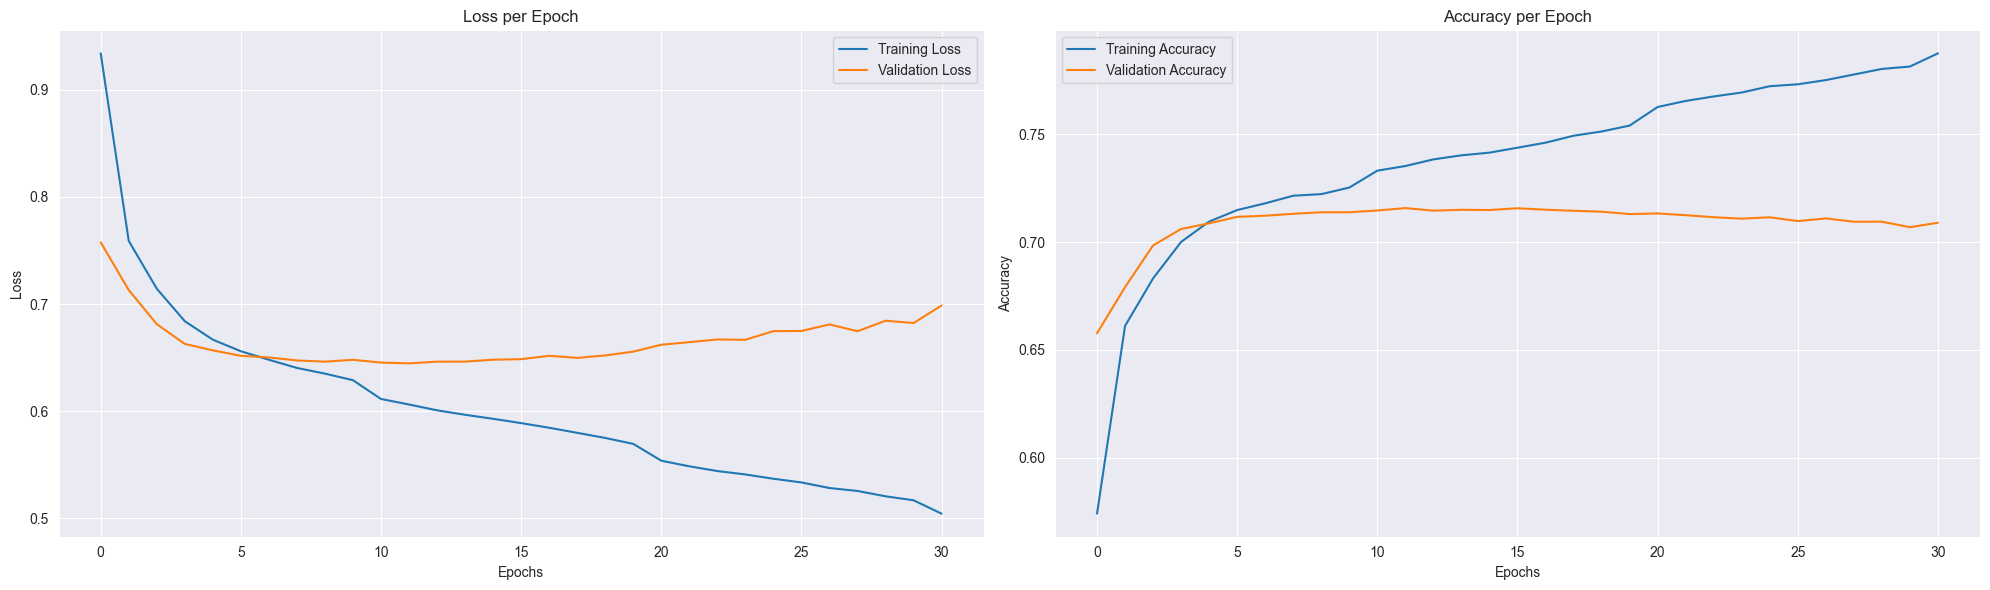

              precision    recall  f1-score   support

           0       0.67      0.71      0.69     28477
           1       0.88      0.77      0.82     79709
           2       0.48      0.58      0.52     23678
           3       0.73      0.81      0.77     33157

    accuracy                           0.74    165021
   macro avg       0.69      0.72      0.70    165021
weighted avg       0.76      0.74      0.74    165021

balanced accuracy 0.7157971540600692


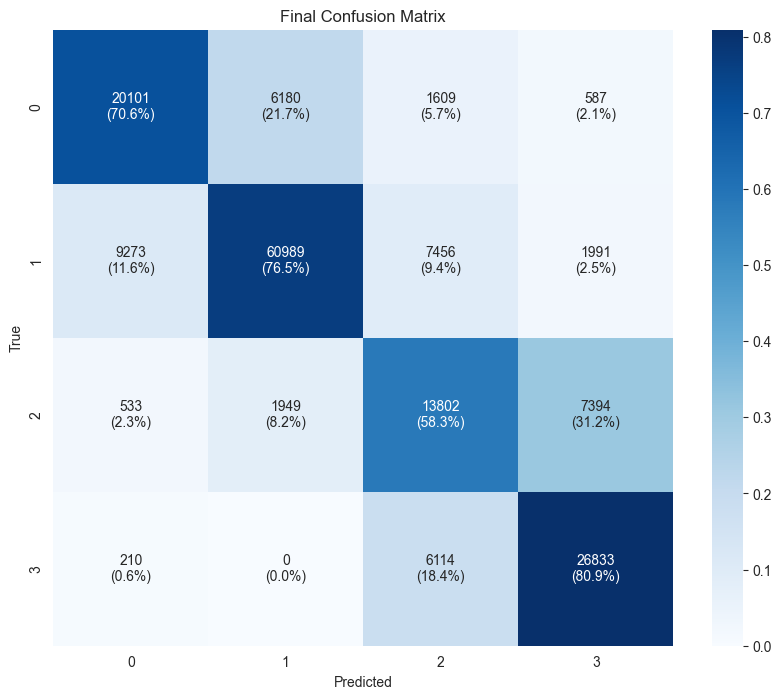

Testing with learning rate: 1e-05
Epoch 1 | Train Loss: 1.3887 | Valid Loss: 1.2744 | Train Accuracy: 0.3000 | Valid Accuracy: 0.4297


KeyboardInterrupt: 

In [ ]:
 learning_rates = [0.0001, 0.00015, 0.00001]
results_lr = []

for lr in learning_rates:
    nnet = NNetWithEmbedding(
        num_features=X.shape[1],
        num_products=len(le_products.classes_),
        num_users=len(le_users.classes_),
        embedding_dim_products=64,  # Valor fijo para los embeddings
        embedding_dim_users=128,
    ).to(device)

    optimizer = torch.optim.Adam(nnet.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    print(f"Testing with learning rate: {lr}")
    result = train_model(
        nnet=nnet,
        train_dl=train_dl,
        test_dl=test_dl,
        loss_function=loss_function,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=50,
        patience=20,
    )
    results_lr.append((lr, result))


In [ ]:
black_sales_embeddings = black_sales.copy()

# Preparar X y y
X = black_sales_embeddings.drop(columns=['Purchase_Category'])
y = black_sales_embeddings['Purchase_Category']

# Aplicar undersampling
sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

# Convertir X_resampled a DataFrame
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

# Codificar Product_ID y User_ID
X_resampled['Product_ID_idx'] = le_products.fit_transform(X_resampled['Product_ID'])
X_resampled['User_ID_idx'] = le_users.fit_transform(X_resampled['User_ID'])

product_ids = X_resampled['Product_ID_idx'].to_numpy()
user_ids = X_resampled['User_ID_idx'].to_numpy()

# Eliminar columnas innecesarias
X_resampled = X_resampled.drop(columns=['Product_ID_idx', 'User_ID_idx', 'Product_ID', 'User_ID'])

# Preparar DataLoaders
train_dl, test_dl, n_train, n_valid = prepare_dataloaders(X_resampled.values, y_resampled, product_ids, user_ids)

loss_function = torch.nn.CrossEntropyLoss(weight=weights)

nnet = NNetWithEmbedding(
    num_features=X.shape[1],
    num_products=len(le_products.classes_),
    num_users=len(le_users.classes_),
    embedding_dim_products=128,
    embedding_dim_users=32,
).to(device)

optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_model(
    nnet=nnet,
    train_dl=train_dl,
    test_dl=test_dl,
    loss_function=loss_function,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=100,
    patience=10
)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

# CNN

## Inspección del dataset

In [ ]:
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

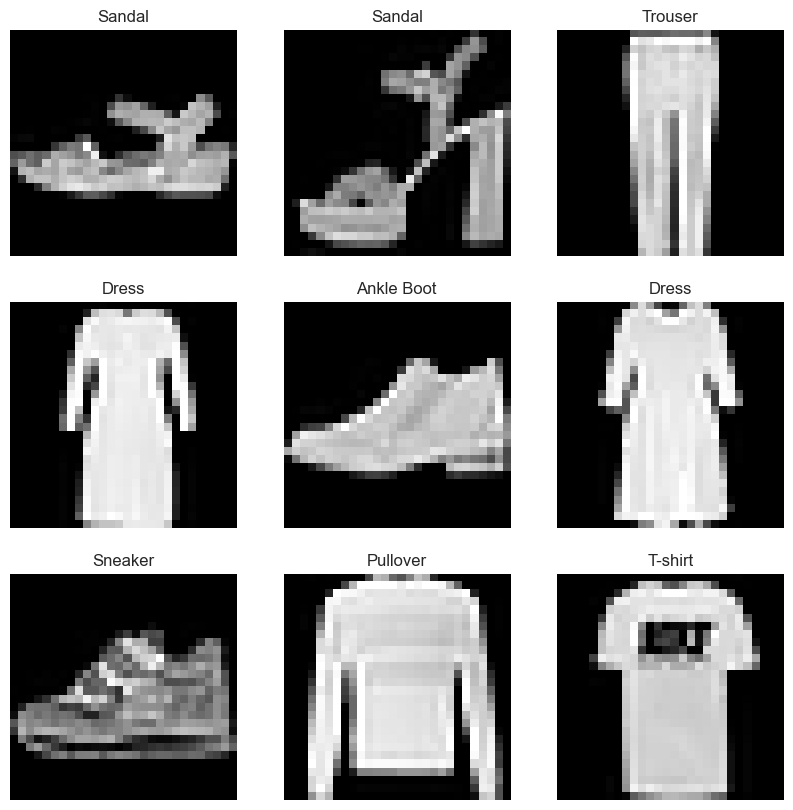

In [ ]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [ ]:
print(f'Tamaño de la data de entrenamiento {len(train_data)}')
print(f'Tamaño de la data de validación {len(test_data)}')

dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

train_features, train_labels = next(iter(dataloader['train']))

print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

Tamaño de la data de entrenamiento 60000
Tamaño de la data de validación 10000
Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])


Al estar en escalas de grises vemos que tienen un solo canal, también podemos ver que son imágenes de 28x28 pixeles

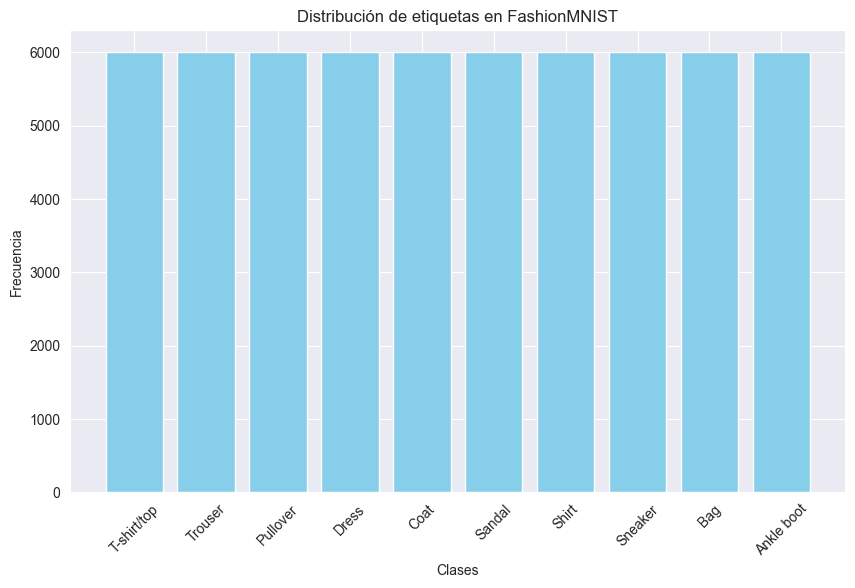

In [ ]:
transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)

labels = [label for _, label in dataset]

label_counts = torch.bincount(torch.tensor(labels))

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
plt.figure(figsize=(10, 6))
plt.bar(class_names, label_counts.numpy(), color='skyblue')
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.title("Distribución de etiquetas en FashionMNIST")
plt.xticks(rotation=45)
plt.show()


Las etiquetas están homogeneamente distribuidas en el dataset

## Implementación

In [ ]:
def conv_block(c_in, c_out, k=3, p='same', s=1, pk=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk)
    )


In [ ]:
class CNN(torch.nn.Module):
  def __init__(self, kernel_n=1, kernel_size=3, dropout_p=0.3, quiet=False):
    super().__init__()
    self.drop = torch.nn.Dropout2d(p=dropout_p, inplace=False)

    conv1_c_out = max(kernel_n, 4)
    self.conv1 = conv_block(c_in = 1, c_out = conv1_c_out, k=kernel_size, p='same', s=1, pk=2)
    self.conv1_out = None

    conv2_c_out = conv1_c_out * 2
    self.conv2 = conv_block(c_in = conv1_c_out, c_out = conv2_c_out, k=kernel_size, p='same', s=1, pk=2)
    self.conv2_out = None

    conv3_c_out = conv2_c_out * 2
    self.conv3 = conv_block(c_in = conv2_c_out, c_out = conv3_c_out, k=kernel_size, p='same', s=1, pk=2)
    self.conv3_out = None

    self.fc = torch.nn.Linear(conv3_c_out*3*3, 10)

    if not quiet:
        print('Red creada')
        print('arquitectura:')
        print(self)

        i=0
        for layer in self.children():
            i=i+1
        print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

        pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def forward(self, x):
    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    y = self.conv3(self.conv2_out)
    y = y.flatten(start_dim=1)
    y = self.fc(y)
    return y

In [ ]:
def train(cnn, epochs=20, quiet=False, dataloader=dataloader, loss_function=None, optimizer=None, scheduler=None):
    cnn.to(device)

    if not quiet:
        print(torchinfo.summary(cnn, input_size=(12, 1, 28, 28)))

    if loss_function is None:
        loss_function = torch.nn.CrossEntropyLoss()

    if optimizer is None:
        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

    return train_model(
        nnet=cnn,
        train_dl=dataloader['train'],
        test_dl=dataloader['test'],
        loss_function=loss_function,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        epochs=epochs,
        patience=5,
        quiet=quiet
    )


## Modelo base

Red creada
arquitectura:
CNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=144, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  2954
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [12, 10]                  --
├─Sequential: 1-1 

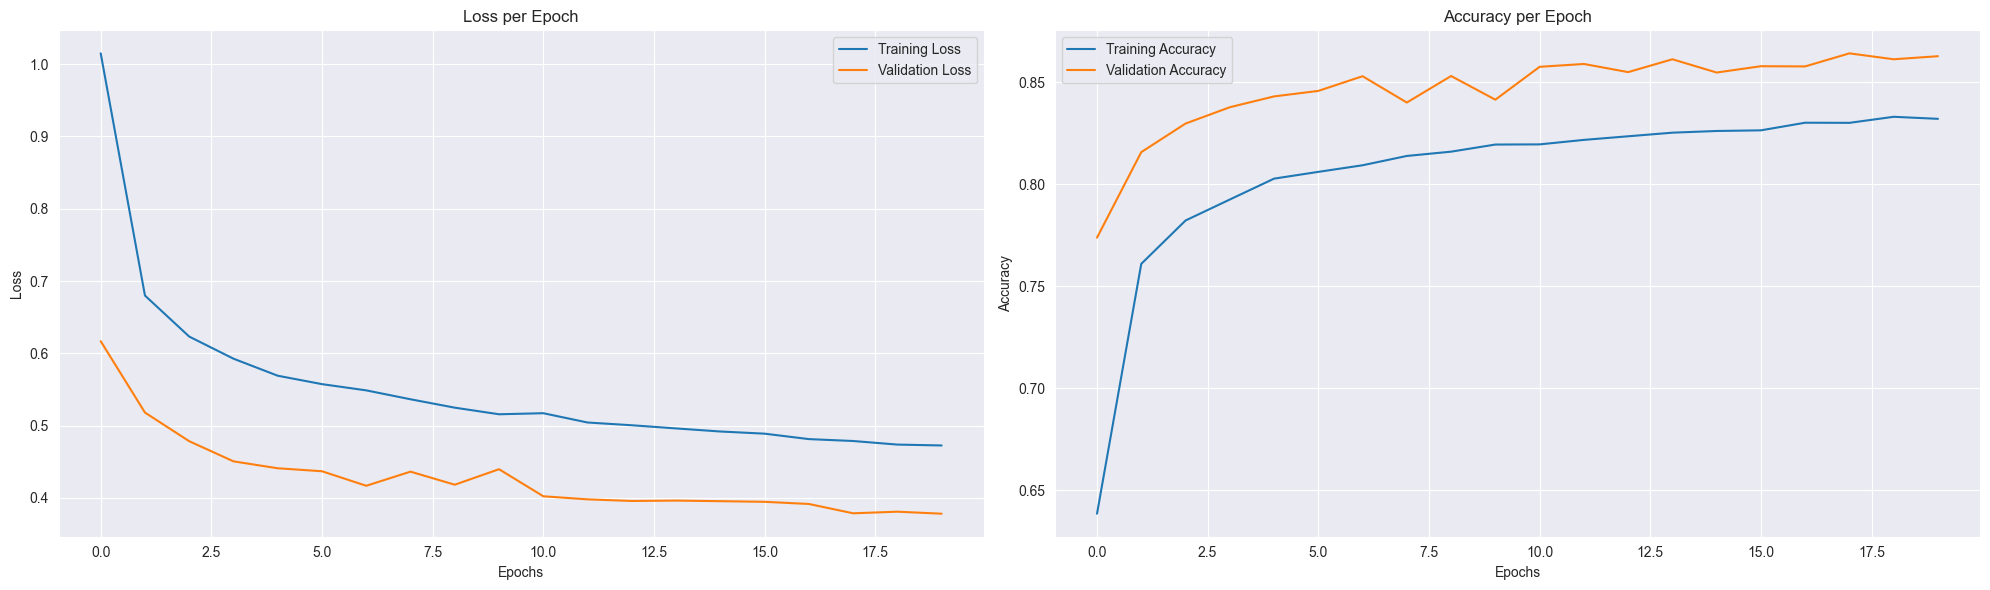

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.80      0.80      1000
           3       0.85      0.90      0.87      1000
           4       0.78      0.72      0.75      1000
           5       0.98      0.93      0.95      1000
           6       0.64      0.61      0.62      1000
           7       0.91      0.95      0.93      1000
           8       0.96      0.96      0.96      1000
           9       0.95      0.97      0.96      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

balanced accuracy 0.8627


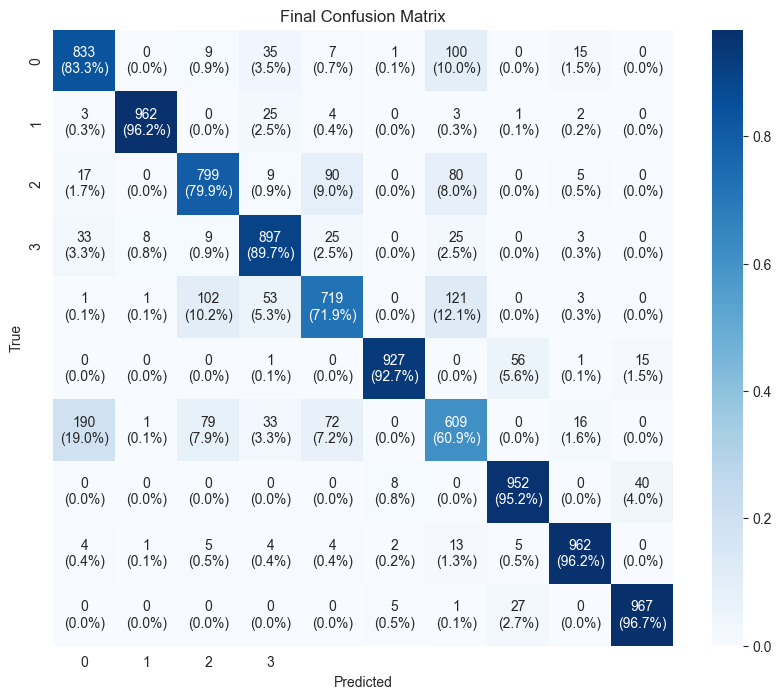

np.float64(0.8627)

In [ ]:
train(CNN())

El caso base presenta resultados aceptables, alcanzando una balanced accuracy de aproximadamente 0.86. Sin embargo, al analizar el gráfico de pérdida, se observa que todavía hay margen de mejora. Las curvas de pérdida para entrenamiento y validación se estabilizan rápidamente, lo que sugiere que el modelo no está captando comportamientos más complejos en los datos. Además, la curva de pérdida de entrenamiento nunca se encuentra por debajo de la de validación, lo que indica que el modelo no llega a sobreajustar (overfitting) en ningún momento.

A continuación, se explorarán variaciones con el objetivo de incrementar la capacidad y complejidad de la red para mejorar su desempeño.

## Variaciones

In [ ]:
def create_objective(model_fn, epochs=20):
    def objective(trial, epochs=epochs):
        model = model_fn(trial)

        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        start_time = time.time()
        accuracy = train(model, quiet=True, epochs=epochs)  # Entrenar el modelo
        end_time = time.time()

        trial.set_user_attr("total_params", total_params)
        trial.set_user_attr("training_time", end_time - start_time)

        return accuracy

    return objective

In [ ]:
class DynamicCNN(torch.nn.Module):
    def __init__(self, layers_n, kernel_n=4, kernel_size=3, dropout_p=0.3, quiet=False):
        super(DynamicCNN, self).__init__()
        self.drop = torch.nn.Dropout2d(p=dropout_p, inplace=False)

        layers = []
        c_in = 1
        c_out = max(kernel_n, 4)
        height, width = 28, 28

        for i in range(layers_n):
            if i < 4:
                layers.append(conv_block(c_in, c_out, k=kernel_size))
                height = (height // 2)
                width = (width // 2)
            else:
                layers.append(conv_block(c_in, c_out, pk=1))

            c_in = c_out
            c_out *= 2


        self.conv_layers = torch.nn.Sequential(*layers)

        self.fc = torch.nn.Linear(c_in * height * width, 10)

        if not quiet:
            print('Red creada')
            print('Arquitectura:')
            print(self)
            print(f'Tamaño espacial final: {height}x{width}')
            total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
            print(f'Número total de parámetros a entrenar: {total_params}')

    def forward(self, x):
        x = self.drop(self.conv_layers(x))
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x


### 1. Sobre el tamaño del kernel

In [ ]:
search_space = {"kernel_size": [3, 5, 7, 15, 35]}
sampler = optuna.samplers.GridSampler(search_space)

study = optuna.create_study(direction="maximize", sampler=sampler)

cnn_fn = lambda trial: CNN(kernel_size=trial.suggest_categorical("kernel_size", [3, 5, 7, 15, 35]), quiet=True)
ob = create_objective(cnn_fn)
study.optimize(ob, n_trials=5)

for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  Kernel size: {trial.params['kernel_size']}")
    print(f"  Total parameters: {trial.user_attrs['total_params']}")
    print(f"  Training time: {trial.user_attrs['training_time']:.2f} seconds")
    print(f"  Accuracy: {trial.value}")

[I 2024-11-28 20:55:33,998] A new study created in memory with name: no-name-e1dbd66c-632a-4e07-8b1b-63fd05d43145
[I 2024-11-28 20:58:58,054] Trial 0 finished with value: 0.8821999999999999 and parameters: {'kernel_size': 7}. Best is trial 0 with value: 0.8821999999999999.
[I 2024-11-28 21:02:08,503] Trial 1 finished with value: 0.8651 and parameters: {'kernel_size': 3}. Best is trial 0 with value: 0.8821999999999999.
[I 2024-11-28 21:05:21,277] Trial 2 finished with value: 0.8754 and parameters: {'kernel_size': 5}. Best is trial 0 with value: 0.8821999999999999.
[I 2024-11-28 21:08:50,724] Trial 3 finished with value: 0.8881 and parameters: {'kernel_size': 15}. Best is trial 3 with value: 0.8881.
[I 2024-11-28 21:20:54,206] Trial 4 finished with value: 0.8849 and parameters: {'kernel_size': 35}. Best is trial 3 with value: 0.8881.


Trial 0:
  Kernel size: 7
  Total parameters: 9514
  Training time: 204.06 seconds
  Accuracy: 0.8821999999999999
Trial 1:
  Kernel size: 3
  Total parameters: 2954
  Training time: 190.45 seconds
  Accuracy: 0.8651
Trial 2:
  Kernel size: 5
  Total parameters: 5578
  Training time: 192.77 seconds
  Accuracy: 0.8754
Trial 3:
  Kernel size: 15
  Total parameters: 38378
  Training time: 209.44 seconds
  Accuracy: 0.8881
Trial 4:
  Kernel size: 35
  Total parameters: 202378
  Training time: 723.48 seconds
  Accuracy: 0.8849


Si bien los márgenes de mejora son bastante chicos, la variación kernel = 5 es el modelo que balancea mejor accuracy y peso.

Red creada
arquitectura:
CNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=144, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  5578
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [12, 10]                  --
├─Sequential: 1-1 

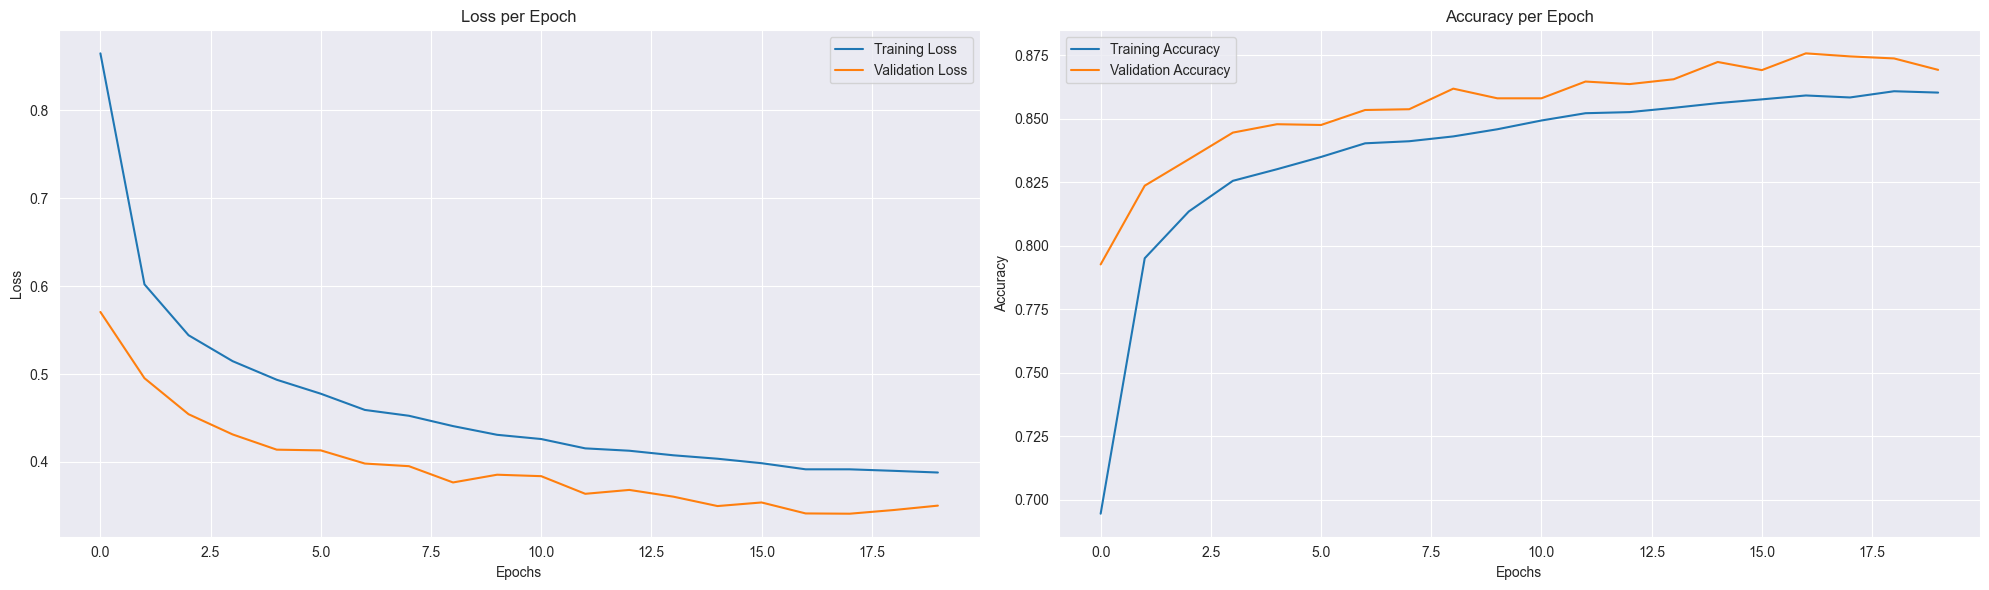

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.76      0.83      0.79      1000
           3       0.86      0.90      0.88      1000
           4       0.82      0.73      0.77      1000
           5       0.98      0.96      0.97      1000
           6       0.67      0.62      0.64      1000
           7       0.93      0.97      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

balanced accuracy 0.8745999999999998


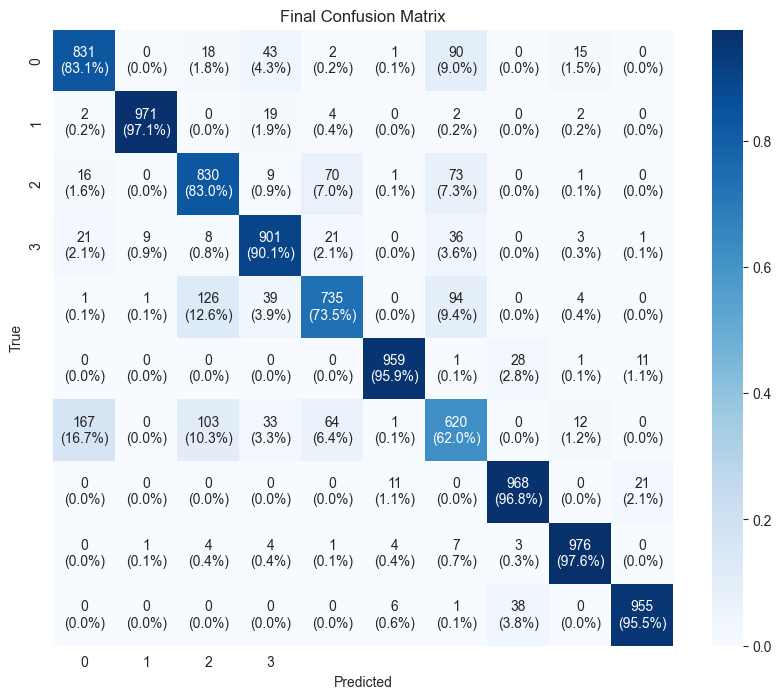

np.float64(0.8745999999999998)

In [ ]:
train(CNN(kernel_size=5))

### 2. Sobre la cantidad de Kernels

In [ ]:
search_space = {"kernel_n": [8, 16, 32, 64]}
sampler = optuna.samplers.GridSampler(search_space)

study = optuna.create_study(direction="maximize", sampler=sampler)

cnn_fn = lambda trial: CNN(kernel_n=trial.suggest_categorical("kernel_n", [8, 16, 32, 64]), quiet=True)
ob = create_objective(cnn_fn)
study.optimize(ob, n_trials=4)

for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  Kernels: {trial.params['kernel_n']}")
    print(f"  Total parameters: {trial.user_attrs['total_params']}")
    print(f"  Training time: {trial.user_attrs['training_time']:.2f} seconds")
    print(f"  Accuracy: {trial.value}")


[I 2024-11-28 15:07:58,539] A new study created in memory with name: no-name-3cff480e-1909-4d5e-98c9-4b1b4bc1392e
[I 2024-11-28 15:17:51,642] Trial 0 finished with value: 0.9216 and parameters: {'kernel_n': 32}. Best is trial 0 with value: 0.9216.
[I 2024-11-28 15:35:27,864] Trial 1 finished with value: 0.9233 and parameters: {'kernel_n': 64}. Best is trial 1 with value: 0.9233.
[I 2024-11-28 15:40:57,047] Trial 2 finished with value: 0.9110999999999999 and parameters: {'kernel_n': 16}. Best is trial 1 with value: 0.9233.
[I 2024-11-28 15:44:15,689] Trial 3 finished with value: 0.8974 and parameters: {'kernel_n': 8}. Best is trial 1 with value: 0.9233.


Trial 0:
  Kernels: 32
  Total parameters: 104202
  Training time: 593.10 seconds
  Accuracy: 0.9216
Trial 1:
  Kernels: 64
  Total parameters: 392714
  Training time: 1056.22 seconds
  Accuracy: 0.9233
Trial 2:
  Kernels: 16
  Total parameters: 29066
  Training time: 329.18 seconds
  Accuracy: 0.9110999999999999
Trial 3:
  Kernels: 8
  Total parameters: 8778
  Training time: 198.64 seconds
  Accuracy: 0.8974


Hay una diferencia marcada en la precision al aumentar la cantidad de kernels. Si bien el modelo de 64 kernels fue el que mayor precision obtuvo también es el computacionalmente más costoso. En este caso el valor elegido será 32 ya que tiene una precision muy similar al de 64 pero la mitad del peso.

Red creada
arquitectura:
CNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1152, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  104202
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [12, 10]                  --
├─Sequenti

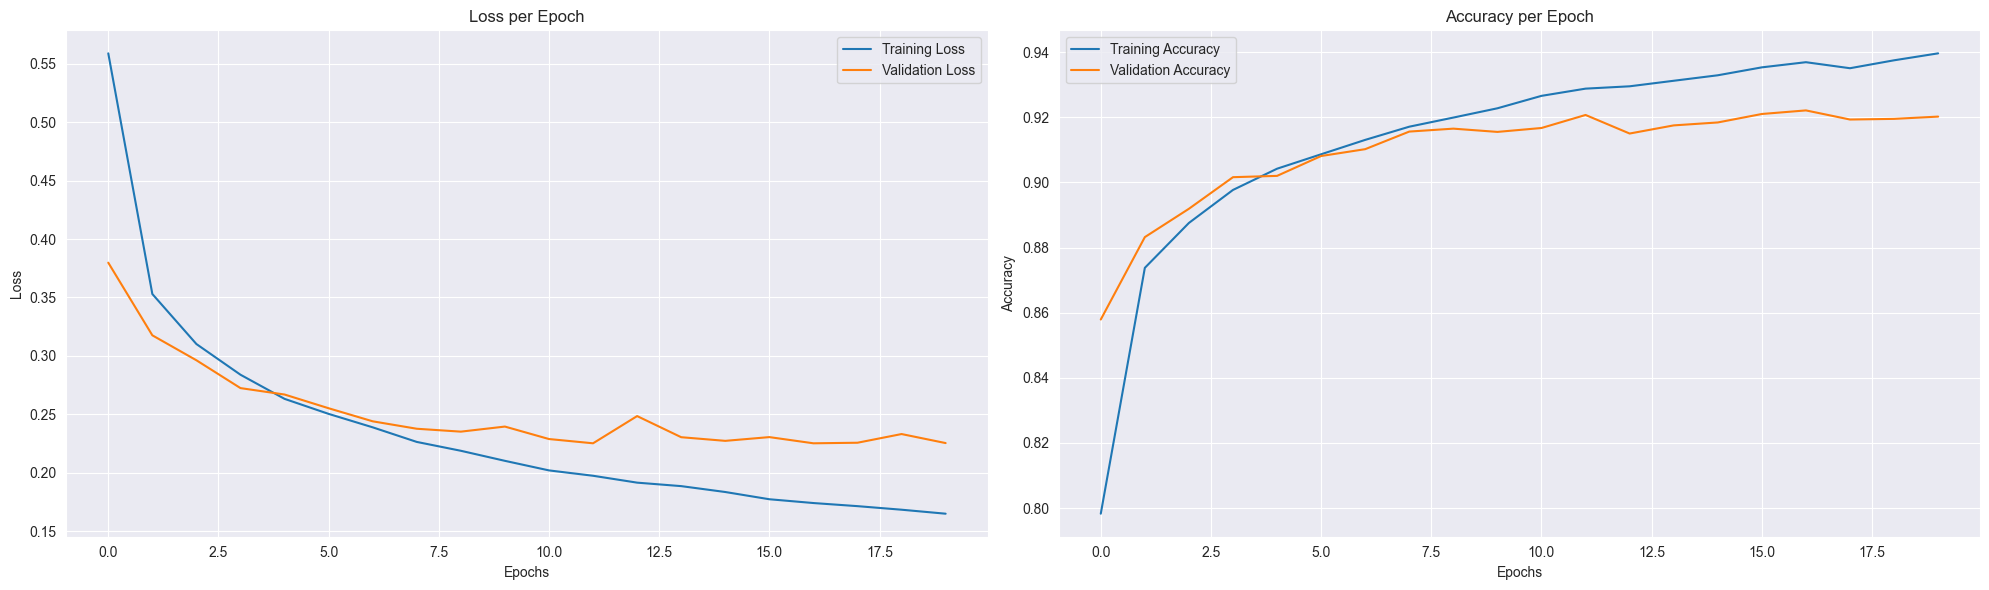

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.86      0.90      0.88      1000
           3       0.91      0.94      0.92      1000
           4       0.88      0.88      0.88      1000
           5       0.99      0.99      0.99      1000
           6       0.76      0.78      0.77      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

balanced accuracy 0.9221


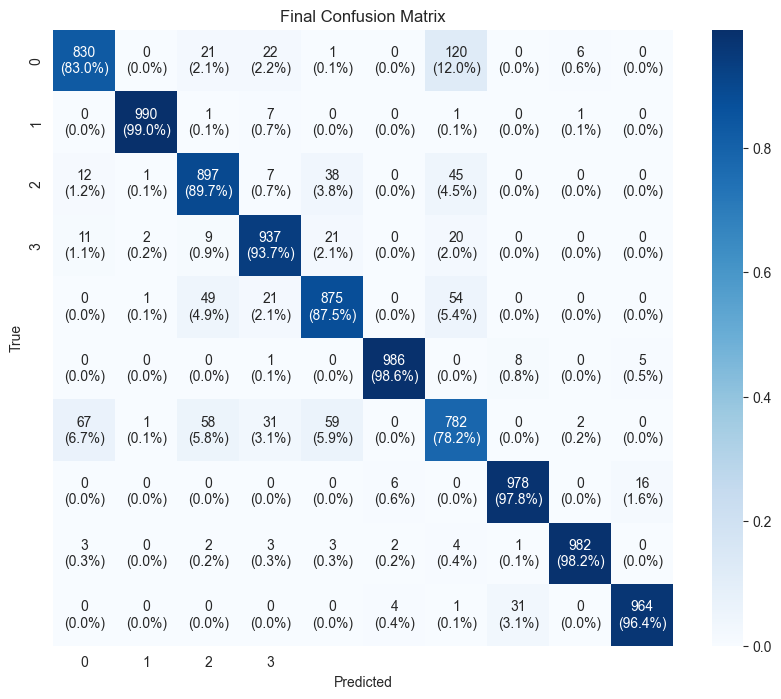

np.float64(0.9221)

In [ ]:
train(CNN(kernel_n=32))

Algo peculiar de esta variación es que el modelo ya sobre ajusta, se puede apreciar esto al ver como ambas curvas de validación luego de crecer se estancan mientras que las de entrenamiento siguen mejorando. Luego realizaré pruebas cambiando el porcentaje de dropout para ver si puedo desajustar y mejorar aún más la precision.

### 3. Sobre la cantidad de capas

In [ ]:
search_space = {"layers_n": [4, 5, 7, 9]}
sampler = optuna.samplers.GridSampler(search_space)

study = optuna.create_study(direction="maximize", sampler=sampler)

cnn_fn = lambda trial: DynamicCNN(layers_n=trial.suggest_categorical("layers_n", [4, 5, 7, 9]), quiet=True)
ob = create_objective(cnn_fn)
study.optimize(ob, n_trials=4)

for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  Num layers: {trial.params['layers_n']}")
    print(f"  Total parameters: {trial.user_attrs['total_params']}")
    print(f"  Training time: {trial.user_attrs['training_time']:.2f} seconds")
    print(f"  Accuracy: {trial.value}")


[I 2024-11-28 13:52:07,165] A new study created in memory with name: no-name-d13e06b5-34d7-4ec3-8567-575b00e654fa
[I 2024-11-28 13:59:12,073] Trial 0 finished with value: 0.8728 and parameters: {'layers_n': 7}. Best is trial 0 with value: 0.8728.
[I 2024-11-28 14:30:06,678] Trial 1 finished with value: 0.8783 and parameters: {'layers_n': 9}. Best is trial 1 with value: 0.8783.
[I 2024-11-28 14:35:12,043] Trial 2 finished with value: 0.8823000000000001 and parameters: {'layers_n': 5}. Best is trial 2 with value: 0.8823000000000001.
[I 2024-11-28 14:38:22,027] Trial 3 finished with value: 0.8705 and parameters: {'layers_n': 4}. Best is trial 2 with value: 0.8823000000000001.


Trial 0:
  Num layers: 7
  Total parameters: 396234
  Training time: 424.89 seconds
  Accuracy: 0.8728
Trial 1:
  Num layers: 9
  Total parameters: 6303690
  Training time: 1854.56 seconds
  Accuracy: 0.8783
Trial 2:
  Num layers: 5
  Total parameters: 25290
  Training time: 305.36 seconds
  Accuracy: 0.8823000000000001
Trial 3:
  Num layers: 4
  Total parameters: 6474
  Training time: 189.98 seconds
  Accuracy: 0.8705


No hay tanta diferencia con el modelo base, sin embargo la cantidad de layers elegida será 5 ya que fue la que mejor precision dió sin ser tan pesada.

Red creada
Arquitectura:
DynamicCNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride

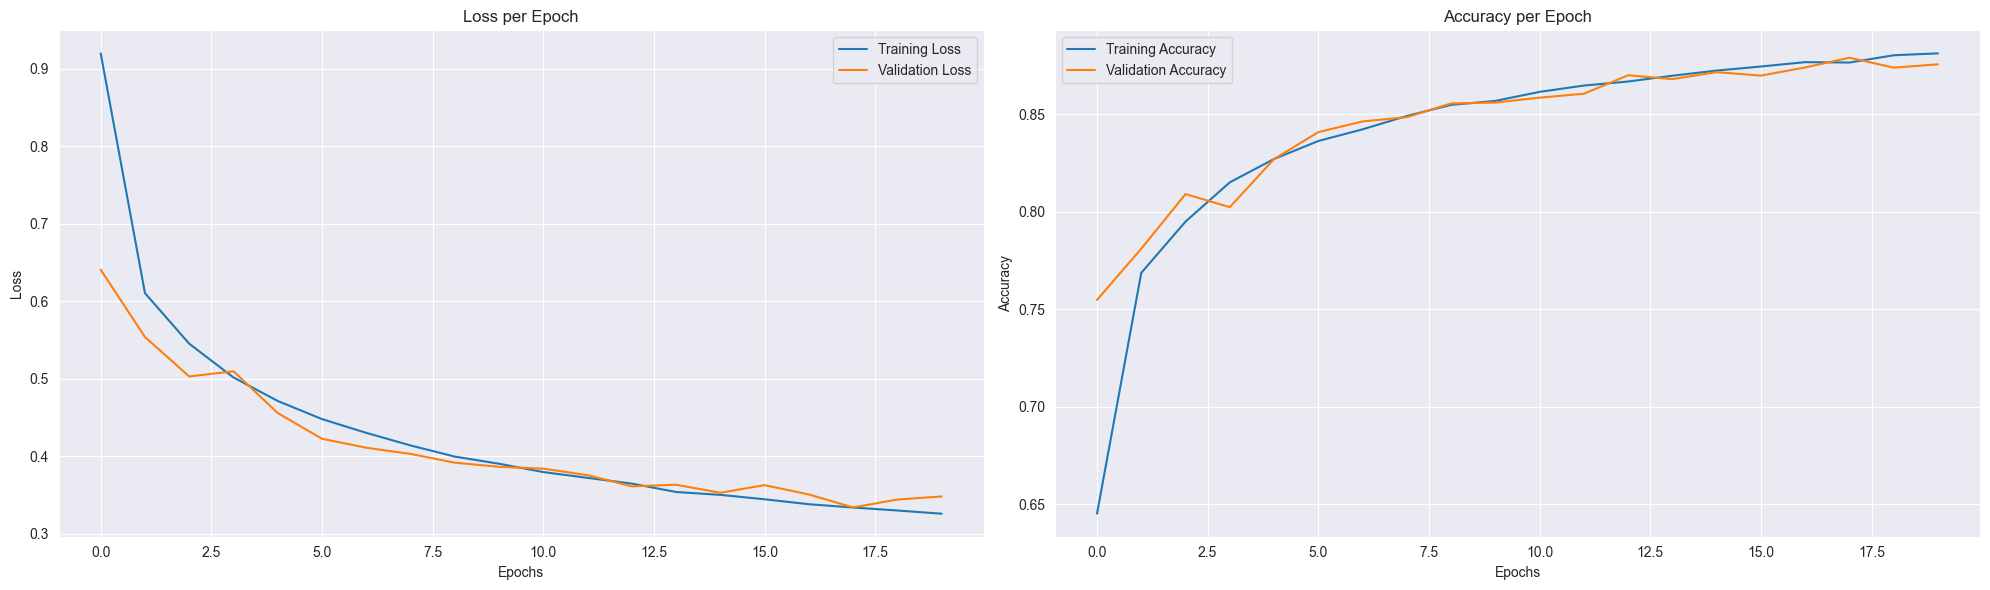

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.98      0.96      0.97      1000
           2       0.78      0.82      0.80      1000
           3       0.84      0.92      0.88      1000
           4       0.78      0.80      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.74      0.58      0.65      1000
           7       0.93      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

balanced accuracy 0.8791


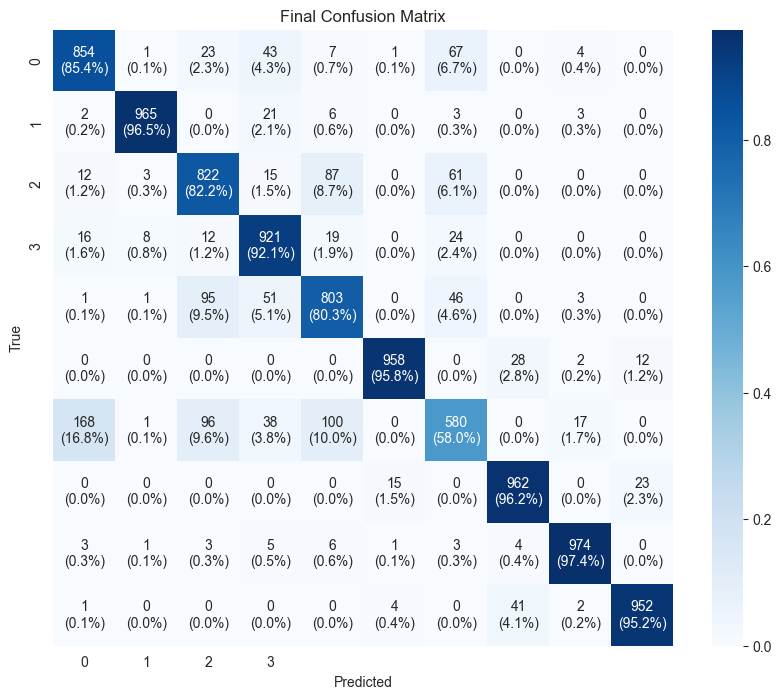

np.float64(0.8791)

In [ ]:
train(DynamicCNN(layers_n=5))

Veo que el modelo comienza a sobreajustar

### 4. Sobre la cantidad y el tamaño del kernel

Red creada
arquitectura:
CNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1152, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  515082
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [12, 10]                  --
├─Sequenti

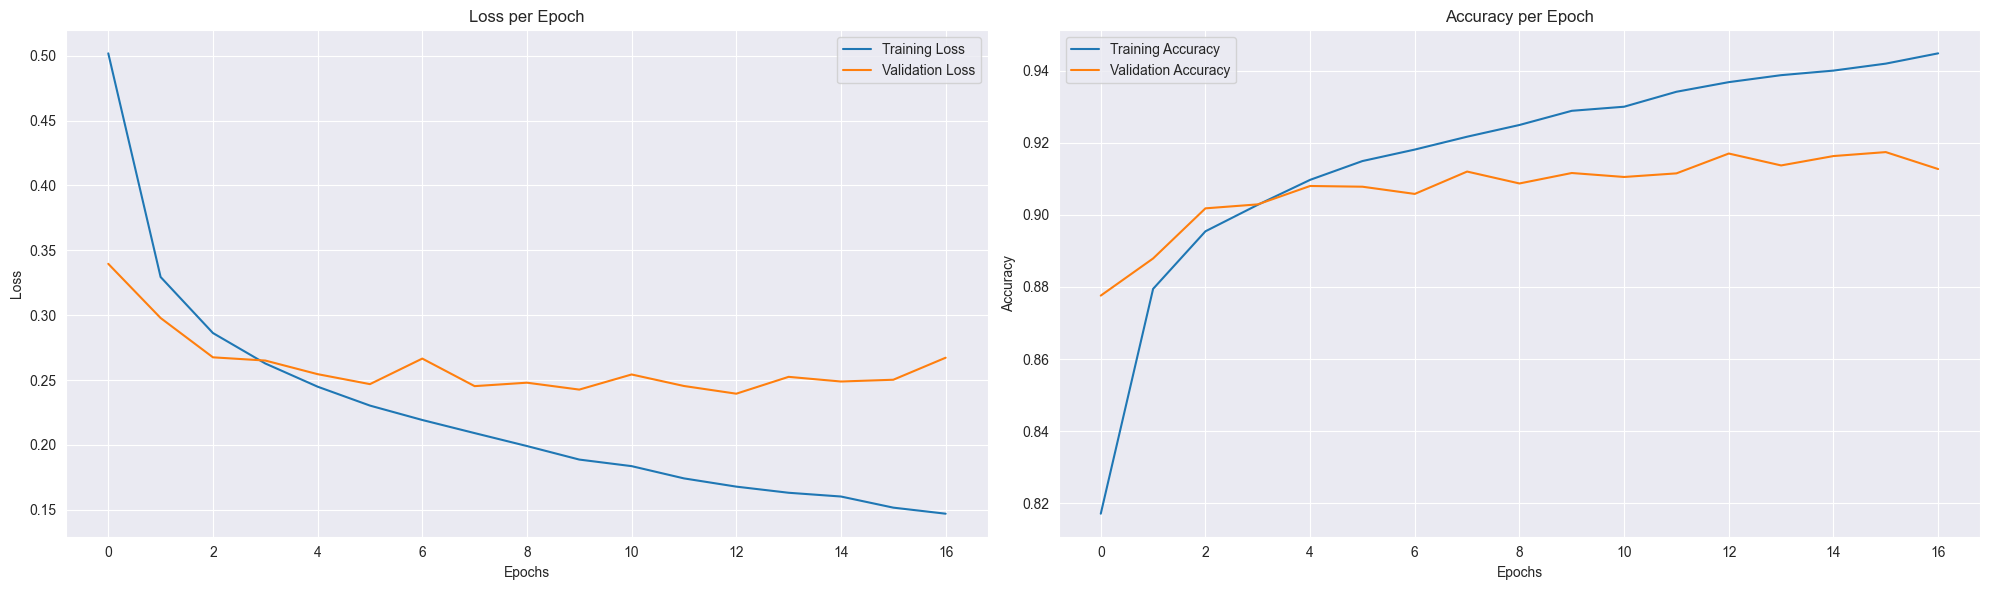

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.86      0.86      0.86      1000
           3       0.92      0.92      0.92      1000
           4       0.86      0.85      0.86      1000
           5       0.99      0.99      0.99      1000
           6       0.75      0.77      0.76      1000
           7       0.97      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

balanced accuracy 0.917


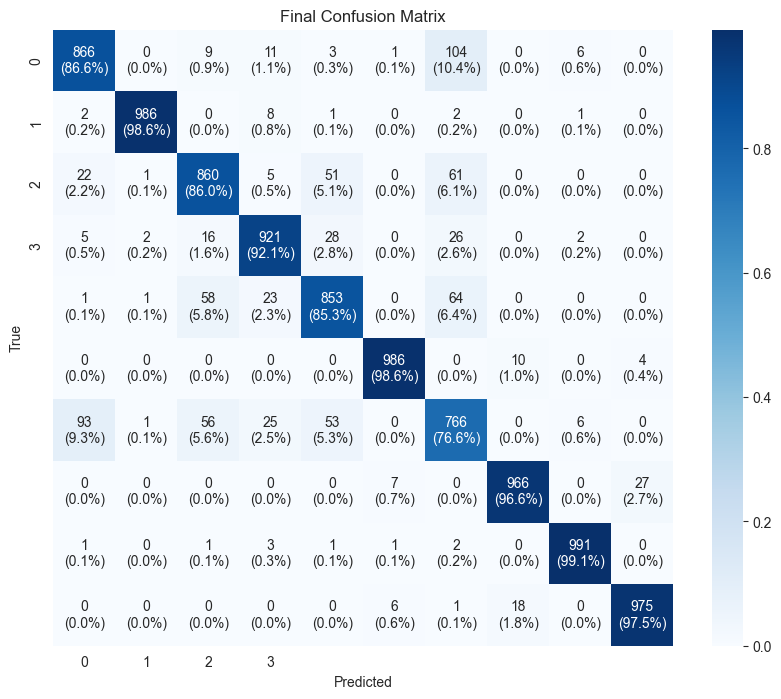

np.float64(0.917)

In [ ]:
train(CNN(kernel_n=32, kernel_size=5))

### 5. Sobre la cantidad de kernels y capas

Red creada
Arquitectura:
DynamicCNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3

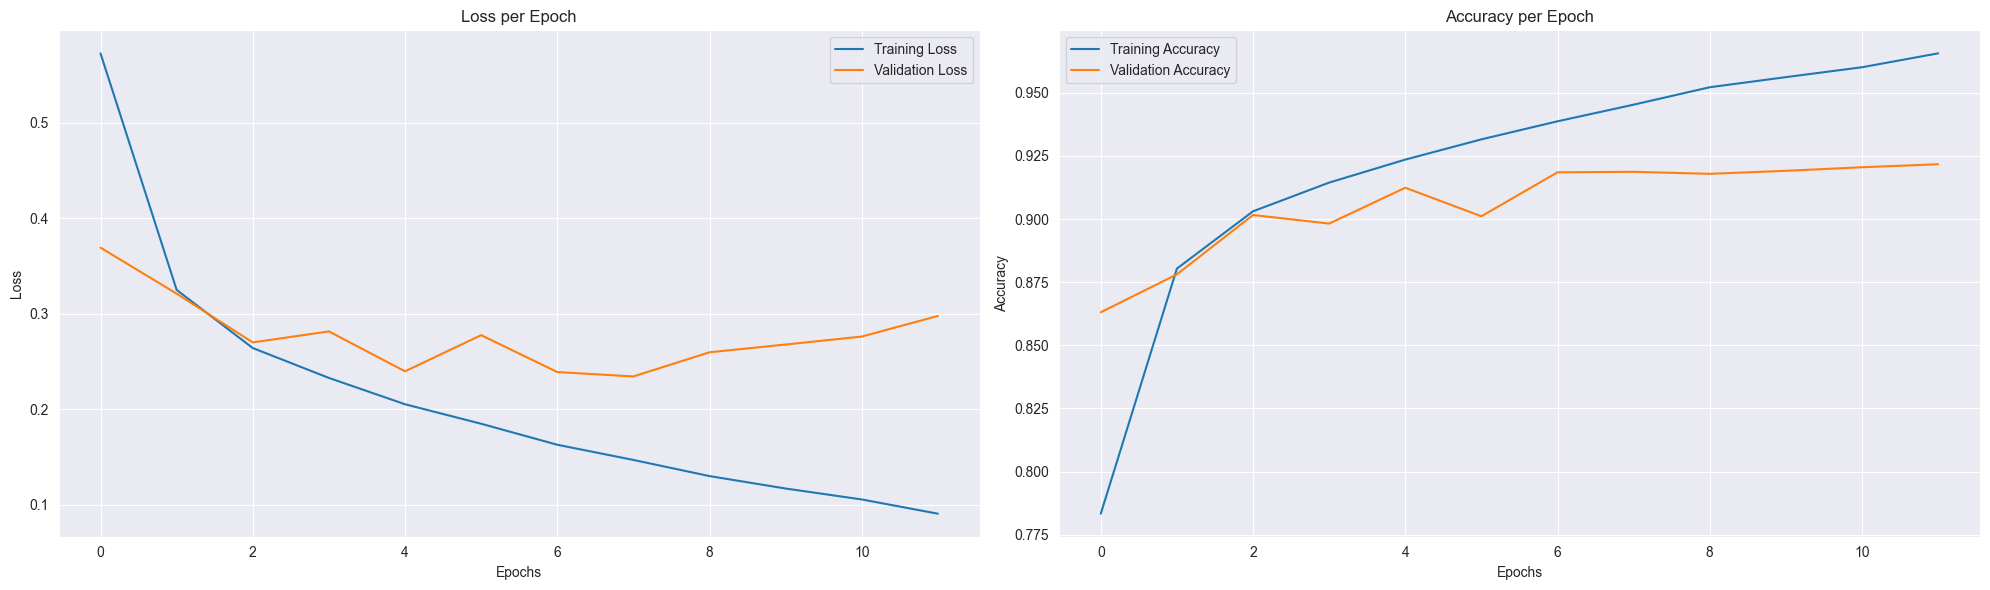

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.87      0.88      1000
           3       0.90      0.93      0.91      1000
           4       0.86      0.87      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.76      0.79      0.77      1000
           7       0.95      0.98      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.99      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

balanced accuracy 0.9187000000000001


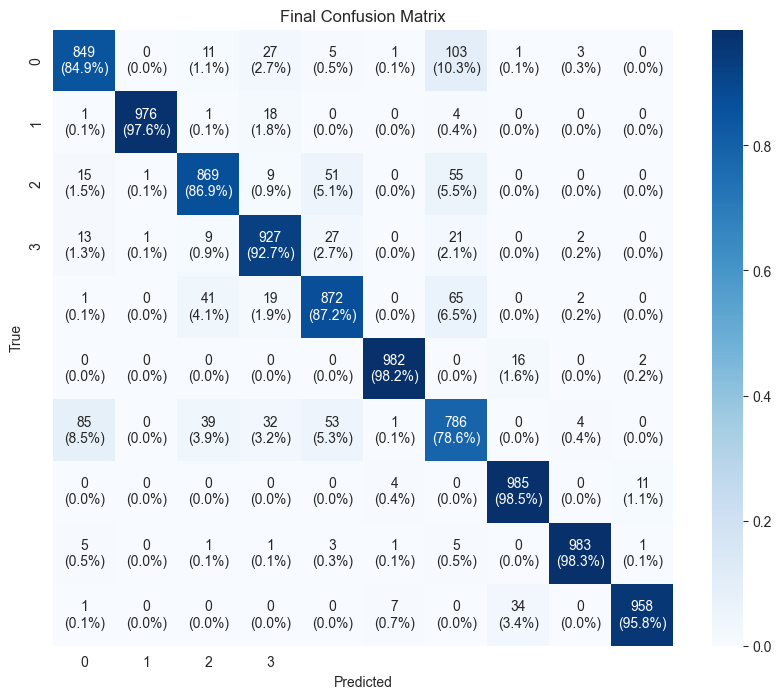

np.float64(0.9187000000000001)

In [ ]:
train(DynamicCNN(kernel_n=32, layers_n=5))

### 6. Sobre la cantidad de capas y el tamaño y cantidad de kernels

Red creada
Arquitectura:
DynamicCNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3

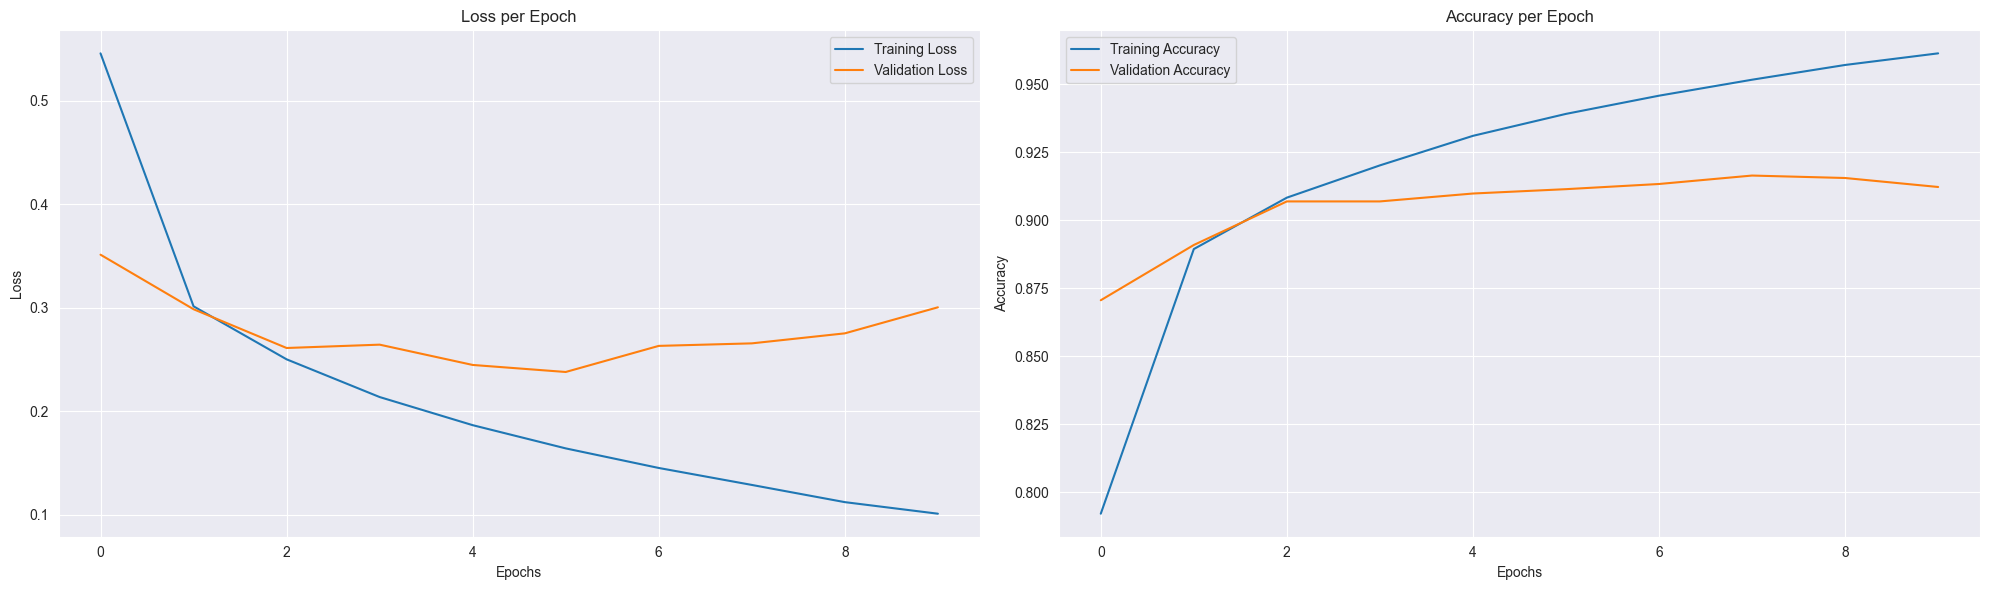

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.90      0.82      0.86      1000
           3       0.91      0.93      0.92      1000
           4       0.84      0.87      0.86      1000
           5       0.97      0.99      0.98      1000
           6       0.71      0.81      0.76      1000
           7       0.98      0.94      0.96      1000
           8       0.99      0.97      0.98      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

balanced accuracy 0.9113999999999999


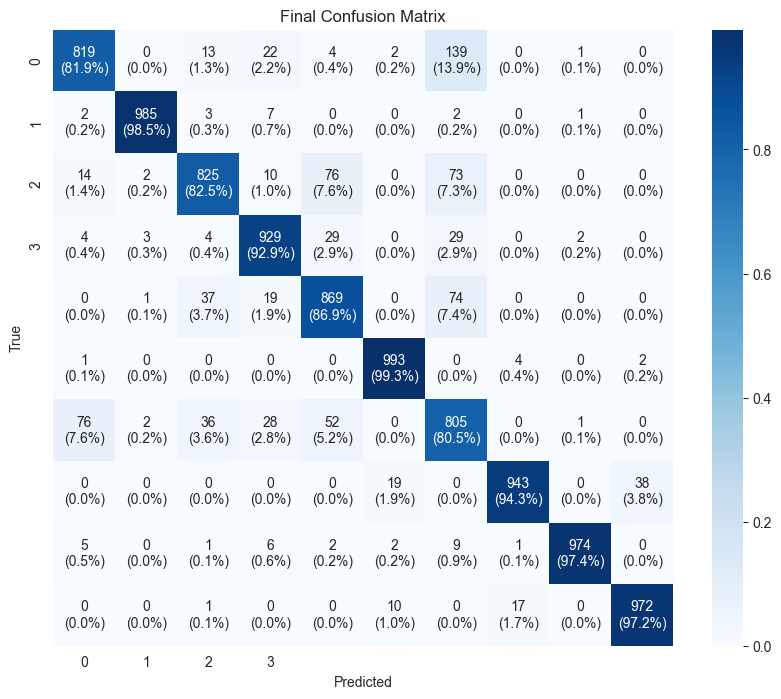

np.float64(0.9113999999999999)

In [ ]:
train(DynamicCNN(kernel_n=32, layers_n=5, kernel_size=5))


Si bien la precision dió peor que modelos anteriores, vale indicar que es el modelo que presenta valores mejor distribuídos en la matriz de confusión

### 7. Sobre el porcentaje de dropout

In [ ]:
search_space = {"dropout_p": [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]}
sampler = optuna.samplers.GridSampler(search_space)

study = optuna.create_study(direction="maximize", sampler=sampler)

cnn_fn = lambda trial: DynamicCNN(kernel_n=32, layers_n=5, kernel_size=5, dropout_p=trial.suggest_categorical("dropout_p", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]), quiet=True)
ob = create_objective(cnn_fn, epochs=10)
study.optimize(ob, n_trials=9)

for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  Dropout: {trial.params['dropout_p']}")
    print(f"  Total parameters: {trial.user_attrs['total_params']}")
    print(f"  Training time: {trial.user_attrs['training_time']:.2f} seconds")
    print(f"  Accuracy: {trial.value}")

[I 2024-11-28 22:38:57,431] A new study created in memory with name: no-name-5cb3e4a0-d61f-4e03-bcf5-763254406b1f
[I 2024-11-28 22:42:44,405] Trial 0 finished with value: 0.9120000000000001 and parameters: {'dropout_p': 0.55}. Best is trial 0 with value: 0.9120000000000001.
[I 2024-11-28 22:46:07,392] Trial 1 finished with value: 0.9081000000000001 and parameters: {'dropout_p': 0.3}. Best is trial 0 with value: 0.9120000000000001.
[I 2024-11-28 22:49:30,244] Trial 2 finished with value: 0.9141 and parameters: {'dropout_p': 0.25}. Best is trial 2 with value: 0.9141.
[I 2024-11-28 22:52:54,048] Trial 3 finished with value: 0.9132 and parameters: {'dropout_p': 0.4}. Best is trial 2 with value: 0.9141.
[I 2024-11-28 22:56:41,784] Trial 4 finished with value: 0.9086000000000001 and parameters: {'dropout_p': 0.6}. Best is trial 2 with value: 0.9141.
[I 2024-11-28 23:00:31,757] Trial 5 finished with value: 0.9158999999999999 and parameters: {'dropout_p': 0.5}. Best is trial 5 with value: 0.91

Trial 0:
  Dropout: 0.2
  Total parameters: 2261770
  Training time: 226.94 seconds
  Accuracy: 0.9120000000000001
Trial 1:
  Dropout: 0.2
  Total parameters: 2261770
  Training time: 202.96 seconds
  Accuracy: 0.9081000000000001
Trial 2:
  Dropout: 0.2
  Total parameters: 2261770
  Training time: 202.84 seconds
  Accuracy: 0.9141
Trial 3:
  Dropout: 0.2
  Total parameters: 2261770
  Training time: 203.77 seconds
  Accuracy: 0.9132
Trial 4:
  Dropout: 0.2
  Total parameters: 2261770
  Training time: 227.72 seconds
  Accuracy: 0.9086000000000001
Trial 5:
  Dropout: 0.2
  Total parameters: 2261770
  Training time: 229.96 seconds
  Accuracy: 0.9158999999999999
Trial 6:
  Dropout: 0.2
  Total parameters: 2261770
  Training time: 203.36 seconds
  Accuracy: 0.9122999999999999
Trial 7:
  Dropout: 0.2
  Total parameters: 2261770
  Training time: 225.67 seconds
  Accuracy: 0.9172
Trial 8:
  Dropout: 0.2
  Total parameters: 2261770
  Training time: 225.44 seconds
  Accuracy: 0.9155000000000001


In [ ]:
search_space = {"dropout_p": [0.2, 0.25, 0.45, 0.55]}
sampler = optuna.samplers.GridSampler(search_space)

study = optuna.create_study(direction="maximize", sampler=sampler)

cnn_fn = lambda trial: DynamicCNN(kernel_n=32, layers_n=5, kernel_size=5, dropout_p=trial.suggest_categorical("dropout_p", [0.2, 0.25, 0.45, 0.55]), quiet=True)
ob = create_objective(cnn_fn, epochs=20)
study.optimize(ob, n_trials=4)

for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  Dropout: {trial.params['dropout_p']}")
    print(f"  Total parameters: {trial.user_attrs['total_params']}")
    print(f"  Training time: {trial.user_attrs['training_time']:.2f} seconds")
    print(f"  Accuracy: {trial.value}")

[I 2024-11-28 23:13:38,421] A new study created in memory with name: no-name-18257f70-c3ba-4ae3-b935-31794a34390c
[I 2024-11-28 23:17:46,726] Trial 0 finished with value: 0.9153 and parameters: {'dropout_p': 0.45}. Best is trial 0 with value: 0.9153.
[I 2024-11-28 23:21:32,547] Trial 1 finished with value: 0.9160999999999999 and parameters: {'dropout_p': 0.55}. Best is trial 1 with value: 0.9160999999999999.
[I 2024-11-28 23:25:18,850] Trial 2 finished with value: 0.9179 and parameters: {'dropout_p': 0.25}. Best is trial 2 with value: 0.9179.
[I 2024-11-28 23:29:06,051] Trial 3 finished with value: 0.9151 and parameters: {'dropout_p': 0.2}. Best is trial 2 with value: 0.9179.


Trial 0:
  Dropout: 0.25
  Total parameters: 2261770
  Training time: 248.29 seconds
  Accuracy: 0.9153
Trial 1:
  Dropout: 0.25
  Total parameters: 2261770
  Training time: 225.81 seconds
  Accuracy: 0.9160999999999999
Trial 2:
  Dropout: 0.25
  Total parameters: 2261770
  Training time: 226.30 seconds
  Accuracy: 0.9179
Trial 3:
  Dropout: 0.25
  Total parameters: 2261770
  Training time: 227.19 seconds
  Accuracy: 0.9151


In [ ]:
search_space = {"dropout_p": [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]}
sampler = optuna.samplers.GridSampler(search_space)

study = optuna.create_study(direction="maximize", sampler=sampler)

cnn_fn = lambda trial: CNN(kernel_n=32, dropout_p=trial.suggest_categorical("dropout_p", [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]), quiet=True)
ob = create_objective(cnn_fn, epochs=10)
study.optimize(ob, n_trials=9)

for trial in study.trials:
    print(f"Trial {trial.number}:")
    print(f"  Dropout: {trial.params['dropout_p']}")
    print(f"  Total parameters: {trial.user_attrs['total_params']}")
    print(f"  Training time: {trial.user_attrs['training_time']:.2f} seconds")
    print(f"  Accuracy: {trial.value}")

[I 2024-12-01 12:56:23,820] A new study created in memory with name: no-name-46885c26-9406-403d-9161-d0fa12f5af9d
[I 2024-12-01 12:58:38,852] Trial 0 finished with value: 0.9046 and parameters: {'dropout_p': 0.55}. Best is trial 0 with value: 0.9046.
[I 2024-12-01 13:00:49,880] Trial 1 finished with value: 0.9154 and parameters: {'dropout_p': 0.3}. Best is trial 1 with value: 0.9154.
[I 2024-12-01 13:03:01,945] Trial 2 finished with value: 0.9109 and parameters: {'dropout_p': 0.25}. Best is trial 1 with value: 0.9154.
[I 2024-12-01 13:05:24,156] Trial 3 finished with value: 0.9097 and parameters: {'dropout_p': 0.4}. Best is trial 1 with value: 0.9154.
[I 2024-12-01 13:07:40,664] Trial 4 finished with value: 0.8972 and parameters: {'dropout_p': 0.6}. Best is trial 1 with value: 0.9154.
[I 2024-12-01 13:09:54,511] Trial 5 finished with value: 0.9029 and parameters: {'dropout_p': 0.5}. Best is trial 1 with value: 0.9154.
[I 2024-12-01 13:12:07,352] Trial 6 finished with value: 0.9154 and 

Trial 0:
  Dropout: 0.3
  Total parameters: 104202
  Training time: 135.03 seconds
  Accuracy: 0.9046
Trial 1:
  Dropout: 0.3
  Total parameters: 104202
  Training time: 131.03 seconds
  Accuracy: 0.9154
Trial 2:
  Dropout: 0.3
  Total parameters: 104202
  Training time: 132.07 seconds
  Accuracy: 0.9109
Trial 3:
  Dropout: 0.3
  Total parameters: 104202
  Training time: 142.21 seconds
  Accuracy: 0.9097
Trial 4:
  Dropout: 0.3
  Total parameters: 104202
  Training time: 136.51 seconds
  Accuracy: 0.8972
Trial 5:
  Dropout: 0.3
  Total parameters: 104202
  Training time: 133.85 seconds
  Accuracy: 0.9029
Trial 6:
  Dropout: 0.3
  Total parameters: 104202
  Training time: 132.84 seconds
  Accuracy: 0.9154
Trial 7:
  Dropout: 0.3
  Total parameters: 104202
  Training time: 138.03 seconds
  Accuracy: 0.9136
Trial 8:
  Dropout: 0.3
  Total parameters: 104202
  Training time: 143.68 seconds
  Accuracy: 0.9094


Red creada
arquitectura:
CNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1152, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  104202
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [12, 10]                  --
├─Sequenti

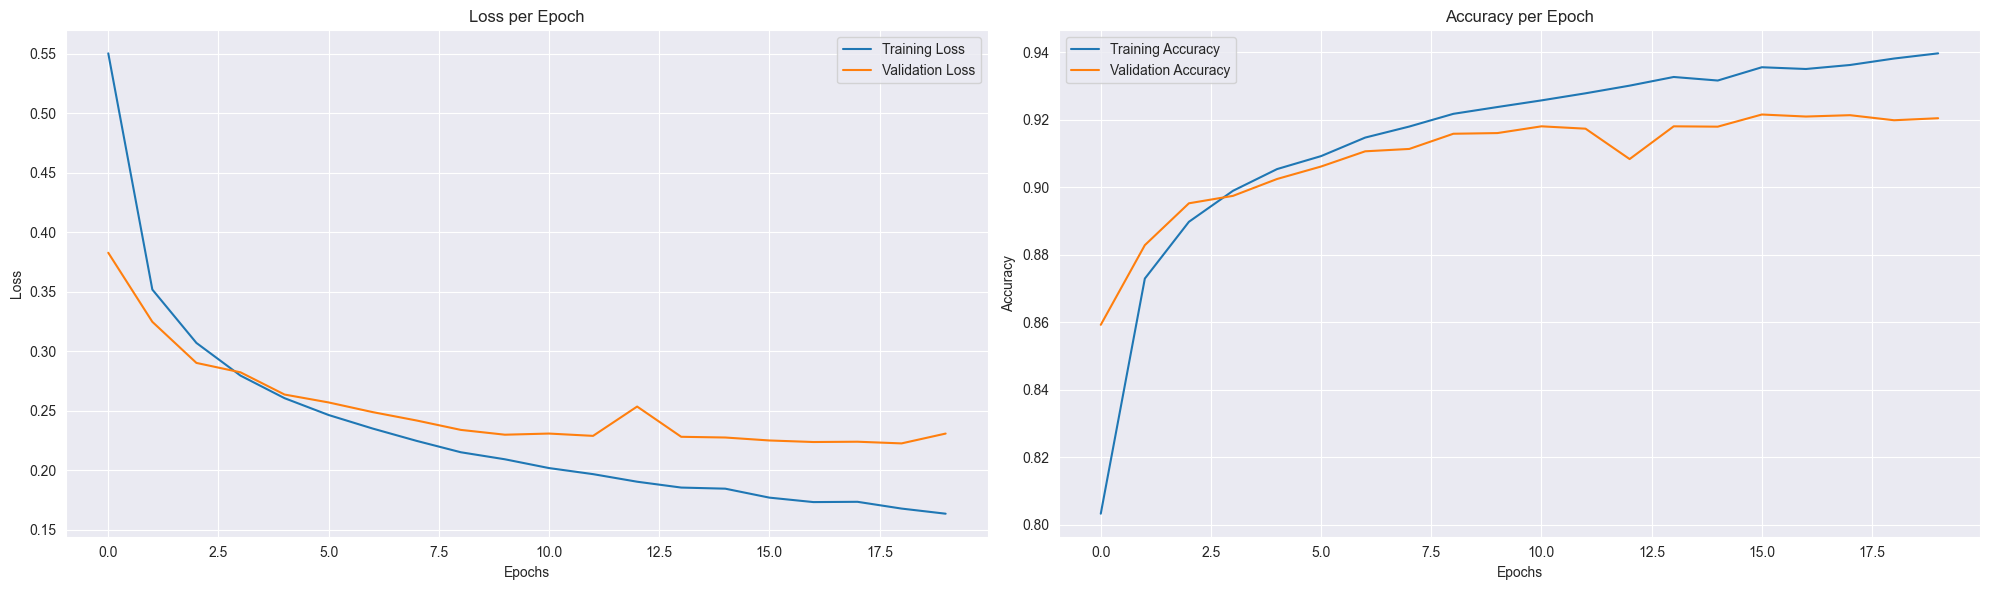

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.89      0.86      0.88      1000
           3       0.94      0.91      0.92      1000
           4       0.87      0.88      0.88      1000
           5       0.98      0.99      0.99      1000
           6       0.73      0.80      0.76      1000
           7       0.97      0.96      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

balanced accuracy 0.9198000000000001


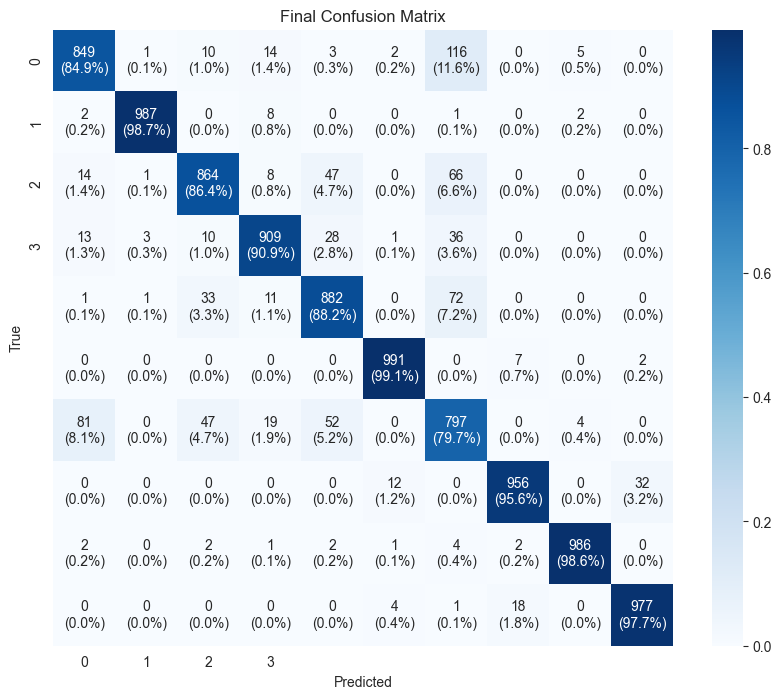

np.float64(0.9198000000000001)

In [ ]:
model = CNN(kernel_n=32, dropout_p=0.3)
train(model)

# Transfer Learning

## Inspección y armado del dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

In [ ]:
def balanced_subset(dataset, target_size):
    targets = np.array(dataset.targets)
    classes = np.unique(targets)
    n_samples_per_class = target_size // len(classes)

    indices = []
    for c in classes:
        class_indices = np.where(targets == c)[0]
        sampled_indices = np.random.choice(class_indices, n_samples_per_class, replace=False)
        indices.extend(sampled_indices)

    return Subset(dataset, indices)

def relabel(dataset):
    dataset.targets = (dataset.targets > 4).long()

In [ ]:
balanced_train_data = balanced_subset(train_data, target_size=20000)

original_targets = [train_data.targets[i].item() for i in balanced_train_data.indices]

relabel(train_data)
relabel(test_data)

relabel_targets = [train_data.targets[i].long().item() for i in balanced_train_data.indices]

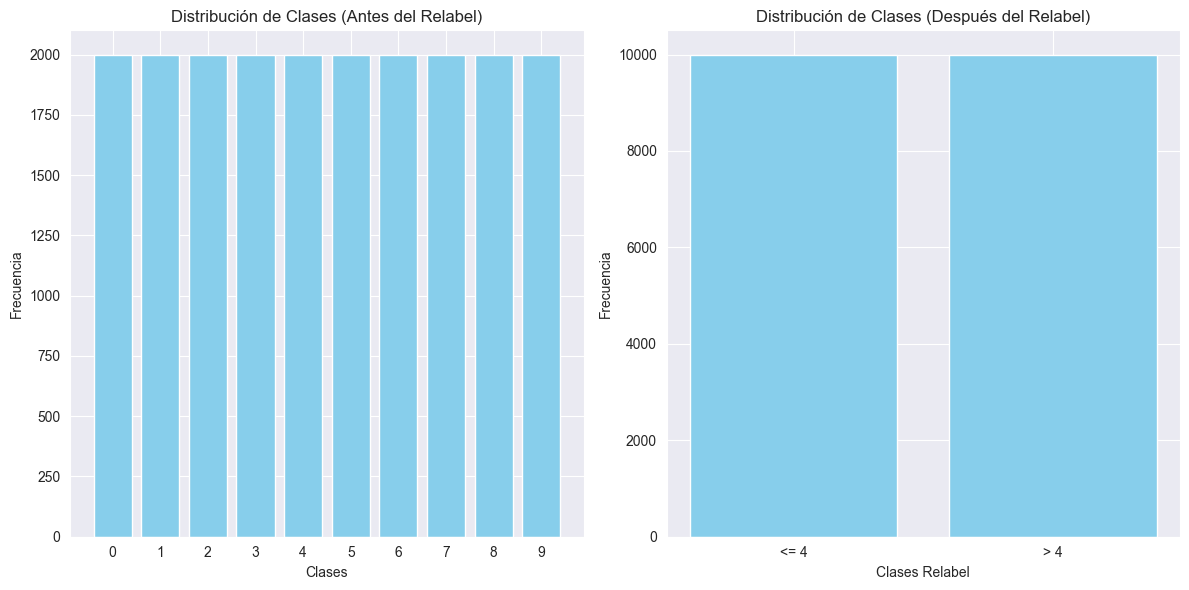

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(range(10), [original_targets.count(i) for i in range(10)], color='skyblue')
axes[0].set_title("Distribución de Clases (Antes del Relabel)")
axes[0].set_xlabel("Clases")
axes[0].set_ylabel("Frecuencia")
axes[0].set_xticks(range(10))

axes[1].bar([0, 1], [relabel_targets.count(0), relabel_targets.count(1)], color='skyblue')
axes[1].set_title("Distribución de Clases (Después del Relabel)")
axes[1].set_xlabel("Clases Relabel")
axes[1].set_ylabel("Frecuencia")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["<= 4", "> 4"])

plt.tight_layout()
plt.show()

Se observa que la distribución de las clases es equitativa.

In [ ]:
print(f'Tamaño de la data de entrenamiento {len(train_data)}')
print(f'Tamaño de la data de validación {len(test_data)}')

mnist_dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

train_features, train_labels = next(iter(mnist_dataloader['train']))

print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

Tamaño de la data de entrenamiento 60000
Tamaño de la data de validación 10000
Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])


Al estar en escalas de grises vemos que tienen un solo canal, también podemos ver que son imágenes de 28x28 pixeles

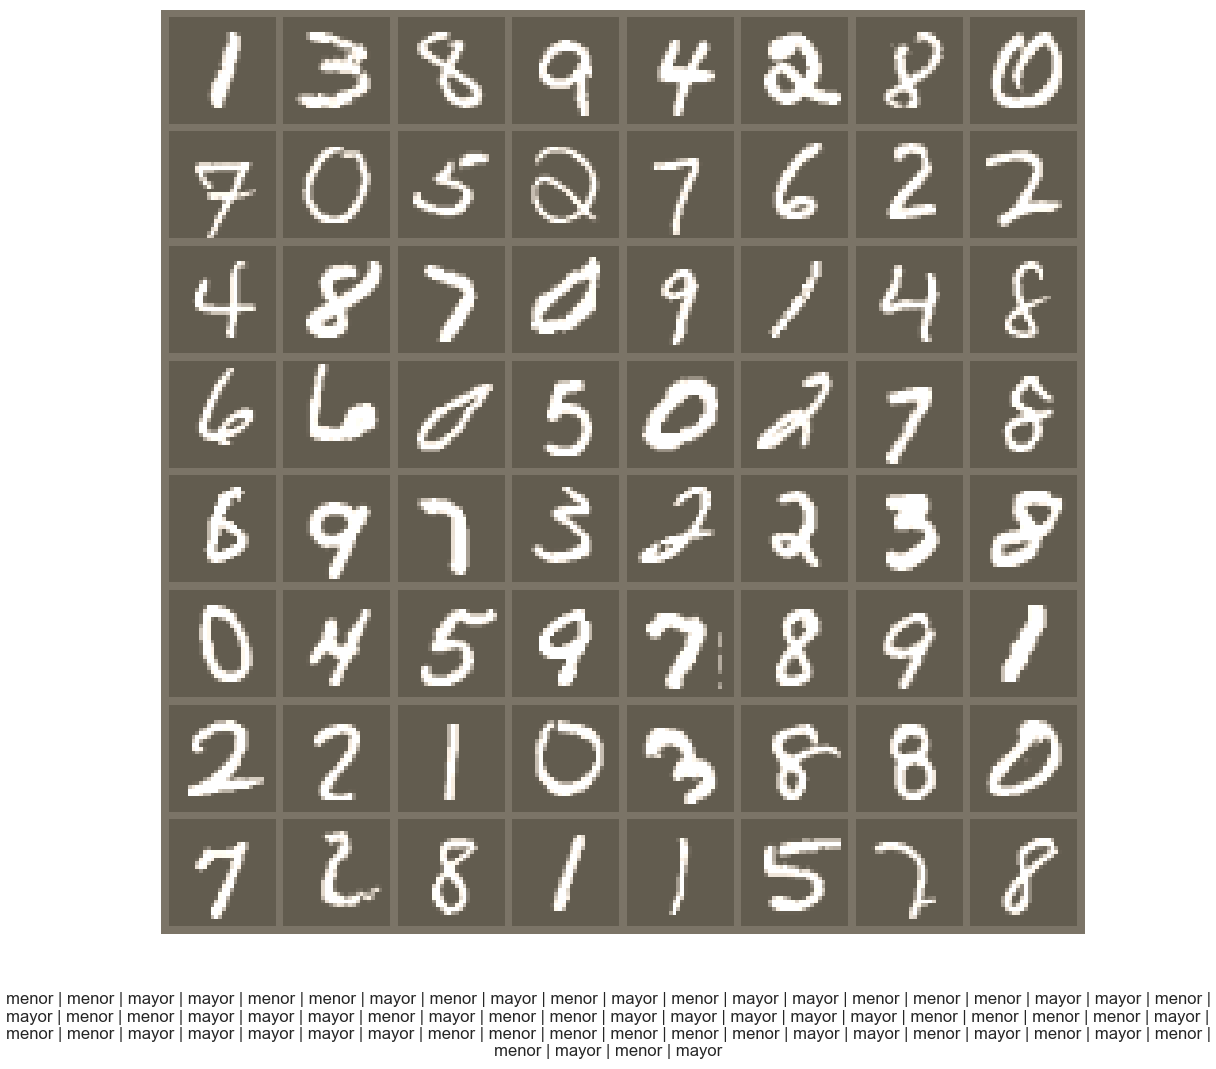

In [ ]:
def imshow(inp, title=None, class_labels=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(12, 12))

    plt.imshow(inp)
    plt.axis('off')

    if title is not None:
        plt.title(title, fontsize=16, pad=20)

    if class_labels is not None:
        formatted_labels = " | ".join(class_labels)
        plt.figtext(0.5, 0.01, formatted_labels, wrap=True, horizontalalignment='center', fontsize=12)

    plt.show()

inputs, classes = next(iter(mnist_dataloader['train']))

out = utils.make_grid(inputs)

class_names = [
    "menor", "mayor"
]

class_labels = [class_names[x] for x in classes]

imshow(out, class_labels=class_labels)

## Implementación

In [ ]:
def freeze_layers(model, num_layers_to_freeze):
    layer_count = 0
    for param in model.parameters():
        if layer_count < num_layers_to_freeze:
            param.requires_grad = False
        else:
            param.requires_grad = True
        layer_count += 1

    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 2)

    return model

In [ ]:
model

CNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1152, out_features=10, bias=True)
)

### Congelar capas inferiores (Fine-tuning parcial)

Esta estrategia es adecuada para situaciones en las que:

Se cuenta con un dataset de tamaño moderado, pero con una cantidad suficiente de muestras como para permitir ajustes. La tarea objetivo es parcialmente similar a la tarea original del modelo entrenado, pero con diferencias significativas que requieran del entrenamiento de las capas superiores para adaptarse mejor al nuevo dominio.

Este caso se ajusta muy bien a esta situación dónde:
- Aunque el dataset ha sido reducido, la cantidad de muestras sigue siendo bastante generosa.
- Tanto la tarea original como la nueva implican la clasificación de imágenes de entrada con dimensiones 28x28 en blanco y negro. Sin embargo, existe una diferencia importante en la naturaleza del problema y es que la tarea original clasificaba 10 clases distintas (prendas de ropa), mientras que la tarea actual se enfoca en clasificar imágenes numéricas en dos categorías (binarias). Esto requiere un ajuste en las capas superiores para que el modelo pueda adaptarse al nuevo conjunto de características específicas de los números.

Pretendo solo entrenar las capas superiores y mantener las primeras capa congeladas:

- Las capas inferiores del modelo preentrenado capturan características genéricas (como bordes y patrones básicos).
- Las capas superiores y la capa totalmente conectada (fully connected) aprenden representaciones más específicas relacionadas con la tarea original, que en este caso deben ajustarse a las diferencias entre las imágenes de prendas y las imágenes de números.


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [12, 2]                   --
├─Sequential: 1-1                        [12, 32, 14, 14]          --
│    └─Conv2d: 2-1                       [12, 32, 28, 28]          (320)
│    └─ReLU: 2-2                         [12, 32, 28, 28]          --
│    └─MaxPool2d: 2-3                    [12, 32, 14, 14]          --
├─Dropout2d: 1-2                         [12, 32, 14, 14]          --
├─Sequential: 1-3                        [12, 64, 7, 7]            --
│    └─Conv2d: 2-4                       [12, 64, 14, 14]          (18,496)
│    └─ReLU: 2-5                         [12, 64, 14, 14]          --
│    └─MaxPool2d: 2-6                    [12, 64, 7, 7]            --
├─Dropout2d: 1-4                         [12, 64, 7, 7]            --
├─Sequential: 1-5                        [12, 128, 3, 3]           --
│    └─Conv2d: 2-7                       [12, 128, 7, 7]           73,856
│ 

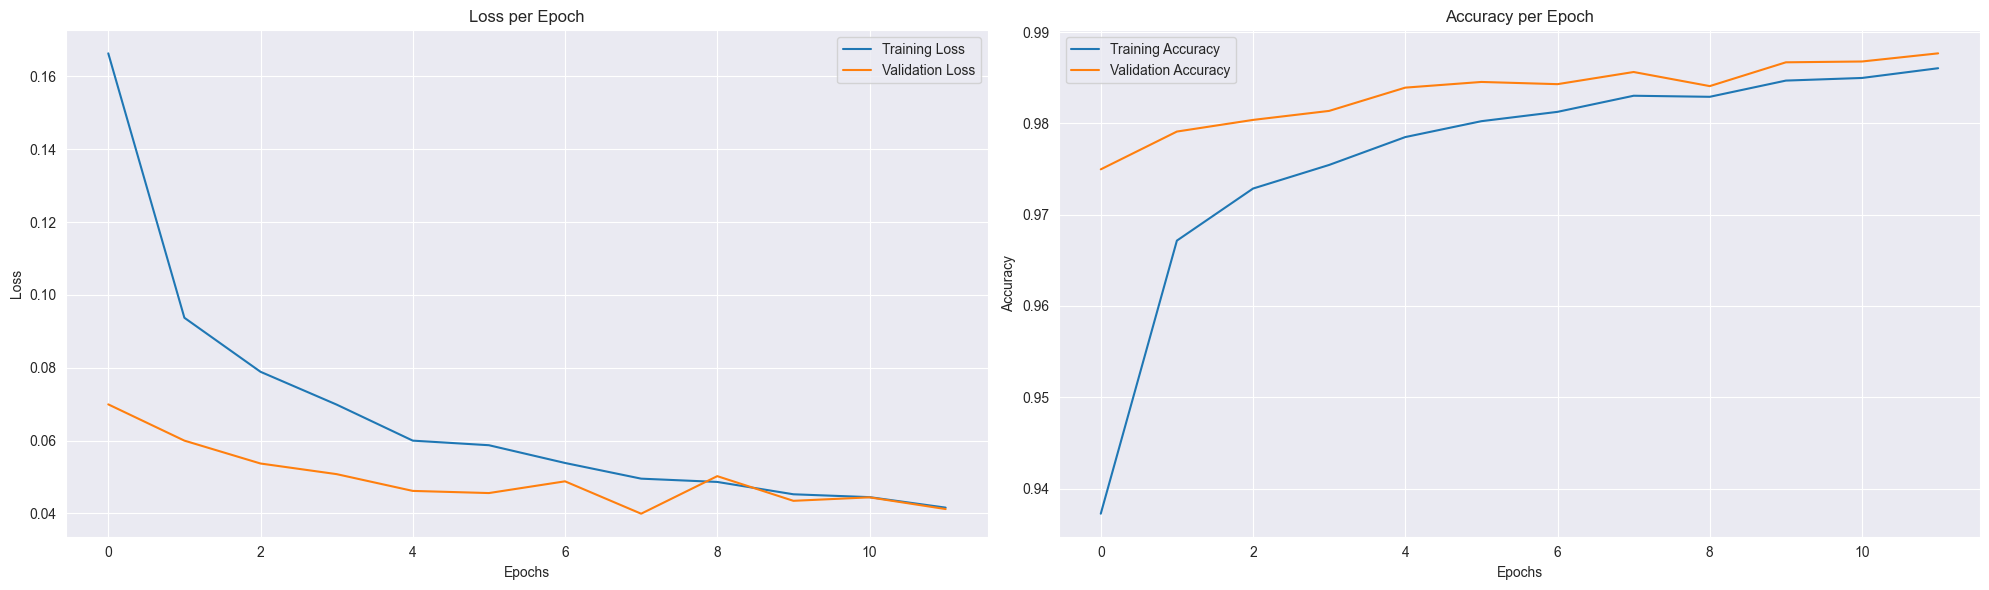

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5139
           1       0.98      0.99      0.99      4861

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

balanced accuracy 0.9856333768990027


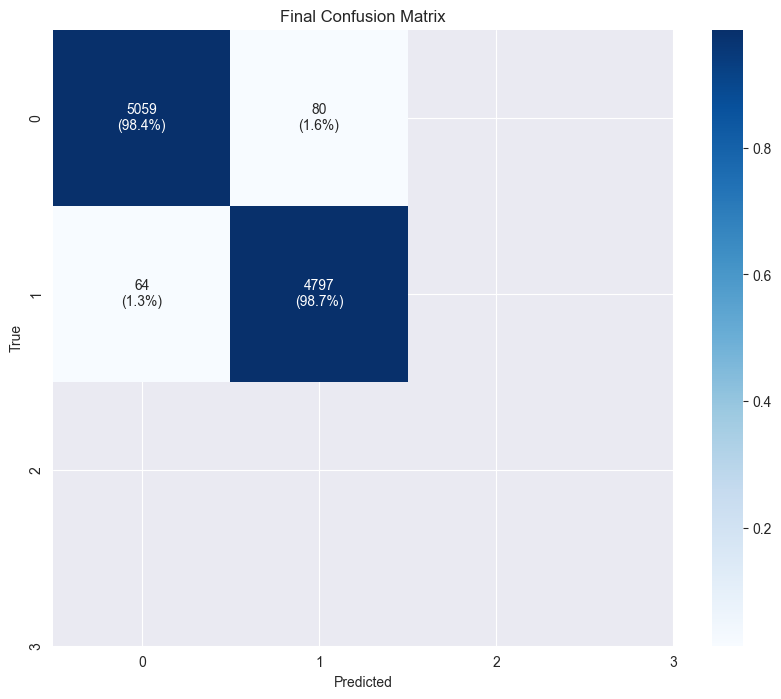

np.float64(0.9856333768990027)

In [ ]:
model_mnist_1 = copy.deepcopy(model)

train(freeze_layers(model_mnist_1, num_layers_to_freeze=4), dataloader=mnist_dataloader)

### Entrenamiento desde cero

Red creada
arquitectura:
CNN(
  (drop): Dropout2d(p=0.3, inplace=False)
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1152, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  104202
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [12, 10]                  --
├─Sequenti

C:\Users\chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 1 | Train Loss: 0.1410 | Valid Loss: 0.0537 | Train Accuracy: 0.9439 | Valid Accuracy: 0.9796
Epoch 2 | Train Loss: 0.0597 | Valid Loss: 0.0415 | Train Accuracy: 0.9793 | Valid Accuracy: 0.9836
Epoch 3 | Train Loss: 0.0458 | Valid Loss: 0.0316 | Train Accuracy: 0.9842 | Valid Accuracy: 0.9881
Epoch 4 | Train Loss: 0.0397 | Valid Loss: 0.0471 | Train Accuracy: 0.9863 | Valid Accuracy: 0.9850
Epoch 5 | Train Loss: 0.0353 | Valid Loss: 0.0289 | Train Accuracy: 0.9882 | Valid Accuracy: 0.9909
Epoch 6 | Train Loss: 0.0316 | Valid Loss: 0.0313 | Train Accuracy: 0.9888 | Valid Accuracy: 0.9890
Epoch 7 | Train Loss: 0.0287 | Valid Loss: 0.0251 | Train Accuracy: 0.9899 | Valid Accuracy: 0.9907
Epoch 8 | Train Loss: 0.0261 | Valid Loss: 0.0328 | Train Accuracy: 0.9909 | Valid Accuracy: 0.9897
Epoch 9 | Train Loss: 0.0251 | Valid Loss: 0.0283 | Train Accuracy: 0.9916 | Valid Accuracy: 0.9921
Epoch 10 | Train Loss: 0.0217 | Valid Loss: 0.0271 | Train Accuracy: 0.9926 | Valid Accuracy: 0.9920

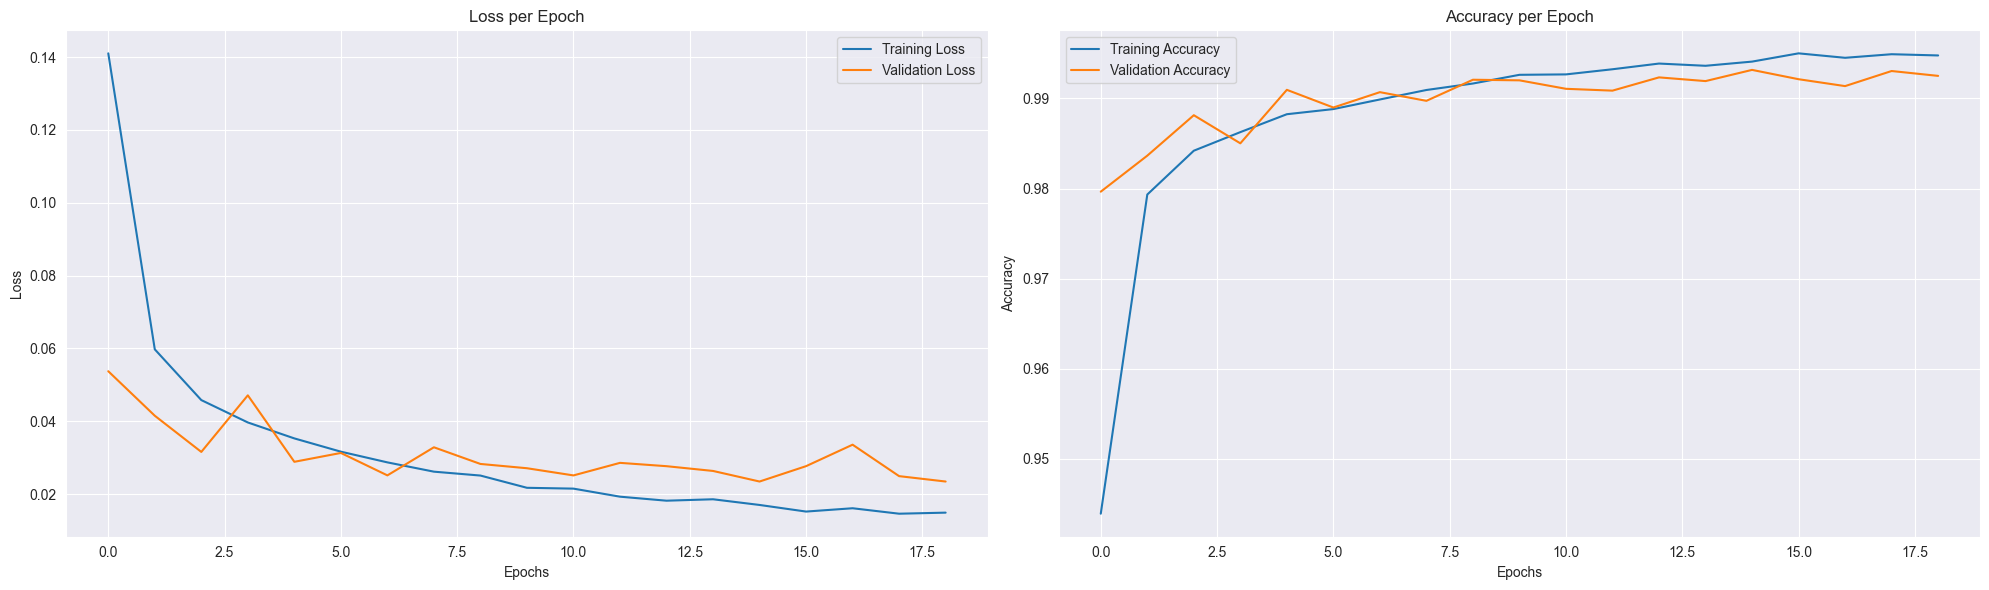

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5139
           1       0.99      0.99      0.99      4861

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

balanced accuracy 0.9931613548214602


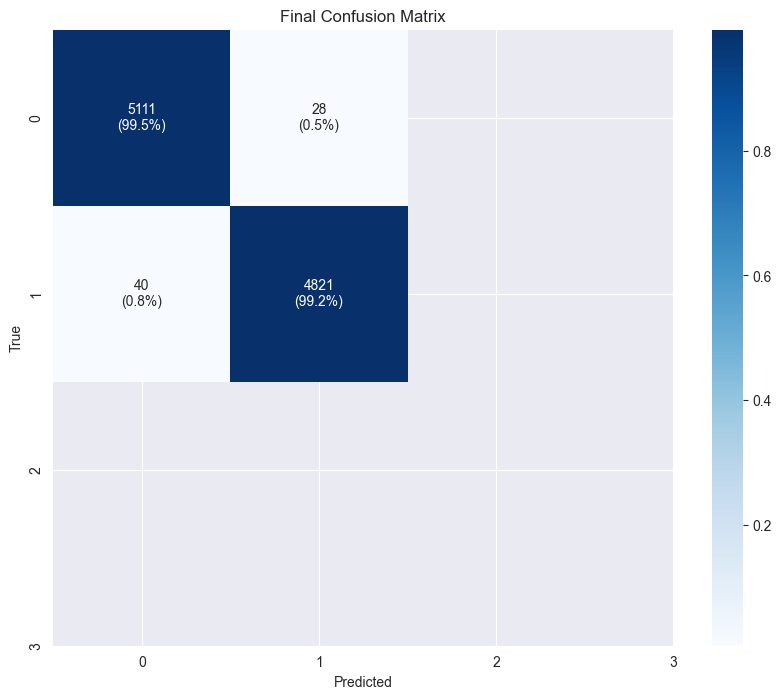

np.float64(0.9931613548214602)

In [ ]:
model_mnist_2 = CNN(kernel_n=32)
train(model_mnist_2, dataloader=mnist_dataloader)

## Análisis comparativo

| Modelo                     | Tiempo de Ejecución | Parámetros entrenables | Accuracy (%) | F1-Score (%) |
|----------------------------|---------------------|------------------------|--------------|--------------|
| Transfer Learning          | 230 segundos        | 76.162                 | 98.56        | 99.00        |
| Entrenado Desde Cero       | 356 segundos        | 104.202                | 99.31        | 99.00        |


Ambos modelos obtuvieron métricas de desempeño prácticamente equivalentes. Aunque el modelo entrenado desde cero alcanzó una precisión ligeramente superior, esta diferencia es mínima y probablemente no significativa en términos prácticos.

En términos de eficiencia computacional, el modelo con transfer learning presentó una ventaja clara, requiriendo menos tiempo y recursos durante el entrenamiento. Esto se debe a que las capas inferiores, al estar congeladas, no necesitan ser ajustadas. En este caso, esto resultó en una disminución del 30% en los parámetros entrenables.

Tanto las métricas de validación como las curvas de pérdida son muy similares entre ambos modelos. Las diferencias observadas en las gráficas son atribuibles a la escala y al hecho de que el modelo con transfer learning finalizó antes debido al mecanismo de early stopping para prevenir el sobre ajuste. En ambos casos, los modelos aprenden hasta un punto y luego presentan signos de sobre ajuste, sin embargo, esto es esperado y aceptable considerando las altas métricas de precisión obtenidas.

Dado que ambos modelos tienen un rendimiento prácticamente idéntico, pero el modelo con transfer learning es más eficiente computacionalmente y aprovecha conocimiento preexistente, pienso que el transfer learning fue todo un éxito. 1